# Probando en otros niveles de OTU
En este script lo que vamos a ver es el mejor modelo en diferentes niveles taxonomicos cogiendo los datos que solo tienen los OTUs que se dan al menos en el 80% de los samples

En este jupyter hemos incluido el guardado de las predicciones y tambien los errores por otu para poder luego verlos en un Rscript bien (hacer figuras sobre todo)

# Parte comun

In [1]:
#importamos paquetes
import sys
sys.path.append('Src/')
from data_modificado import * #hay funciones que estan cambiadas en este script para adaptralas a nuestro dataset
from train_2 import * #este hubo que modificar una linea tambien
from transfer_learning import * #hubo que modificart lo mismo que en train_2
from transfer_learning_FI import * #necesario para el Feature Importance
from test_functions import *
from layers import *
from utils import *
from loss import *
from metric import *
from results import *
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
import itertools as it

#funciones
def read_df(
              metadata_names=['age','Temperature','Precipitation3Days'],
              random_state=42,
              otu_filename='../Datasets/otu_table_all_80.csv',
              metadata_filename='../Datasets/metadata_table_all_80.csv'):
    otu = pd.read_csv(otu_filename, index_col=0, header=None).T
    #print(otu.head())
    otu = otu.set_index('otuids')
    otu = otu.astype('int32')
    metadata = pd.read_csv(metadata_filename)
    #print(metadata.head())
    metadata = metadata.set_index('X.SampleID')
    metadata.head()
    domain = metadata[metadata_names]
    #if 'INBREDS' in metadata_names:
    #    domain = pd.concat([domain, pd.get_dummies(domain['INBREDS'], prefix='INBREDS')], axis=1)
    #    domain = domain.drop(['INBREDS'], axis=1)
    #elif 'Maize_Line' in metadata_names:
    #    domain = pd.concat([domain, pd.get_dummies(domain['Maize_Line'], prefix='Maize_Line')], axis=1)
    #    domain = domain.drop(['Maize_Line'], axis=1) 
    df = pd.concat([otu, domain], axis=1, sort=True, join='outer')
    #print(df.head())
    #data_microbioma = df[otu.columns].to_numpy(dtype=np.float32)
    #data_domain = df[domain.columns].to_numpy(dtype=np.float32)
    df_microbioma = df[otu.columns]
    df_domain = df[domain.columns]
    df_domain.head()
    df_microbioma_train, df_microbioma_no_train, df_domain_train, df_domain_no_train = \
        train_test_split(df_microbioma, df_domain, test_size=0.1, random_state=random_state)
    # Transfer learning subset
    df_microbioma_test, df_microbioma_transfer_learning, df_domain_test, df_domain_transfer_learning = \
        train_test_split(df_microbioma_no_train, df_domain_no_train, test_size=0.1, random_state=random_state)
    df_microbioma_transfer_learning_train, df_microbioma_transfer_learning_test, df_domain_transfer_learning_train, df_domain_transfer_learning_test = \
        train_test_split(df_microbioma_transfer_learning, df_domain_transfer_learning, test_size=0.3, random_state=random_state)
    
    return df_microbioma_train, df_microbioma_test, df_microbioma_transfer_learning_train, df_microbioma_transfer_learning_test, df_domain_train, df_domain_test, df_domain_transfer_learning_train, df_domain_transfer_learning_test, otu.columns, domain.columns
    #return df_microbioma_train, df_microbioma_test, df_microbioma_transfer_learning_train, df_microbioma_transfer_learning_test, df_domain_train, df_domain_test, df_domain_transfer_learning_train, df_domain_transfer_learning_test, otu.columns, domain.columns


def train_kfold_mod(model_fn, m_train, d_train, z_train, m_test, d_test, z_test,
                batch_size, epochs, train_callbacks):
    all_models = model_fn()
    model, encoder_bioma, encoder_domain, decoder_bioma = all_models
    metrics_prefix = None
    if encoder_bioma is not None and encoder_domain is not None:
        x_train = (m_train, d_train)
        y_train = (m_train, m_train, z_train)
        x_test = (m_test, d_test)
        y_test = (m_test, m_test, z_test)
    elif encoder_bioma is not None:
        x_train = m_train
        y_train = m_train
        x_test = m_test
        y_test = m_test
        metrics_prefix = 'bioma'
    elif encoder_domain is not None:
        x_train = d_train
        y_train = m_train
        x_test = d_test
        y_test = m_test
        metrics_prefix = 'domain'

    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(5000).batch(
        batch_size)
    train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
    val_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)
    val_dataset = val_dataset.prefetch(tf.data.experimental.AUTOTUNE)
    r = model.fit(train_dataset,
                  epochs=epochs,
                  validation_data=val_dataset,
                  callbacks=train_callbacks,
                  verbose=0)
    if metrics_prefix is not None:
        old_keys = r.history
        r.history = {}
        for k, v in old_keys.items():
            if k == 'loss' or k == 'val_loss':
                new_key = k
            elif k.startswith('val_'):
                new_key = 'val_{}_{}'.format(metrics_prefix, k[4:])
            else:
                new_key = '{}_{}'.format(metrics_prefix, k)
            r.history[new_key] = v
    del val_dataset
    del train_dataset
    del x_train
    del y_train
    del x_test
    del y_test
    return r, all_models

def train_2(model_fn,
          data_microbioma,
          data_domain,
          latent_space=10,
          folds=5,
          epochs=20,
          batch_size=128,
          learning_rate_scheduler=ExpDecayScheluder(),
          random_seed=347,
          verbose=0):
    data_zeros_latent = np.zeros((data_microbioma.shape[0], latent_space), dtype=data_microbioma.dtype)
    results = []
    models = []
    train_callbacks = [
        callbacks.EarlyStopping(monitor='val_loss', patience=epochs + 1, restore_best_weights=True)]
    if verbose >= 0:
        train_callbacks += [TqdmCallback(verbose=verbose)]
    if learning_rate_scheduler is not None:
        train_callbacks += [learning_rate_scheduler.make()]

    if folds <= 1:
        m_train, m_test = data_microbioma, data_microbioma
        d_train, d_test = data_domain, data_domain
        z_train, z_test = data_zeros_latent, data_zeros_latent
        tf.random.set_seed(random_seed)
        r, m = train_kfold(model_fn, m_train, d_train, z_train, m_test, d_test, z_test,
                           batch_size, epochs, train_callbacks)
        results.append(r)
        models.append(m)

    else: #EL PROBLEMA ESTA AQUI, QUE HACE FALTA UN 
        kf = KFold(n_splits=folds, random_state=random_seed, shuffle=True)
        tf.random.set_seed(random_seed)

        for train_index, test_index in kf.split(data_microbioma):
            m_train, m_test = data_microbioma[train_index], data_microbioma[test_index]
            #print(m_train)
            #d_train, d_test = data_domain[train_index], data_domain[test_index]
            if data_domain is None:
                d_train, d_test = None, None
            else:
                d_train, d_test = data_domain[train_index], data_domain[test_index]
            #print(d_train)
            #Esto de hacer el if else ha funcionado, pero no se si hace lo que debe bien
            z_train, z_test = data_zeros_latent[train_index], data_zeros_latent[test_index]
            r, m = train_kfold_mod(model_fn, m_train, d_train, z_train, m_test, d_test, z_test,
                               batch_size, epochs, train_callbacks)
            results.append(r)
            models.append(m)
    return results, models

def perform_experiment_2_mod(cv_folds, epochs, batch_size, learning_rate, optimizer,
                       learning_rate_scheduler, input_transform, output_transform,
                       reconstruction_loss, latent_space, layers,
                       activation, activation_latent,
                       data_microbioma_train, data_domain_train,
                       show_results=True, device='/CPU:0'): #Show results cambiado de False  aTrue
    if input_transform is not None:
        input_transform = input_transform()
    #----------    
    if output_transform is not None:
        output_transform = output_transform()
    #----------      
    if reconstruction_loss.__class__.__name__ == 'MakeLoss':
        reconstruction_loss = reconstruction_loss.make()
    else:
        reconstruction_loss = reconstruction_loss()
    domain_layers = [l // 16 for l in layers] ####que es esto???? Esto es para las capas del domain
    #print(domain_layers)
    bioma_autoencoder = " -> ".join(["b"] +
                                    [str(l) for l in layers] +
                                    [str(latent_space)] +
                                    [str(l) for l in reversed(layers)] +
                                    ["b"])
    #---------- 
    #esto solo se utiliza para el texto, es irrelevante para nuestro error
    if data_domain_train is not None:
        domain_autoencoder = " -> ".join(["d"] +
                                     [str(l) for l in domain_layers] +
                                     [str(latent_space)] +
                                     [str(l) for l in reversed(layers)] +
                                     ["b"])
        
    else: 
        domain_autoencoder = " "
    #---------- 
    #donde se usa domain autoencoder?
    in_transform_name = input_transform.__class__.__name__ if input_transform else "none"
    out_transform_name = output_transform.__class__.__name__ if output_transform else "none"
    lr_scheduler_text = learning_rate_scheduler[
        1] if learning_rate_scheduler is not None else "none"
    lr_text = learning_rate if learning_rate_scheduler is not None else "constant = {}".format(
        learning_rate)
    learning_rate_scheduler = learning_rate_scheduler[
        0] if learning_rate_scheduler is not None else None
    optimizer = optimizer(learning_rate=learning_rate)
    #---------- 
    experiment_parameters = [
        ("Input transform", in_transform_name),
        ("Output transform", out_transform_name),
        ("Reconstruction Loss", reconstruction_loss.__class__.__name__),
        ("Latent Space", latent_space),
        ("Bioma Autoencoder", bioma_autoencoder),
        ("Domain Autoencoder", domain_autoencoder),
        ("Activation Encoder", activation),
        ("Activation Decoder", activation),
        ("Activation Latent", activation_latent),
        ("CV folds", cv_folds),
        ("Epochs", epochs),
        ("Batch Size", batch_size),
        ("Learning Rate Scheduler", lr_scheduler_text),
        ("Learning Rate", lr_text),
        ("Optimizer", optimizer.__class__.__name__),
    ]
    #----------  
    if show_results:
        md_text = ""
        md_text += "| Parameter             | Value         |\n"
        md_text += "|:----------------------|:--------------|\n"
        for n, v in experiment_parameters:
            md_text += "| {} | {} |\n".format(n, v)

        display(Markdown(md_text))
    #------------
    def create_model(print_data=False):
        bioma_shape=data_microbioma_train.shape[1]
        
        if data_domain_train is not None:
            domain_shape=data_domain_train.shape[1]
            #print("data_domain_train!=None")
        else:
            domain_shape=None
            #print("data_domain_train==None")
        models = autoencoder(bioma_shape=bioma_shape,
                             #bioma_shape=717,
                             domain_shape=domain_shape,
                             output_shape=bioma_shape,
                             #output_shape=717,
                             latent_space=latent_space,
                             bioma_layers=layers, #Esto es lo de [512,316]
                             domain_layers=domain_layers, #Esto son cada una de las layers divididas por 16
                             input_transform=input_transform,
                             output_transform=output_transform,
                             activation_function_encoder=activation,
                             activation_function_decoder=activation,
                             activation_function_latent=activation_latent)
        #Entiendo analizando lo demas que aqui NO esta el error
        #la funcion autoencoder esta en model.py (es la unica funcion en ese script)
        
        model, encoder_bioma, encoder_domain, decoder_bioma = models

        if print_data:
            plot_models(model, encoder_bioma, encoder_domain, decoder_bioma)
        compile_train(model,
                      encoder_bioma=encoder_bioma,
                      encoder_domain=encoder_domain,
                      reconstruction_error=reconstruction_loss,
                      encoded_comparison_error=losses.MeanAbsoluteError(),
                      metrics=get_experiment_metrics(input_transform, output_transform),
                      optimizer=optimizer)
        
        #print("He acabado create_model :)")
        return model, encoder_bioma, encoder_domain, decoder_bioma
    #-----------
    create_model(print_data=False)
    #-----------
    #Esta en esta seccion el problema, en train_2
    #print(data_domain_train)
    #print(latent_space)
    with tf.device(device):
        results, models = train_2(create_model,
                                data_microbioma_train,
                                data_domain_train,
                                latent_space=latent_space,
                                folds=cv_folds,
                                epochs=epochs,
                                batch_size=batch_size,
                                learning_rate_scheduler=learning_rate_scheduler,
                                verbose=-1)
    #----------
    validation_results = print_results(results, show_results=show_results)
    if show_results:
        display(Markdown("*************"))

    return experiment_parameters + validation_results, models, results

--------------------
Estas funciones comunes seran para guardar los datos y ver su error_per_OTU

In [2]:
##Creo que esto es comun, por lo que no hay que pasarlo a todas
def save_predicted_otu_table_and_latent(pred,pred_latent,sample_names,otu_names,suffix=''):
    df_otu = pd.DataFrame(pred, index=sample_names, columns=otu_names)
    df_otu.T.to_csv('Results/otus_'+suffix+'.tsv', index=True, header=True, sep='\t')

    df_latent = pd.DataFrame(pred_latent, index=sample_names)
    df_latent.T.to_csv('Results/latent_'+suffix+'.tsv', index=True, sep='\t')
    
    return df_otu, df_latent

#Compute metrics by OTU
# Absolute abundance transformed to TSS (with epsilon=1E-6)
def transform_to_rel_abundance(dataset):
    epsilon=1E-6
    sum_per_sample = dataset.sum(axis=1)
    num_samples = sum_per_sample.shape
    num_OTUs = np.shape(dataset)[-1] 
    sum_per_sample = sum_per_sample + (num_OTUs * epsilon)
    dividend=dataset+epsilon
    dataset_rel_abund = np.divide(dividend,sum_per_sample[:,None])
    #display(Markdown("{}</p>".format(np.array2string(actual_array,precision=6,floatmode='fixed'))))
    #actual_array.sum(axis=1)
    return dataset_rel_abund
def compute_relative_squared_error(actual,pred):
    rse_otu=np.zeros(actual.shape[1],dtype=np.float32)
    actual=actual_array.transpose()
    pred=pred_domain.transpose()
    # for each OTU
    for i, (act_otu,pred_otu) in enumerate(zip(actual,pred)):
        mean_otu = act_otu.mean()
        #display(Markdown("{} (mean(act)): {}</p>".format(i,mean_otu)))
        #display(Markdown("{} (act): {}</p>".format(i,np.array2string(act_otu,precision=8,floatmode='fixed'))))
        #display(Markdown("{} (pred): {}</p>".format(i,np.array2string(pred_otu,precision=8,floatmode='fixed'))))
        div_up=((pred_otu-act_otu)**2).sum()
        div_down=((pred_otu-mean_otu)**2).sum()
        rse_otu[i]=div_up/div_down
    return rse_otu, np.sqrt(rse_otu)

def save_errors_per_OTU(RSE,RRSE,otu_names,suffix=''):
    df_RSE = pd.DataFrame(RSE, index=otu_names, columns=['RSE'])
    df_RRSE = pd.DataFrame(RRSE, index=otu_names, columns=['RRSE'])
    df_error = df_RSE.join(df_RRSE)
    df_error.to_csv(suffix+'.tsv', index=True, header=True, sep='\t')
    
    return df_error

Funcion para sacar la feature Importance en cada uno de los modelos

In [ ]:
def FI(): ##Hay que tener cuidado cuando se ejecute esto
    metric_results, _ = test_model_tl_noEnsemble_FI(model_latent, decoder, Percentage, tf.keras.layers.Softmax, otu_columns, data_microbioma_test, data_domain_test)
    error_original = metric_results["BrayCurtis"][0]
    metricas = dict()
    for i, variable in enumerate(nombres_metadatos):
        #print(variable)
        df1 = df_domain_test
        valores_BrayCurtis = []
        for j in range(0,10,1): #para sacar la desviacion tipica de cada uno
            #print(j)
            #shuffleamos la variable
            df1[variable] = np.random.permutation(df_domain_test[variable].values)
            data_domain_test_nueva = df1.to_numpy()
            #hacemos el modelo
            metric_results, _ = test_model_tl_noEnsemble_FI(model_latent, decoder, Percentage, tf.keras.layers.Softmax, otu_columns, data_microbioma_test, data_domain_test_nueva)
            #valores_BrayCurtis.append(metric_results["BrayCurtis"][0]/error_original)
            valores_BrayCurtis.append(metric_results["BrayCurtis"][0]-error_original)#cualquiera de la dos, tanto division como resta vale, pero esta me parece mas facil de comparar
        metricas[variable] = valores_BrayCurtis
    return metricas

--------------------------
# 44 variables Latent Combined

### Genus

In [3]:
nombres_metadatos = ["KCAL","PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","SUGR","FIBE","CALC","IRON","MAGN","PHOS","POTA","SODI","ZINC","COPP","SELE","VC","VB1","VB2","NIAC","VB6","FOLA","VB12","VARA","RET","BCAR","ACAR","CRYP","LYCO","LZ","ATOC","VK","CHOLE","SFAT","MFAT","PFAT","VITD","CHOLN"]
#nombres_metadatos = ["PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","CALC","MAGN","POTA","ZINC","VC","VB1","VB6","VARA","ACAR","CRYP","LYCO","ATOC","VK","CHOLE","VITD"]
df_microbioma_train, df_microbioma_test, _, _, \
df_domain_train, df_domain_test, _, _, otu_columns, domain_columns = read_df(metadata_names=nombres_metadatos,otu_filename='resultados_ana/nuevos_datos/arreglados/otu_table_Genus.csv',metadata_filename='resultados_ana/datos_otus_metadatos_genero/metadatos_nutrientes_genero.csv')

data_microbioma_train = df_microbioma_train.to_numpy(dtype=np.float32)
data_microbioma_test = df_microbioma_test.to_numpy(dtype=np.float32)
data_domain_train = df_domain_train.to_numpy(dtype=np.float32)
data_domain_test = df_domain_test.to_numpy(dtype=np.float32)

| Parameter             | Value         |
|:----------------------|:--------------|
| Input transform | Percentage |
| Output transform | Softmax |
| Reconstruction Loss | LossBrayCurtis |
| Latent Space | 15 |
| Bioma Autoencoder | b -> 512 -> 256 -> 15 -> 256 -> 512 -> b |
| Domain Autoencoder | d -> 32 -> 16 -> 15 -> 256 -> 512 -> b |
| Activation Encoder | tanh |
| Activation Decoder | tanh |
| Activation Latent | softmax |
| CV folds | 0 |
| Epochs | 100 |
| Batch Size | 64 |
| Learning Rate Scheduler | none |
| Learning Rate | constant = 0.01 |
| Optimizer | Adam |


<p>Best iteration: <b>6</b></p>

<b>loss</b>: 0.8491 (min: 0.8491, max: 0.8491)

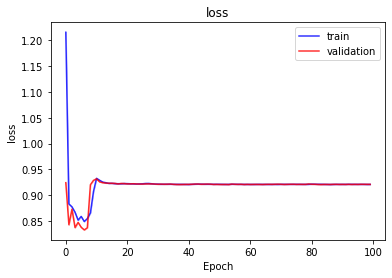

<b>bioma_loss</b>: 0.4215 (min: 0.4215, max: 0.4215)

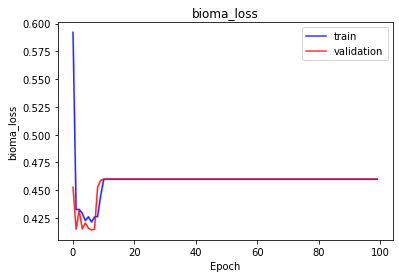

<b>domain_loss</b>: 0.4221 (min: 0.4221, max: 0.4221)

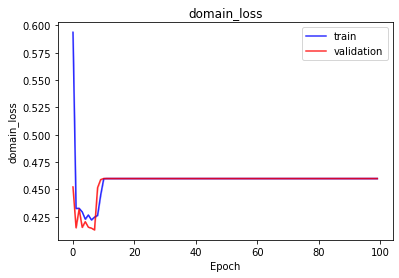

<b>latent_loss</b>: 0.0054 (min: 0.0054, max: 0.0054)

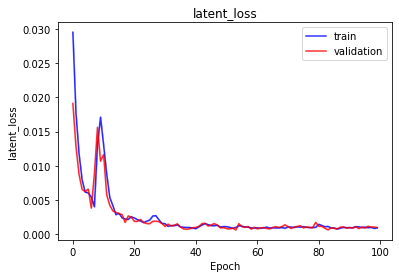

<b>bioma_mse</b>: 303917856.0000 (min: 303917856.0000, max: 303917856.0000)

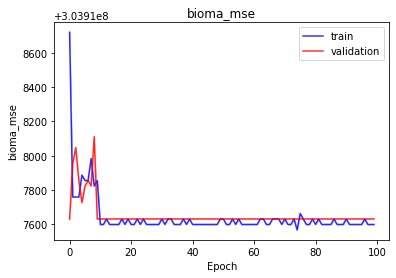

<b>bioma_mae</b>: 1614.6118 (min: 1614.6118, max: 1614.6118)

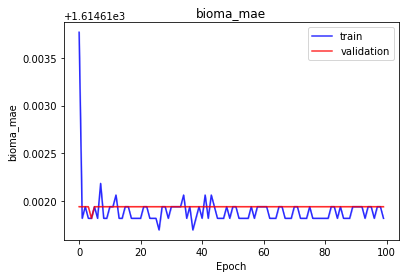

<b>bioma_mape</b>: 68.5390 (min: 68.5390, max: 68.5390)

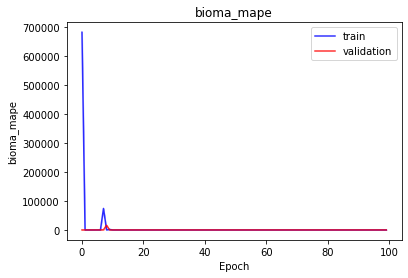

<b>bioma_BrayCurtis</b>: 0.4215 (min: 0.4215, max: 0.4215)

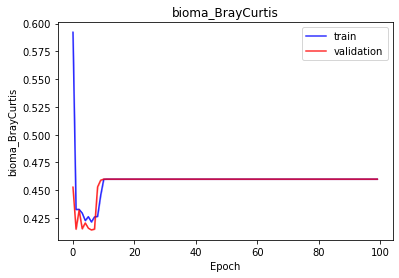

<b>bioma_pearson_corr</b>: 0.8287 (min: 0.8287, max: 0.8287)

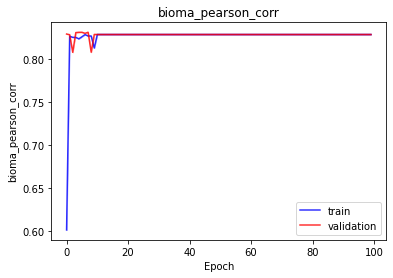

<b>bioma_jensen_shannon_divergence</b>: 2.8700 (min: 2.8700, max: 2.8700)

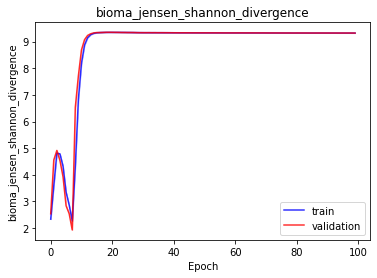

<b>domain_mse</b>: 303917856.0000 (min: 303917856.0000, max: 303917856.0000)

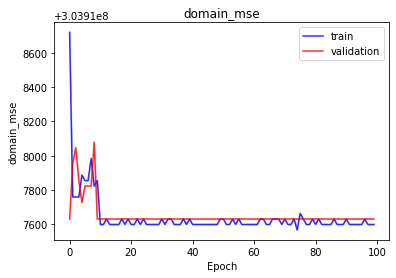

<b>domain_mae</b>: 1614.6118 (min: 1614.6118, max: 1614.6118)

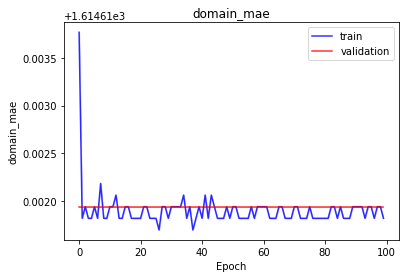

<b>domain_mape</b>: 69.2014 (min: 69.2014, max: 69.2014)

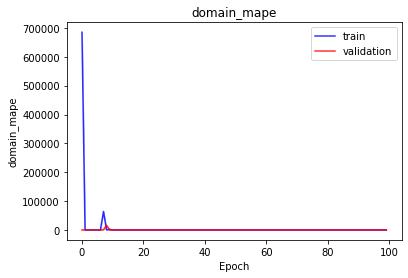

<b>domain_BrayCurtis</b>: 0.4221 (min: 0.4221, max: 0.4221)

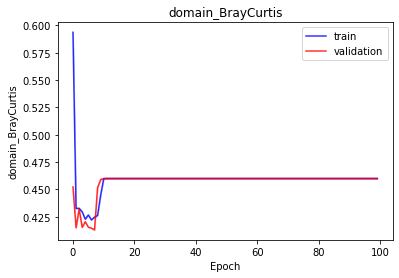

<b>domain_pearson_corr</b>: 0.8285 (min: 0.8285, max: 0.8285)

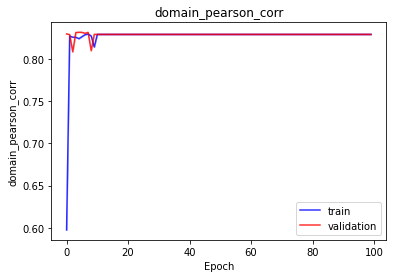

<b>domain_jensen_shannon_divergence</b>: 2.8903 (min: 2.8903, max: 2.8903)

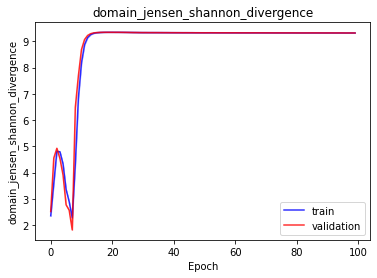

<b>latent_mae</b>: 0.0054 (min: 0.0054, max: 0.0054)

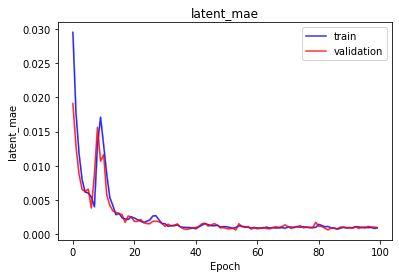

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 0.8490532040596008 | 0.8490532040596008 | 0.8490532040596008 |
| bioma_loss | 0.42146745324134827 | 0.42146745324134827 | 0.42146745324134827 |
| domain_loss | 0.4221450388431549 | 0.4221450388431549 | 0.4221450388431549 |
| latent_loss | 0.0054407804273068905 | 0.0054407804273068905 | 0.0054407804273068905 |
| bioma_mse | 303917856.0 | 303917856.0 | 303917856.0 |
| bioma_mae | 1614.61181640625 | 1614.61181640625 | 1614.61181640625 |
| bioma_mape | 68.53904724121094 | 68.53904724121094 | 68.53904724121094 |
| bioma_BrayCurtis | 0.42146745324134827 | 0.42146745324134827 | 0.42146745324134827 |
| bioma_pearson_corr | 0.8287462592124939 | 0.8287462592124939 | 0.8287462592124939 |
| bioma_jensen_shannon_divergence | 2.8699545860290527 | 2.8699545860290527 | 2.8699545860290527 |
| domain_mse | 303917856.0 | 303917856.0 | 303917856.0 |
| domain_mae | 1614.61181640625 | 1614.61181640625 | 1614.61181640625 |
| domain_mape | 69.20144653320312 | 69.20144653320312 | 69.20144653320312 |
| domain_BrayCurtis | 0.4221450388431549 | 0.4221450388431549 | 0.4221450388431549 |
| domain_pearson_corr | 0.8285009264945984 | 0.8285009264945984 | 0.8285009264945984 |
| domain_jensen_shannon_divergence | 2.8902747631073 | 2.8902747631073 | 2.8902747631073 |
| latent_mae | 0.0054407804273068905 | 0.0054407804273068905 | 0.0054407804273068905 |


*************

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.47160789370536804 | 0.47160789370536804 | 0.47160789370536804 |
| pearson_corr | 0.8124938607215881 | 0.8124938607215881 | 0.8124938607215881 |
| jensen_shannon_divergence | 9.51863956451416 | 9.51863956451416 | 9.51863956451416 |


In [4]:
experiment_metrics, models, results = perform_experiment_2_mod(cv_folds=0,
                                                               epochs=100,
                                                               batch_size=64,
                                                               learning_rate=0.01,
                                                               optimizer=optimizers.Adam,
                                                               learning_rate_scheduler=None,
                                                               input_transform=Percentage,
                                                               output_transform=tf.keras.layers.Softmax,
                                                               reconstruction_loss=MakeLoss(LossBrayCurtis, Percentage, None),
                                                               latent_space=15,
                                                               layers=[512,256],
                                                               activation='tanh',
                                                               activation_latent='softmax',
                                                               data_microbioma_train=data_microbioma_train,
                                                               data_domain_train=data_domain_train,
                                                               show_results=True,
                                                               device='/CPU:0')
    
#Guardamos el modelo, encoder y decoder
model, encoder, _ ,decoder = models[0]
  
def model_fn_latent():
    in_layer = layers.Input(shape=(data_domain_train.shape[1],))
    net = layers.Dense(128, activation='sigmoid')(in_layer)
    net = layers.Dense(64, activation='sigmoid')(net)
    net = layers.Dense(32, activation='sigmoid')(net)
    net = layers.Dense(16, activation='sigmoid')(net)
    out_layer = layers.Dense(latent_train.shape[1], activation='softmax')(net)
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    model.compile(optimizer=optimizers.Adam(lr=0.01), loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.MeanSquaredError()])
    return model
    
#funcion del modelado -- por ahora lo dejaremos asi, y voy a habalr con ella par aver que cambio, que tuneo
latent_train = encoder.predict(data_microbioma_train)
    
result_latent, model_latent = train_tl_noEnsemble(model_fn_latent,
                                                  latent_train,
                                                  latent_train,
                                                  data_domain_train,
                                                  data_domain_train,
                                                  epochs=100,
                                                  batch_size=16,
                                                  verbose=-1)

#evaluamos el modelo
latent_test = encoder.predict(data_microbioma_test)
predictions = test_model_tl_noEnsemble(model_latent, decoder, Percentage, tf.keras.layers.Softmax, otu_columns, data_microbioma_test, data_domain_test)

In [5]:
encoder_biome = encoder
encoder_domain = model_latent
#Guardamos las predicciones
df_microbioma_test.T.to_csv('Results/otus_original_test_44Combined_genero.tsv', index=True, header=True, sep='\t')

#run prediction test set from microbiome, i.e, reconstructed
# Input only domain (i.e. environmental features)
pred_latent_biome = encoder_biome.predict(data_microbioma_test)
pred_biome = decoder.predict(pred_latent_biome)

_, _ = save_predicted_otu_table_and_latent(pred_biome,pred_latent_biome,df_microbioma_test.index,df_microbioma_test.columns,'reconstAEfromBiome_44Combined_genero')

#run prediction test set from domain, i.e., diet features
# Input only domain (i.e. environmental features)
pred_latent = encoder_domain.predict(data_domain_test)
pred_domain = decoder.predict(pred_latent)
df_pred_otu, df_pred_latent = save_predicted_otu_table_and_latent(pred_domain,pred_latent,df_microbioma_test.index,df_microbioma_test.columns,'predFromDomain_44Combined_genero')

#--------------------
actual_array = transform_to_rel_abundance(data_microbioma_test)
RSE_perOTU, RRSE_perOTU  = compute_relative_squared_error(actual_array,pred_domain)

df_error_perOTU = save_errors_per_OTU(RSE_perOTU,RRSE_perOTU,df_microbioma_test.columns,'Results/errors_perOTU_44Combined_genero')

In [ ]:
metrics = FI()
tabla_FI = pd.DataFrame.from_dict(metrics)
tabla_FI.to_csv("Results/nutrientes/FI/FI_Combined44_genus.csv",index=False)

### Family

In [7]:
nombres_metadatos = ["KCAL","PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","SUGR","FIBE","CALC","IRON","MAGN","PHOS","POTA","SODI","ZINC","COPP","SELE","VC","VB1","VB2","NIAC","VB6","FOLA","VB12","VARA","RET","BCAR","ACAR","CRYP","LYCO","LZ","ATOC","VK","CHOLE","SFAT","MFAT","PFAT","VITD","CHOLN"]
#nombres_metadatos = ["PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","CALC","MAGN","POTA","ZINC","VC","VB1","VB6","VARA","ACAR","CRYP","LYCO","ATOC","VK","CHOLE","VITD"]
df_microbioma_train, df_microbioma_test, _, _, \
df_domain_train, df_domain_test, _, _, otu_columns, domain_columns = read_df(metadata_names=nombres_metadatos,otu_filename='resultados_ana/nuevos_datos/arreglados/otu_table_Family.csv',metadata_filename='resultados_ana/datos_otus_metadatos_familia/metadatos_nutrientes_familia.csv')

data_microbioma_train = df_microbioma_train.to_numpy(dtype=np.float32)
data_microbioma_test = df_microbioma_test.to_numpy(dtype=np.float32)
data_domain_train = df_domain_train.to_numpy(dtype=np.float32)
data_domain_test = df_domain_test.to_numpy(dtype=np.float32)

| Parameter             | Value         |
|:----------------------|:--------------|
| Input transform | Percentage |
| Output transform | Softmax |
| Reconstruction Loss | LossBrayCurtis |
| Latent Space | 15 |
| Bioma Autoencoder | b -> 512 -> 256 -> 15 -> 256 -> 512 -> b |
| Domain Autoencoder | d -> 32 -> 16 -> 15 -> 256 -> 512 -> b |
| Activation Encoder | tanh |
| Activation Decoder | tanh |
| Activation Latent | softmax |
| CV folds | 0 |
| Epochs | 100 |
| Batch Size | 64 |
| Learning Rate Scheduler | none |
| Learning Rate | constant = 0.01 |
| Optimizer | Adam |


<p>Best iteration: <b>87</b></p>

<b>loss</b>: 0.3389 (min: 0.3389, max: 0.3389)

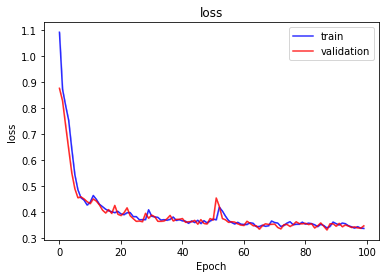

<b>bioma_loss</b>: 0.0724 (min: 0.0724, max: 0.0724)

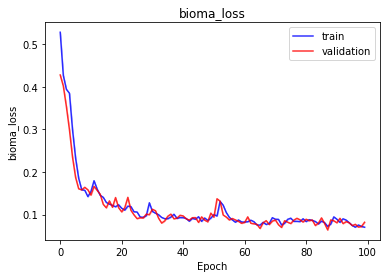

<b>domain_loss</b>: 0.2509 (min: 0.2509, max: 0.2509)

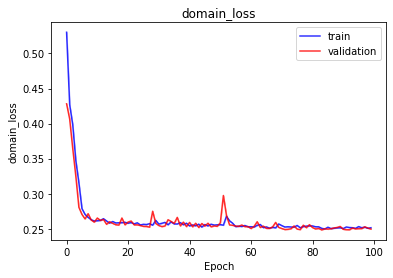

<b>latent_loss</b>: 0.0157 (min: 0.0157, max: 0.0157)

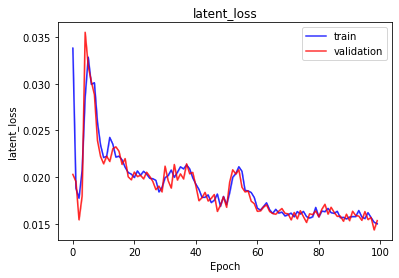

<b>bioma_mse</b>: 878693568.0000 (min: 878693568.0000, max: 878693568.0000)

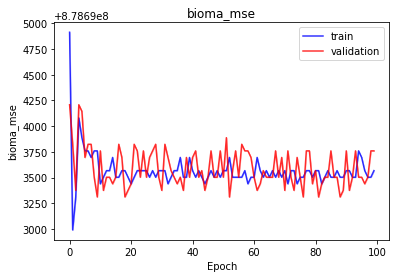

<b>bioma_mae</b>: 4677.9307 (min: 4677.9307, max: 4677.9307)

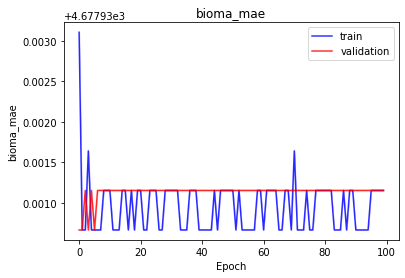

<b>bioma_mape</b>: 14479.3076 (min: 14479.3076, max: 14479.3076)

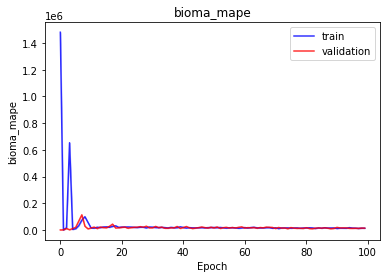

<b>bioma_BrayCurtis</b>: 0.0724 (min: 0.0724, max: 0.0724)

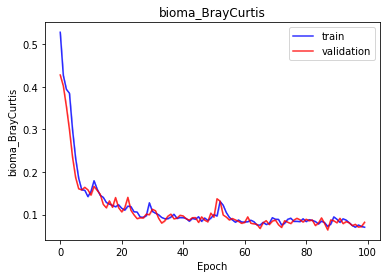

<b>bioma_pearson_corr</b>: 0.9943 (min: 0.9943, max: 0.9943)

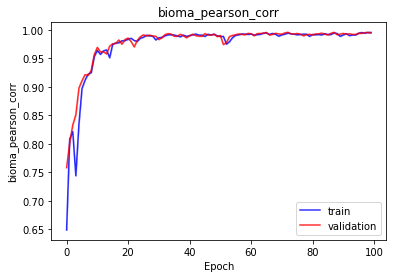

<b>bioma_jensen_shannon_divergence</b>: 0.0766 (min: 0.0766, max: 0.0766)

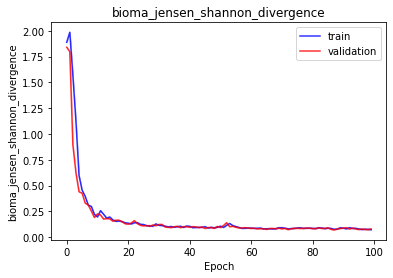

<b>domain_mse</b>: 878694080.0000 (min: 878694080.0000, max: 878694080.0000)

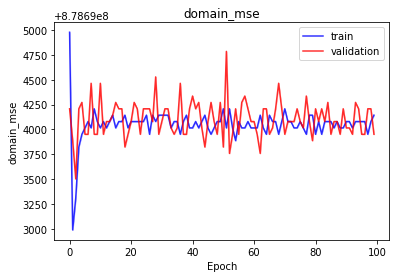

<b>domain_mae</b>: 4677.9307 (min: 4677.9307, max: 4677.9307)

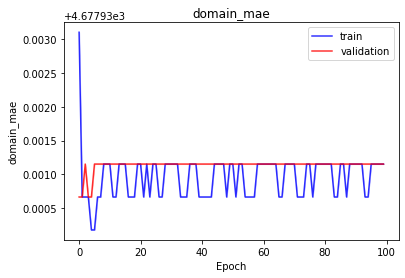

<b>domain_mape</b>: 13312.0195 (min: 13312.0195, max: 13312.0195)

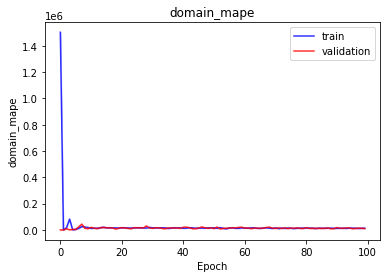

<b>domain_BrayCurtis</b>: 0.2509 (min: 0.2509, max: 0.2509)

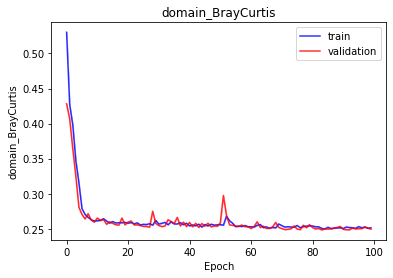

<b>domain_pearson_corr</b>: 0.8765 (min: 0.8765, max: 0.8765)

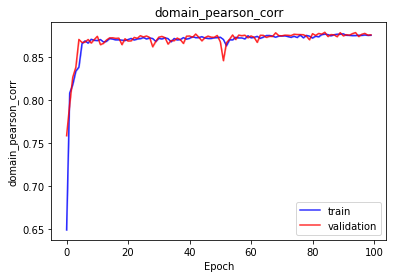

<b>domain_jensen_shannon_divergence</b>: 0.4167 (min: 0.4167, max: 0.4167)

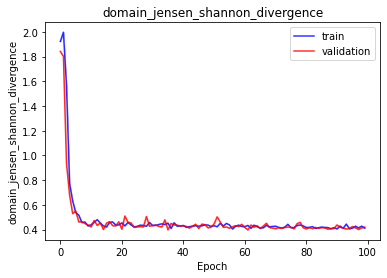

<b>latent_mae</b>: 0.0157 (min: 0.0157, max: 0.0157)

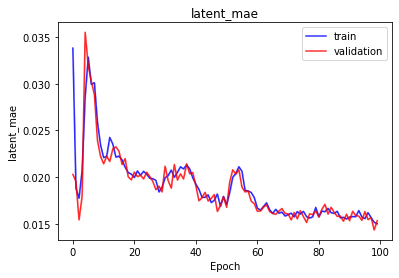

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 0.3388799726963043 | 0.3388799726963043 | 0.3388799726963043 |
| bioma_loss | 0.07236048579216003 | 0.07236048579216003 | 0.07236048579216003 |
| domain_loss | 0.2508687674999237 | 0.2508687674999237 | 0.2508687674999237 |
| latent_loss | 0.015650691464543343 | 0.015650691464543343 | 0.015650691464543343 |
| bioma_mse | 878693568.0 | 878693568.0 | 878693568.0 |
| bioma_mae | 4677.9306640625 | 4677.9306640625 | 4677.9306640625 |
| bioma_mape | 14479.3076171875 | 14479.3076171875 | 14479.3076171875 |
| bioma_BrayCurtis | 0.07236048579216003 | 0.07236048579216003 | 0.07236048579216003 |
| bioma_pearson_corr | 0.9943196177482605 | 0.9943196177482605 | 0.9943196177482605 |
| bioma_jensen_shannon_divergence | 0.07659297436475754 | 0.07659297436475754 | 0.07659297436475754 |
| domain_mse | 878694080.0 | 878694080.0 | 878694080.0 |
| domain_mae | 4677.9306640625 | 4677.9306640625 | 4677.9306640625 |
| domain_mape | 13312.01953125 | 13312.01953125 | 13312.01953125 |
| domain_BrayCurtis | 0.2508687674999237 | 0.2508687674999237 | 0.2508687674999237 |
| domain_pearson_corr | 0.8764921426773071 | 0.8764921426773071 | 0.8764921426773071 |
| domain_jensen_shannon_divergence | 0.41667109727859497 | 0.41667109727859497 | 0.41667109727859497 |
| latent_mae | 0.015650691464543343 | 0.015650691464543343 | 0.015650691464543343 |


*************

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.289099782705307 | 0.289099782705307 | 0.289099782705307 |
| pearson_corr | 0.8721527457237244 | 0.8721527457237244 | 0.8721527457237244 |
| jensen_shannon_divergence | 0.4453902840614319 | 0.4453902840614319 | 0.4453902840614319 |


In [8]:
experiment_metrics, models, results = perform_experiment_2_mod(cv_folds=0,
                                                               epochs=100,
                                                               batch_size=64,
                                                               learning_rate=0.01,
                                                               optimizer=optimizers.Adam,
                                                               learning_rate_scheduler=None,
                                                               input_transform=Percentage,
                                                               output_transform=tf.keras.layers.Softmax,
                                                               reconstruction_loss=MakeLoss(LossBrayCurtis, Percentage, None),
                                                               latent_space=15,
                                                               layers=[512,256],
                                                               activation='tanh',
                                                               activation_latent='softmax',
                                                               data_microbioma_train=data_microbioma_train,
                                                               data_domain_train=data_domain_train,
                                                               show_results=True,
                                                               device='/CPU:0')
    
#Guardamos el modelo, encoder y decoder
model, encoder, _ ,decoder = models[0]
  
def model_fn_latent():
    in_layer = layers.Input(shape=(data_domain_train.shape[1],))
    net = layers.Dense(128, activation='sigmoid')(in_layer)
    net = layers.Dense(64, activation='sigmoid')(net)
    net = layers.Dense(32, activation='sigmoid')(net)
    net = layers.Dense(16, activation='sigmoid')(net)
    out_layer = layers.Dense(latent_train.shape[1], activation='softmax')(net)
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    model.compile(optimizer=optimizers.Adam(lr=0.01), loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.MeanSquaredError()])
    return model
    
#funcion del modelado -- por ahora lo dejaremos asi, y voy a habalr con ella par aver que cambio, que tuneo
latent_train = encoder.predict(data_microbioma_train)
    
result_latent, model_latent = train_tl_noEnsemble(model_fn_latent,
                                                  latent_train,
                                                  latent_train,
                                                  data_domain_train,
                                                  data_domain_train,
                                                  epochs=100,
                                                  batch_size=16,
                                                  verbose=-1)

#evaluamos el modelo
latent_test = encoder.predict(data_microbioma_test)
predictions = test_model_tl_noEnsemble(model_latent, decoder, Percentage, tf.keras.layers.Softmax, otu_columns, data_microbioma_test, data_domain_test)

In [9]:
encoder_biome = encoder
encoder_domain = model_latent
#Guardamos las predicciones
df_microbioma_test.T.to_csv('Results/otus_original_test_44Combined_familia.tsv', index=True, header=True, sep='\t')

#run prediction test set from microbiome, i.e, reconstructed
# Input only domain (i.e. environmental features)
pred_latent_biome = encoder_biome.predict(data_microbioma_test)
pred_biome = decoder.predict(pred_latent_biome)

_, _ = save_predicted_otu_table_and_latent(pred_biome,pred_latent_biome,df_microbioma_test.index,df_microbioma_test.columns,'reconstAEfromBiome_44Combined_familia')

#run prediction test set from domain, i.e., diet features
# Input only domain (i.e. environmental features)
pred_latent = encoder_domain.predict(data_domain_test)
pred_domain = decoder.predict(pred_latent)
df_pred_otu, df_pred_latent = save_predicted_otu_table_and_latent(pred_domain,pred_latent,df_microbioma_test.index,df_microbioma_test.columns,'predFromDomain_44Combined_familia')

#--------------------
actual_array = transform_to_rel_abundance(data_microbioma_test)
RSE_perOTU, RRSE_perOTU  = compute_relative_squared_error(actual_array,pred_domain)

df_error_perOTU = save_errors_per_OTU(RSE_perOTU,RRSE_perOTU,df_microbioma_test.columns,'Results/errors_perOTU_44Combined_familia')

In [ ]:
metrics = FI()
tabla_FI = pd.DataFrame.from_dict(metrics)
tabla_FI.to_csv("Results/nutrientes/FI/FI_Combined44_family.csv",index=False)

### Order

In [10]:
nombres_metadatos = ["KCAL","PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","SUGR","FIBE","CALC","IRON","MAGN","PHOS","POTA","SODI","ZINC","COPP","SELE","VC","VB1","VB2","NIAC","VB6","FOLA","VB12","VARA","RET","BCAR","ACAR","CRYP","LYCO","LZ","ATOC","VK","CHOLE","SFAT","MFAT","PFAT","VITD","CHOLN"]
#nombres_metadatos = ["PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","CALC","MAGN","POTA","ZINC","VC","VB1","VB6","VARA","ACAR","CRYP","LYCO","ATOC","VK","CHOLE","VITD"]
df_microbioma_train, df_microbioma_test, _, _, \
df_domain_train, df_domain_test, _, _, otu_columns, domain_columns = read_df(metadata_names=nombres_metadatos,otu_filename='resultados_ana/nuevos_datos/arreglados/otu_table_Order.csv',metadata_filename='resultados_ana/datos_otus_metadatos_orden/metadatos_nutrientes_orden.csv')

data_microbioma_train = df_microbioma_train.to_numpy(dtype=np.float32)
data_microbioma_test = df_microbioma_test.to_numpy(dtype=np.float32)
data_domain_train = df_domain_train.to_numpy(dtype=np.float32)
data_domain_test = df_domain_test.to_numpy(dtype=np.float32)

| Parameter             | Value         |
|:----------------------|:--------------|
| Input transform | Percentage |
| Output transform | Softmax |
| Reconstruction Loss | LossBrayCurtis |
| Latent Space | 15 |
| Bioma Autoencoder | b -> 512 -> 256 -> 15 -> 256 -> 512 -> b |
| Domain Autoencoder | d -> 32 -> 16 -> 15 -> 256 -> 512 -> b |
| Activation Encoder | tanh |
| Activation Decoder | tanh |
| Activation Latent | softmax |
| CV folds | 0 |
| Epochs | 100 |
| Batch Size | 64 |
| Learning Rate Scheduler | none |
| Learning Rate | constant = 0.01 |
| Optimizer | Adam |


<p>Best iteration: <b>73</b></p>

<b>loss</b>: 0.4309 (min: 0.4309, max: 0.4309)

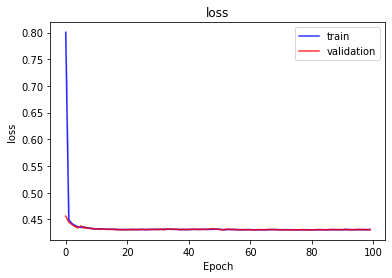

<b>bioma_loss</b>: 0.2147 (min: 0.2147, max: 0.2147)

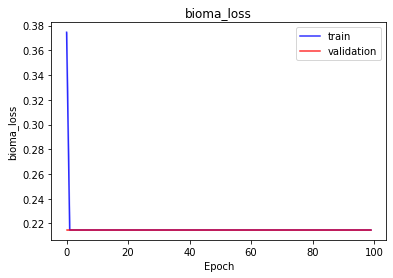

<b>domain_loss</b>: 0.2147 (min: 0.2147, max: 0.2147)

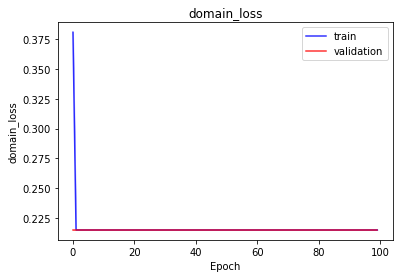

<b>latent_loss</b>: 0.0014 (min: 0.0014, max: 0.0014)

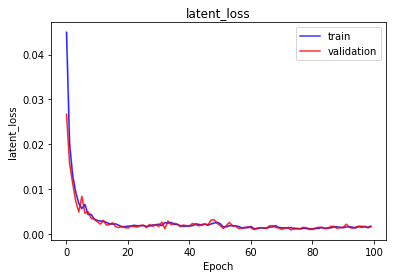

<b>bioma_mse</b>: 2787703552.0000 (min: 2787703552.0000, max: 2787703552.0000)

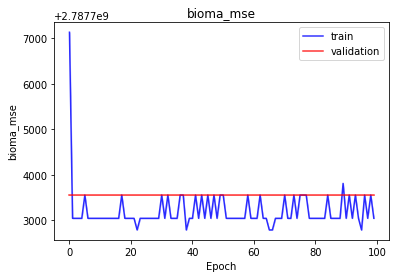

<b>bioma_mae</b>: 9028.4541 (min: 9028.4541, max: 9028.4541)

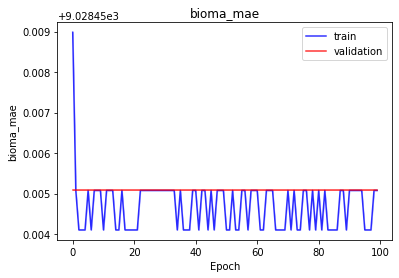

<b>bioma_mape</b>: 69.2240 (min: 69.2240, max: 69.2240)

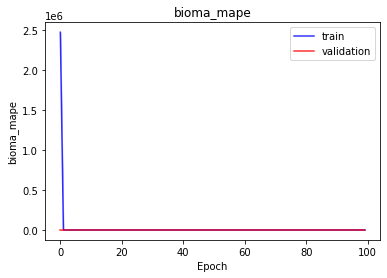

<b>bioma_BrayCurtis</b>: 0.2147 (min: 0.2147, max: 0.2147)

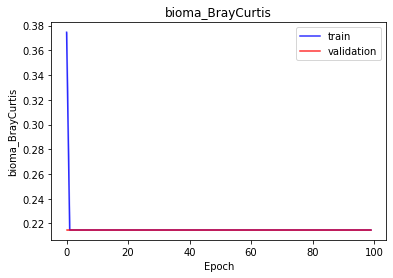

<b>bioma_pearson_corr</b>: 0.9540 (min: 0.9540, max: 0.9540)

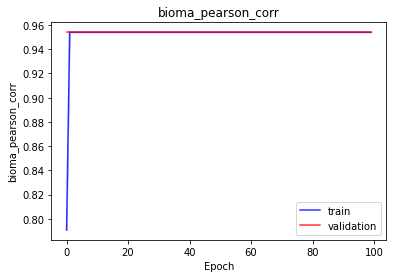

<b>bioma_jensen_shannon_divergence</b>: 6.1397 (min: 6.1397, max: 6.1397)

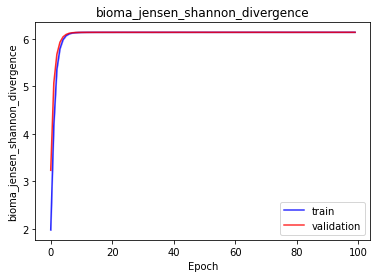

<b>domain_mse</b>: 2787703552.0000 (min: 2787703552.0000, max: 2787703552.0000)

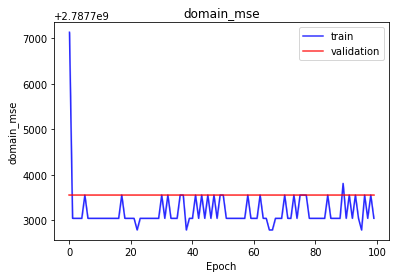

<b>domain_mae</b>: 9028.4541 (min: 9028.4541, max: 9028.4541)

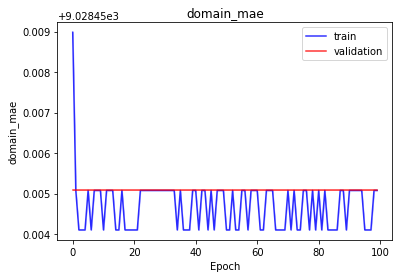

<b>domain_mape</b>: 69.2240 (min: 69.2240, max: 69.2240)

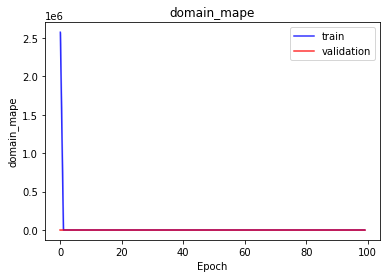

<b>domain_BrayCurtis</b>: 0.2147 (min: 0.2147, max: 0.2147)

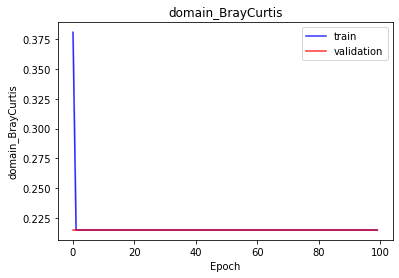

<b>domain_pearson_corr</b>: 0.9540 (min: 0.9540, max: 0.9540)

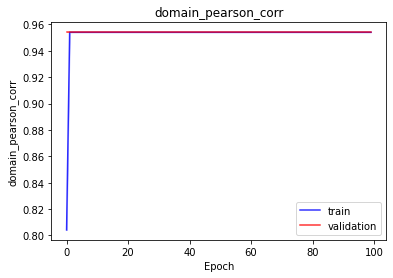

<b>domain_jensen_shannon_divergence</b>: 6.1396 (min: 6.1396, max: 6.1396)

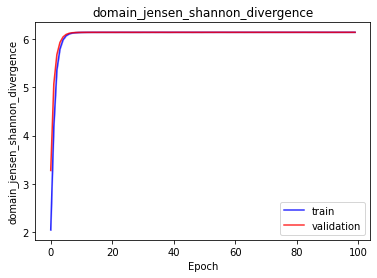

<b>latent_mae</b>: 0.0014 (min: 0.0014, max: 0.0014)

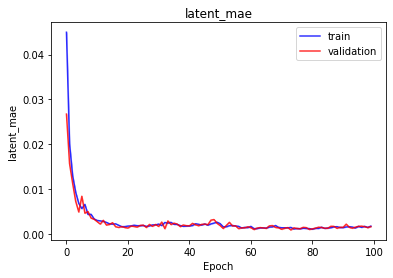

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 0.43087175488471985 | 0.43087175488471985 | 0.43087175488471985 |
| bioma_loss | 0.21473397314548492 | 0.21473397314548492 | 0.21473397314548492 |
| domain_loss | 0.21473397314548492 | 0.21473397314548492 | 0.21473397314548492 |
| latent_loss | 0.001403860398568213 | 0.001403860398568213 | 0.001403860398568213 |
| bioma_mse | 2787703552.0 | 2787703552.0 | 2787703552.0 |
| bioma_mae | 9028.4541015625 | 9028.4541015625 | 9028.4541015625 |
| bioma_mape | 69.22396087646484 | 69.22396087646484 | 69.22396087646484 |
| bioma_BrayCurtis | 0.21473397314548492 | 0.21473397314548492 | 0.21473397314548492 |
| bioma_pearson_corr | 0.9540330767631531 | 0.9540330767631531 | 0.9540330767631531 |
| bioma_jensen_shannon_divergence | 6.139659404754639 | 6.139659404754639 | 6.139659404754639 |
| domain_mse | 2787703552.0 | 2787703552.0 | 2787703552.0 |
| domain_mae | 9028.4541015625 | 9028.4541015625 | 9028.4541015625 |
| domain_mape | 69.22396087646484 | 69.22396087646484 | 69.22396087646484 |
| domain_BrayCurtis | 0.21473397314548492 | 0.21473397314548492 | 0.21473397314548492 |
| domain_pearson_corr | 0.9540330767631531 | 0.9540330767631531 | 0.9540330767631531 |
| domain_jensen_shannon_divergence | 6.139647006988525 | 6.139647006988525 | 6.139647006988525 |
| latent_mae | 0.001403860398568213 | 0.001403860398568213 | 0.001403860398568213 |


*************

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.21448466181755066 | 0.21448466181755066 | 0.21448466181755066 |
| pearson_corr | 0.9567595720291138 | 0.9567595720291138 | 0.9567595720291138 |
| jensen_shannon_divergence | 6.110311508178711 | 6.110311508178711 | 6.110311508178711 |


In [11]:
experiment_metrics, models, results = perform_experiment_2_mod(cv_folds=0,
                                                               epochs=100,
                                                               batch_size=64,
                                                               learning_rate=0.01,
                                                               optimizer=optimizers.Adam,
                                                               learning_rate_scheduler=None,
                                                               input_transform=Percentage,
                                                               output_transform=tf.keras.layers.Softmax,
                                                               reconstruction_loss=MakeLoss(LossBrayCurtis, Percentage, None),
                                                               latent_space=15,
                                                               layers=[512,256],
                                                               activation='tanh',
                                                               activation_latent='softmax',
                                                               data_microbioma_train=data_microbioma_train,
                                                               data_domain_train=data_domain_train,
                                                               show_results=True,
                                                               device='/CPU:0')
    
#Guardamos el modelo, encoder y decoder
model, encoder, _ ,decoder = models[0]
  
def model_fn_latent():
    in_layer = layers.Input(shape=(data_domain_train.shape[1],))
    net = layers.Dense(128, activation='sigmoid')(in_layer)
    net = layers.Dense(64, activation='sigmoid')(net)
    net = layers.Dense(32, activation='sigmoid')(net)
    net = layers.Dense(16, activation='sigmoid')(net)
    out_layer = layers.Dense(latent_train.shape[1], activation='softmax')(net)
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    model.compile(optimizer=optimizers.Adam(lr=0.01), loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.MeanSquaredError()])
    return model
    
#funcion del modelado -- por ahora lo dejaremos asi, y voy a habalr con ella par aver que cambio, que tuneo
latent_train = encoder.predict(data_microbioma_train)
    
result_latent, model_latent = train_tl_noEnsemble(model_fn_latent,
                                                  latent_train,
                                                  latent_train,
                                                  data_domain_train,
                                                  data_domain_train,
                                                  epochs=100,
                                                  batch_size=16,
                                                  verbose=-1)

#evaluamos el modelo
latent_test = encoder.predict(data_microbioma_test)
predictions = test_model_tl_noEnsemble(model_latent, decoder, Percentage, tf.keras.layers.Softmax, otu_columns, data_microbioma_test, data_domain_test)

In [12]:
encoder_biome = encoder
encoder_domain = model_latent
#Guardamos las predicciones
df_microbioma_test.T.to_csv('Results/otus_original_test_44Combined_orden.tsv', index=True, header=True, sep='\t')

#run prediction test set from microbiome, i.e, reconstructed
# Input only domain (i.e. environmental features)
pred_latent_biome = encoder_biome.predict(data_microbioma_test)
pred_biome = decoder.predict(pred_latent_biome)

_, _ = save_predicted_otu_table_and_latent(pred_biome,pred_latent_biome,df_microbioma_test.index,df_microbioma_test.columns,'reconstAEfromBiome_44Combined_orden')

#run prediction test set from domain, i.e., diet features
# Input only domain (i.e. environmental features)
pred_latent = encoder_domain.predict(data_domain_test)
pred_domain = decoder.predict(pred_latent)
df_pred_otu, df_pred_latent = save_predicted_otu_table_and_latent(pred_domain,pred_latent,df_microbioma_test.index,df_microbioma_test.columns,'predFromDomain_44Combined_orden')

#--------------------
actual_array = transform_to_rel_abundance(data_microbioma_test)
RSE_perOTU, RRSE_perOTU  = compute_relative_squared_error(actual_array,pred_domain)

df_error_perOTU = save_errors_per_OTU(RSE_perOTU,RRSE_perOTU,df_microbioma_test.columns,'Results/errors_perOTU_44Combined_orden')

In [ ]:
metrics = FI()
tabla_FI = pd.DataFrame.from_dict(metrics)
tabla_FI.to_csv("Results/nutrientes/FI/FI_Combined44_order.csv",index=False)

### Class

In [14]:
nombres_metadatos = ["KCAL","PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","SUGR","FIBE","CALC","IRON","MAGN","PHOS","POTA","SODI","ZINC","COPP","SELE","VC","VB1","VB2","NIAC","VB6","FOLA","VB12","VARA","RET","BCAR","ACAR","CRYP","LYCO","LZ","ATOC","VK","CHOLE","SFAT","MFAT","PFAT","VITD","CHOLN"]
#nombres_metadatos = ["PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","CALC","MAGN","POTA","ZINC","VC","VB1","VB6","VARA","ACAR","CRYP","LYCO","ATOC","VK","CHOLE","VITD"]
df_microbioma_train, df_microbioma_test, _, _, \
df_domain_train, df_domain_test, _, _, otu_columns, domain_columns = read_df(metadata_names=nombres_metadatos,otu_filename='resultados_ana/nuevos_datos/arreglados/otu_table_Class.csv',metadata_filename='resultados_ana/datos_otus_metadatos_clase/metadatos_nutrientes_clase.csv')

data_microbioma_train = df_microbioma_train.to_numpy(dtype=np.float32)
data_microbioma_test = df_microbioma_test.to_numpy(dtype=np.float32)
data_domain_train = df_domain_train.to_numpy(dtype=np.float32)
data_domain_test = df_domain_test.to_numpy(dtype=np.float32)

| Parameter             | Value         |
|:----------------------|:--------------|
| Input transform | Percentage |
| Output transform | Softmax |
| Reconstruction Loss | LossBrayCurtis |
| Latent Space | 15 |
| Bioma Autoencoder | b -> 512 -> 256 -> 15 -> 256 -> 512 -> b |
| Domain Autoencoder | d -> 32 -> 16 -> 15 -> 256 -> 512 -> b |
| Activation Encoder | tanh |
| Activation Decoder | tanh |
| Activation Latent | softmax |
| CV folds | 0 |
| Epochs | 100 |
| Batch Size | 64 |
| Learning Rate Scheduler | none |
| Learning Rate | constant = 0.01 |
| Optimizer | Adam |


<p>Best iteration: <b>83</b></p>

<b>loss</b>: 0.4308 (min: 0.4308, max: 0.4308)

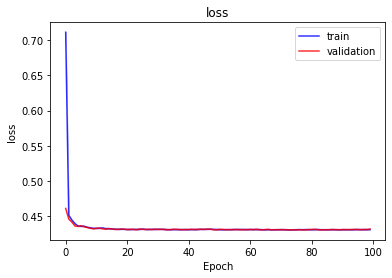

<b>bioma_loss</b>: 0.2148 (min: 0.2148, max: 0.2148)

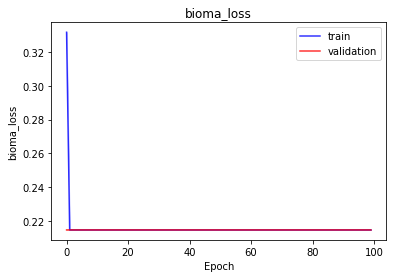

<b>domain_loss</b>: 0.2148 (min: 0.2148, max: 0.2148)

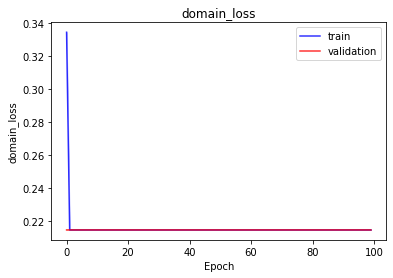

<b>latent_loss</b>: 0.0013 (min: 0.0013, max: 0.0013)

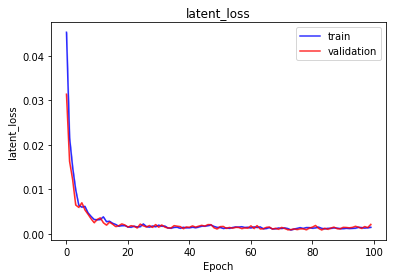

<b>bioma_mse</b>: 4695270912.0000 (min: 4695270912.0000, max: 4695270912.0000)

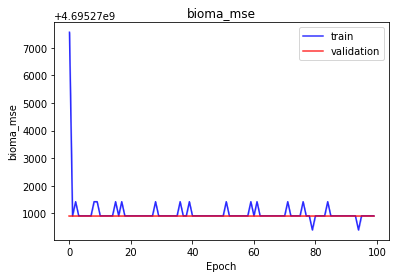

<b>bioma_mae</b>: 15206.2607 (min: 15206.2607, max: 15206.2607)

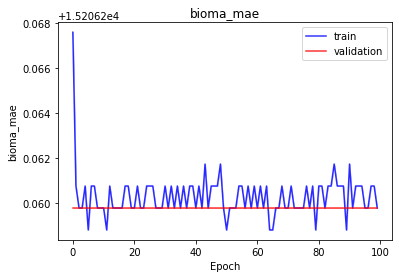

<b>bioma_mape</b>: 70.4339 (min: 70.4339, max: 70.4339)

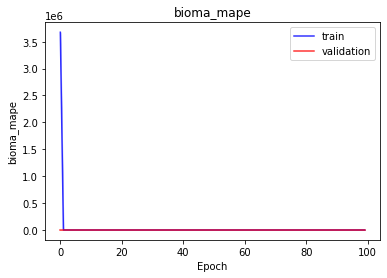

<b>bioma_BrayCurtis</b>: 0.2148 (min: 0.2148, max: 0.2148)

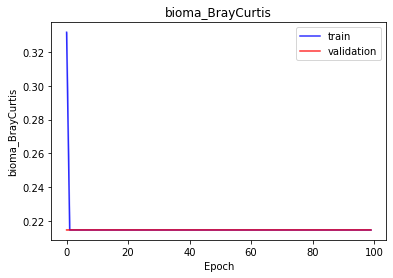

<b>bioma_pearson_corr</b>: 0.9532 (min: 0.9532, max: 0.9532)

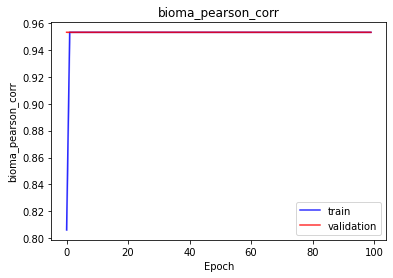

<b>bioma_jensen_shannon_divergence</b>: 4.6755 (min: 4.6755, max: 4.6755)

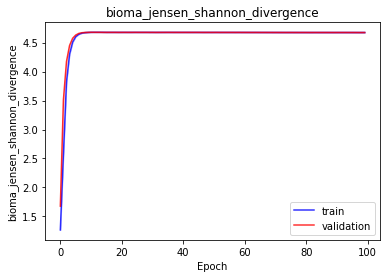

<b>domain_mse</b>: 4695270912.0000 (min: 4695270912.0000, max: 4695270912.0000)

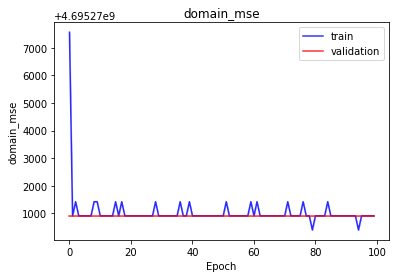

<b>domain_mae</b>: 15206.2607 (min: 15206.2607, max: 15206.2607)

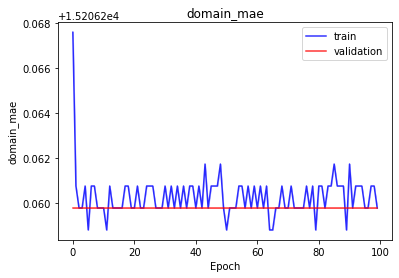

<b>domain_mape</b>: 70.4339 (min: 70.4339, max: 70.4339)

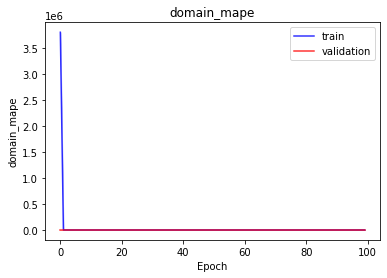

<b>domain_BrayCurtis</b>: 0.2148 (min: 0.2148, max: 0.2148)

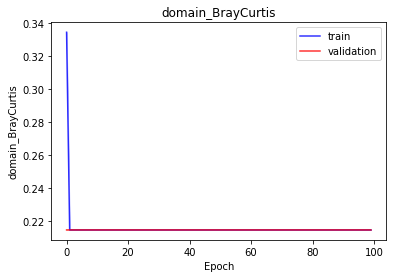

<b>domain_pearson_corr</b>: 0.9532 (min: 0.9532, max: 0.9532)

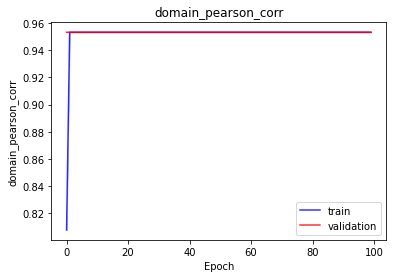

<b>domain_jensen_shannon_divergence</b>: 4.6755 (min: 4.6755, max: 4.6755)

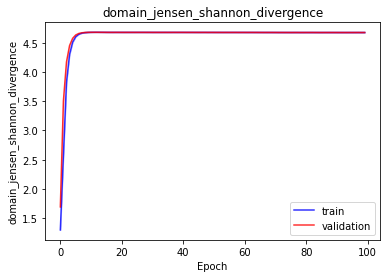

<b>latent_mae</b>: 0.0013 (min: 0.0013, max: 0.0013)

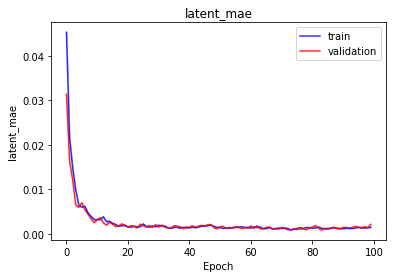

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 0.4307529330253601 | 0.4307529330253601 | 0.4307529330253601 |
| bioma_loss | 0.21475055813789368 | 0.21475055813789368 | 0.21475055813789368 |
| domain_loss | 0.21475055813789368 | 0.21475055813789368 | 0.21475055813789368 |
| latent_loss | 0.0012518330477178097 | 0.0012518330477178097 | 0.0012518330477178097 |
| bioma_mse | 4695270912.0 | 4695270912.0 | 4695270912.0 |
| bioma_mae | 15206.2607421875 | 15206.2607421875 | 15206.2607421875 |
| bioma_mape | 70.43386840820312 | 70.43386840820312 | 70.43386840820312 |
| bioma_BrayCurtis | 0.21475055813789368 | 0.21475055813789368 | 0.21475055813789368 |
| bioma_pearson_corr | 0.9532352089881897 | 0.9532352089881897 | 0.9532352089881897 |
| bioma_jensen_shannon_divergence | 4.675484657287598 | 4.675484657287598 | 4.675484657287598 |
| domain_mse | 4695270912.0 | 4695270912.0 | 4695270912.0 |
| domain_mae | 15206.2607421875 | 15206.2607421875 | 15206.2607421875 |
| domain_mape | 70.43386840820312 | 70.43386840820312 | 70.43386840820312 |
| domain_BrayCurtis | 0.21475055813789368 | 0.21475055813789368 | 0.21475055813789368 |
| domain_pearson_corr | 0.9532352089881897 | 0.9532352089881897 | 0.9532352089881897 |
| domain_jensen_shannon_divergence | 4.675510883331299 | 4.675510883331299 | 4.675510883331299 |
| latent_mae | 0.0012518330477178097 | 0.0012518330477178097 | 0.0012518330477178097 |


*************

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.2145024985074997 | 0.2145024985074997 | 0.2145024985074997 |
| pearson_corr | 0.9561855792999268 | 0.9561855792999268 | 0.9561855792999268 |
| jensen_shannon_divergence | 4.645987510681152 | 4.645987510681152 | 4.645987510681152 |


In [15]:
experiment_metrics, models, results = perform_experiment_2_mod(cv_folds=0,
                                                               epochs=100,
                                                               batch_size=64,
                                                               learning_rate=0.01,
                                                               optimizer=optimizers.Adam,
                                                               learning_rate_scheduler=None,
                                                               input_transform=Percentage,
                                                               output_transform=tf.keras.layers.Softmax,
                                                               reconstruction_loss=MakeLoss(LossBrayCurtis, Percentage, None),
                                                               latent_space=15,
                                                               layers=[512,256],
                                                               activation='tanh',
                                                               activation_latent='softmax',
                                                               data_microbioma_train=data_microbioma_train,
                                                               data_domain_train=data_domain_train,
                                                               show_results=True,
                                                               device='/CPU:0')
    
#Guardamos el modelo, encoder y decoder
model, encoder, _ ,decoder = models[0]
  
def model_fn_latent():
    in_layer = layers.Input(shape=(data_domain_train.shape[1],))
    net = layers.Dense(128, activation='sigmoid')(in_layer)
    net = layers.Dense(64, activation='sigmoid')(net)
    net = layers.Dense(32, activation='sigmoid')(net)
    net = layers.Dense(16, activation='sigmoid')(net)
    out_layer = layers.Dense(latent_train.shape[1], activation='softmax')(net)
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    model.compile(optimizer=optimizers.Adam(lr=0.01), loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.MeanSquaredError()])
    return model
    
#funcion del modelado -- por ahora lo dejaremos asi, y voy a habalr con ella par aver que cambio, que tuneo
latent_train = encoder.predict(data_microbioma_train)
    
result_latent, model_latent = train_tl_noEnsemble(model_fn_latent,
                                                  latent_train,
                                                  latent_train,
                                                  data_domain_train,
                                                  data_domain_train,
                                                  epochs=100,
                                                  batch_size=16,
                                                  verbose=-1)

#evaluamos el modelo
latent_test = encoder.predict(data_microbioma_test)
predictions = test_model_tl_noEnsemble(model_latent, decoder, Percentage, tf.keras.layers.Softmax, otu_columns, data_microbioma_test, data_domain_test)

In [16]:
encoder_biome = encoder
encoder_domain = model_latent
#Guardamos las predicciones
df_microbioma_test.T.to_csv('Results/otus_original_test_44Combined_clase.tsv', index=True, header=True, sep='\t')

#run prediction test set from microbiome, i.e, reconstructed
# Input only domain (i.e. environmental features)
pred_latent_biome = encoder_biome.predict(data_microbioma_test)
pred_biome = decoder.predict(pred_latent_biome)

_, _ = save_predicted_otu_table_and_latent(pred_biome,pred_latent_biome,df_microbioma_test.index,df_microbioma_test.columns,'reconstAEfromBiome_44Combined_clase')

#run prediction test set from domain, i.e., diet features
# Input only domain (i.e. environmental features)
pred_latent = encoder_domain.predict(data_domain_test)
pred_domain = decoder.predict(pred_latent)
df_pred_otu, df_pred_latent = save_predicted_otu_table_and_latent(pred_domain,pred_latent,df_microbioma_test.index,df_microbioma_test.columns,'predFromDomain_44Combined_clase')

#--------------------
actual_array = transform_to_rel_abundance(data_microbioma_test)
RSE_perOTU, RRSE_perOTU  = compute_relative_squared_error(actual_array,pred_domain)

df_error_perOTU = save_errors_per_OTU(RSE_perOTU,RRSE_perOTU,df_microbioma_test.columns,'Results/errors_perOTU_44Combined_clase')

In [ ]:
metrics = FI()
tabla_FI = pd.DataFrame.from_dict(metrics)
tabla_FI.to_csv("Results/nutrientes/FI/FI_Combined44_clase.csv",index=False)

### Phylum

In [17]:
nombres_metadatos = ["KCAL","PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","SUGR","FIBE","CALC","IRON","MAGN","PHOS","POTA","SODI","ZINC","COPP","SELE","VC","VB1","VB2","NIAC","VB6","FOLA","VB12","VARA","RET","BCAR","ACAR","CRYP","LYCO","LZ","ATOC","VK","CHOLE","SFAT","MFAT","PFAT","VITD","CHOLN"]
#nombres_metadatos = ["PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","CALC","MAGN","POTA","ZINC","VC","VB1","VB6","VARA","ACAR","CRYP","LYCO","ATOC","VK","CHOLE","VITD"]
df_microbioma_train, df_microbioma_test, _, _, \
df_domain_train, df_domain_test, _, _, otu_columns, domain_columns = read_df(metadata_names=nombres_metadatos,otu_filename='resultados_ana/nuevos_datos/arreglados/otu_table_Phylum.csv',metadata_filename='resultados_ana/datos_otus_metadatos_filo/metadatos_nutrientes_filo.csv')

data_microbioma_train = df_microbioma_train.to_numpy(dtype=np.float32)
data_microbioma_test = df_microbioma_test.to_numpy(dtype=np.float32)
data_domain_train = df_domain_train.to_numpy(dtype=np.float32)
data_domain_test = df_domain_test.to_numpy(dtype=np.float32)

| Parameter             | Value         |
|:----------------------|:--------------|
| Input transform | Percentage |
| Output transform | Softmax |
| Reconstruction Loss | LossBrayCurtis |
| Latent Space | 15 |
| Bioma Autoencoder | b -> 512 -> 256 -> 15 -> 256 -> 512 -> b |
| Domain Autoencoder | d -> 32 -> 16 -> 15 -> 256 -> 512 -> b |
| Activation Encoder | tanh |
| Activation Decoder | tanh |
| Activation Latent | softmax |
| CV folds | 0 |
| Epochs | 100 |
| Batch Size | 64 |
| Learning Rate Scheduler | none |
| Learning Rate | constant = 0.01 |
| Optimizer | Adam |


<p>Best iteration: <b>72</b></p>

<b>loss</b>: 0.4344 (min: 0.4344, max: 0.4344)

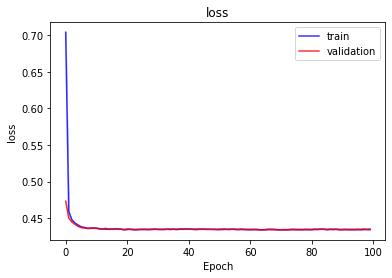

<b>bioma_loss</b>: 0.2165 (min: 0.2165, max: 0.2165)

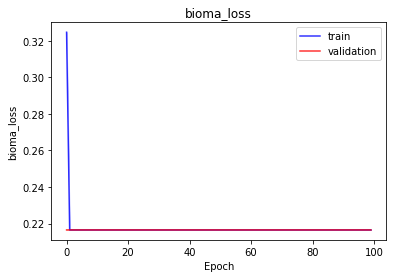

<b>domain_loss</b>: 0.2165 (min: 0.2165, max: 0.2165)

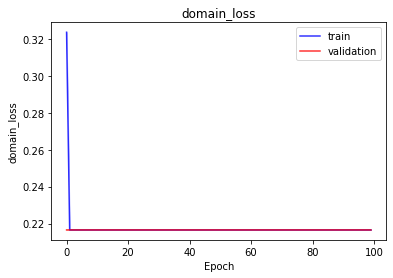

<b>latent_loss</b>: 0.0014 (min: 0.0014, max: 0.0014)

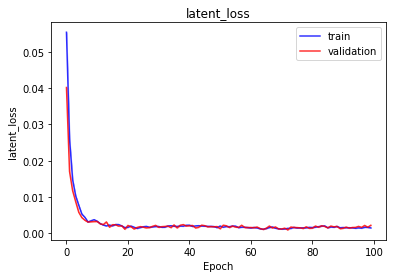

<b>bioma_mse</b>: 9952972800.0000 (min: 9952972800.0000, max: 9952972800.0000)

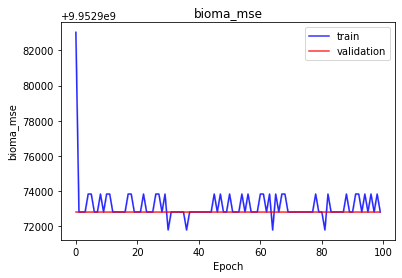

<b>bioma_mae</b>: 32181.6914 (min: 32181.6914, max: 32181.6914)

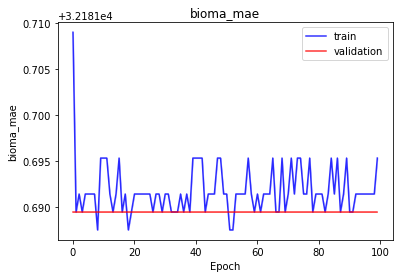

<b>bioma_mape</b>: 64.9093 (min: 64.9093, max: 64.9093)

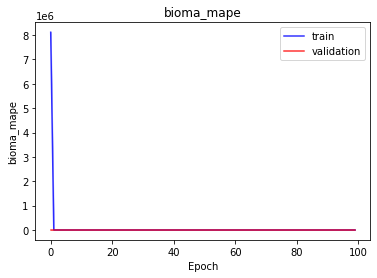

<b>bioma_BrayCurtis</b>: 0.2165 (min: 0.2165, max: 0.2165)

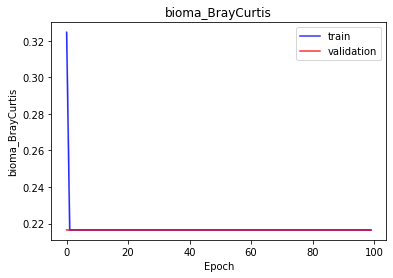

<b>bioma_pearson_corr</b>: 0.9480 (min: 0.9480, max: 0.9480)

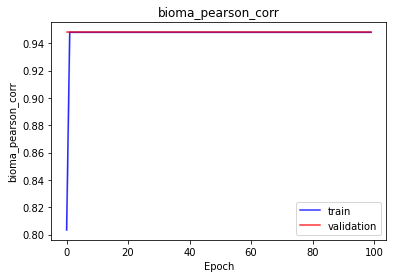

<b>bioma_jensen_shannon_divergence</b>: 3.2205 (min: 3.2205, max: 3.2205)

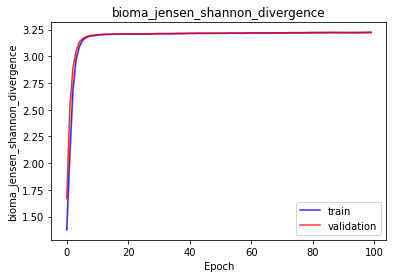

<b>domain_mse</b>: 9952972800.0000 (min: 9952972800.0000, max: 9952972800.0000)

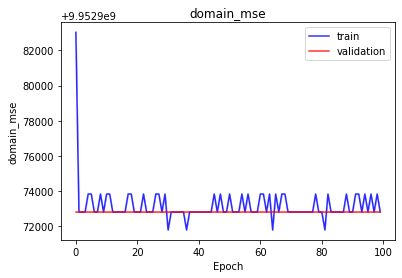

<b>domain_mae</b>: 32181.6914 (min: 32181.6914, max: 32181.6914)

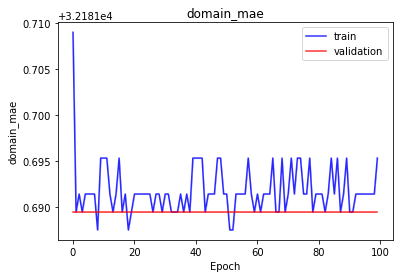

<b>domain_mape</b>: 64.9093 (min: 64.9093, max: 64.9093)

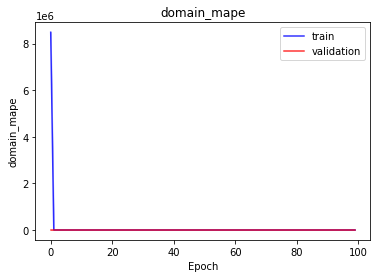

<b>domain_BrayCurtis</b>: 0.2165 (min: 0.2165, max: 0.2165)

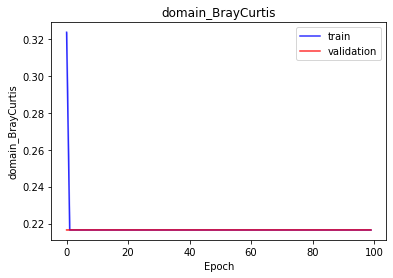

<b>domain_pearson_corr</b>: 0.9480 (min: 0.9480, max: 0.9480)

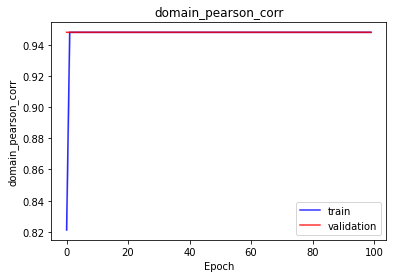

<b>domain_jensen_shannon_divergence</b>: 3.2205 (min: 3.2205, max: 3.2205)

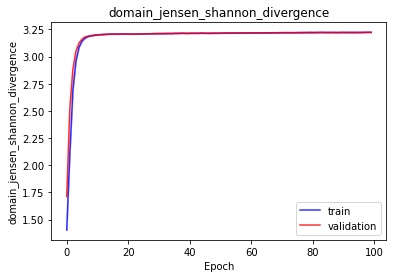

<b>latent_mae</b>: 0.0014 (min: 0.0014, max: 0.0014)

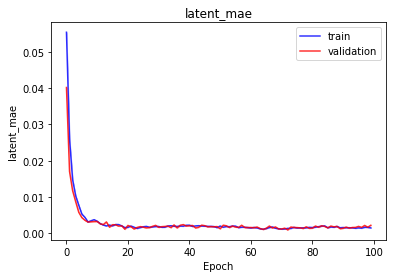

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 0.4344242215156555 | 0.4344242215156555 | 0.4344242215156555 |
| bioma_loss | 0.21653339266777039 | 0.21653339266777039 | 0.21653339266777039 |
| domain_loss | 0.21653339266777039 | 0.21653339266777039 | 0.21653339266777039 |
| latent_loss | 0.0013574687764048576 | 0.0013574687764048576 | 0.0013574687764048576 |
| bioma_mse | 9952972800.0 | 9952972800.0 | 9952972800.0 |
| bioma_mae | 32181.69140625 | 32181.69140625 | 32181.69140625 |
| bioma_mape | 64.9093017578125 | 64.9093017578125 | 64.9093017578125 |
| bioma_BrayCurtis | 0.21653339266777039 | 0.21653339266777039 | 0.21653339266777039 |
| bioma_pearson_corr | 0.9480212330818176 | 0.9480212330818176 | 0.9480212330818176 |
| bioma_jensen_shannon_divergence | 3.2204830646514893 | 3.2204830646514893 | 3.2204830646514893 |
| domain_mse | 9952972800.0 | 9952972800.0 | 9952972800.0 |
| domain_mae | 32181.69140625 | 32181.69140625 | 32181.69140625 |
| domain_mape | 64.9093017578125 | 64.9093017578125 | 64.9093017578125 |
| domain_BrayCurtis | 0.21653339266777039 | 0.21653339266777039 | 0.21653339266777039 |
| domain_pearson_corr | 0.9480212330818176 | 0.9480212330818176 | 0.9480212330818176 |
| domain_jensen_shannon_divergence | 3.220486879348755 | 3.220486879348755 | 3.220486879348755 |
| latent_mae | 0.0013574687764048576 | 0.0013574687764048576 | 0.0013574687764048576 |


*************

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.21605812013149261 | 0.21605812013149261 | 0.21605812013149261 |
| pearson_corr | 0.9518275856971741 | 0.9518275856971741 | 0.9518275856971741 |
| jensen_shannon_divergence | 3.169302225112915 | 3.169302225112915 | 3.169302225112915 |


In [18]:
experiment_metrics, models, results = perform_experiment_2_mod(cv_folds=0,
                                                               epochs=100,
                                                               batch_size=64,
                                                               learning_rate=0.01,
                                                               optimizer=optimizers.Adam,
                                                               learning_rate_scheduler=None,
                                                               input_transform=Percentage,
                                                               output_transform=tf.keras.layers.Softmax,
                                                               reconstruction_loss=MakeLoss(LossBrayCurtis, Percentage, None),
                                                               latent_space=15,
                                                               layers=[512,256],
                                                               activation='tanh',
                                                               activation_latent='softmax',
                                                               data_microbioma_train=data_microbioma_train,
                                                               data_domain_train=data_domain_train,
                                                               show_results=True,
                                                               device='/CPU:0')
    
#Guardamos el modelo, encoder y decoder
model, encoder, _ ,decoder = models[0]
  
def model_fn_latent():
    in_layer = layers.Input(shape=(data_domain_train.shape[1],))
    net = layers.Dense(128, activation='sigmoid')(in_layer)
    net = layers.Dense(64, activation='sigmoid')(net)
    net = layers.Dense(32, activation='sigmoid')(net)
    net = layers.Dense(16, activation='sigmoid')(net)
    out_layer = layers.Dense(latent_train.shape[1], activation='softmax')(net)
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    model.compile(optimizer=optimizers.Adam(lr=0.01), loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.MeanSquaredError()])
    return model
    
#funcion del modelado -- por ahora lo dejaremos asi, y voy a habalr con ella par aver que cambio, que tuneo
latent_train = encoder.predict(data_microbioma_train)
    
result_latent, model_latent = train_tl_noEnsemble(model_fn_latent,
                                                  latent_train,
                                                  latent_train,
                                                  data_domain_train,
                                                  data_domain_train,
                                                  epochs=100,
                                                  batch_size=16,
                                                  verbose=-1)

#evaluamos el modelo
latent_test = encoder.predict(data_microbioma_test)
predictions = test_model_tl_noEnsemble(model_latent, decoder, Percentage, tf.keras.layers.Softmax, otu_columns, data_microbioma_test, data_domain_test)

In [19]:
encoder_biome = encoder
encoder_domain = model_latent
#Guardamos las predicciones
df_microbioma_test.T.to_csv('Results/otus_original_test_44Combined_filo.tsv', index=True, header=True, sep='\t')

#run prediction test set from microbiome, i.e, reconstructed
# Input only domain (i.e. environmental features)
pred_latent_biome = encoder_biome.predict(data_microbioma_test)
pred_biome = decoder.predict(pred_latent_biome)

_, _ = save_predicted_otu_table_and_latent(pred_biome,pred_latent_biome,df_microbioma_test.index,df_microbioma_test.columns,'reconstAEfromBiome_44Combined_filo')

#run prediction test set from domain, i.e., diet features
# Input only domain (i.e. environmental features)
pred_latent = encoder_domain.predict(data_domain_test)
pred_domain = decoder.predict(pred_latent)
df_pred_otu, df_pred_latent = save_predicted_otu_table_and_latent(pred_domain,pred_latent,df_microbioma_test.index,df_microbioma_test.columns,'predFromDomain_44Combined_filo')

#--------------------
actual_array = transform_to_rel_abundance(data_microbioma_test)
RSE_perOTU, RRSE_perOTU  = compute_relative_squared_error(actual_array,pred_domain)

df_error_perOTU = save_errors_per_OTU(RSE_perOTU,RRSE_perOTU,df_microbioma_test.columns,'Results/errors_perOTU_44Combined_filo')

In [ ]:
metrics = FI()
tabla_FI = pd.DataFrame.from_dict(metrics)
tabla_FI.to_csv("Results/nutrientes/FI/FI_Combined44_filo.csv",index=False)

--------------------------
# 44 variables Latent OTU

### Genus

In [20]:
nombres_metadatos = ["KCAL","PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","SUGR","FIBE","CALC","IRON","MAGN","PHOS","POTA","SODI","ZINC","COPP","SELE","VC","VB1","VB2","NIAC","VB6","FOLA","VB12","VARA","RET","BCAR","ACAR","CRYP","LYCO","LZ","ATOC","VK","CHOLE","SFAT","MFAT","PFAT","VITD","CHOLN"]
#nombres_metadatos = ["PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","CALC","MAGN","POTA","ZINC","VC","VB1","VB6","VARA","ACAR","CRYP","LYCO","ATOC","VK","CHOLE","VITD"]
df_microbioma_train, df_microbioma_test, _, _, \
df_domain_train, df_domain_test, _, _, otu_columns, domain_columns = read_df(metadata_names=nombres_metadatos,otu_filename='resultados_ana/nuevos_datos/arreglados/otu_table_Genus.csv',metadata_filename='resultados_ana/datos_otus_metadatos_genero/metadatos_nutrientes_genero.csv')

data_microbioma_train = df_microbioma_train.to_numpy(dtype=np.float32)
data_microbioma_test = df_microbioma_test.to_numpy(dtype=np.float32)
data_domain_train = df_domain_train.to_numpy(dtype=np.float32)
data_domain_test = df_domain_test.to_numpy(dtype=np.float32)

| Parameter             | Value         |
|:----------------------|:--------------|
| Input transform | Percentage |
| Output transform | Softmax |
| Reconstruction Loss | LossBrayCurtis |
| Latent Space | 15 |
| Bioma Autoencoder | b -> 512 -> 256 -> 15 -> 256 -> 512 -> b |
| Domain Autoencoder |   |
| Activation Encoder | tanh |
| Activation Decoder | tanh |
| Activation Latent | tanh |
| CV folds | 0 |
| Epochs | 100 |
| Batch Size | 96 |
| Learning Rate Scheduler | none |
| Learning Rate | constant = 0.001 |
| Optimizer | Adam |


<p>Best iteration: <b>92</b></p>

<b>loss</b>: 0.0763 (min: 0.0763, max: 0.0763)

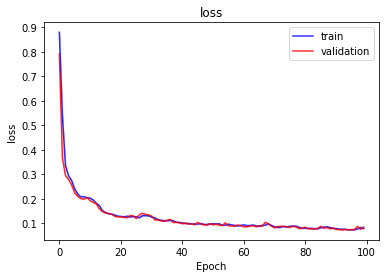

<b>bioma_mse</b>: 303918016.0000 (min: 303918016.0000, max: 303918016.0000)

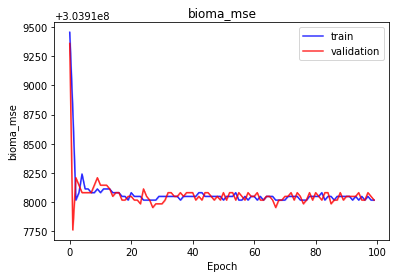

<b>bioma_mae</b>: 1614.6122 (min: 1614.6122, max: 1614.6122)

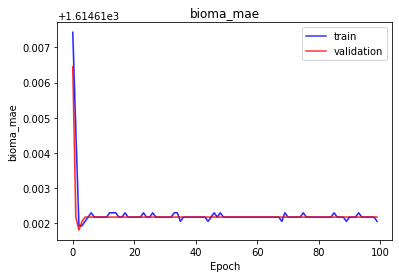

<b>bioma_mape</b>: 15420.7539 (min: 15420.7539, max: 15420.7539)

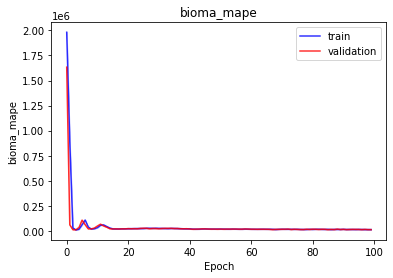

<b>bioma_BrayCurtis</b>: 0.0763 (min: 0.0763, max: 0.0763)

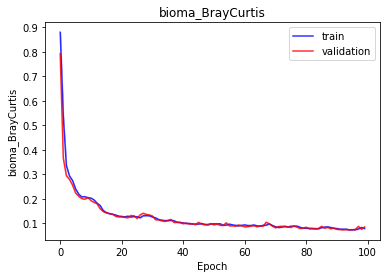

<b>bioma_pearson_corr</b>: 0.9960 (min: 0.9960, max: 0.9960)

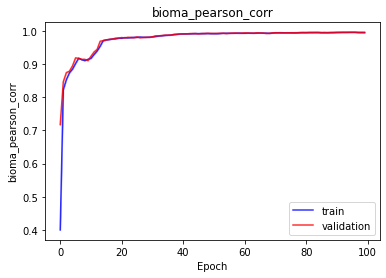

<b>bioma_jensen_shannon_divergence</b>: 0.1265 (min: 0.1265, max: 0.1265)

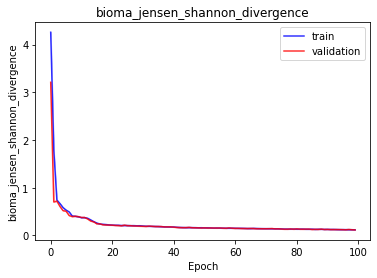

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 0.07629186660051346 | 0.07629186660051346 | 0.07629186660051346 |
| bioma_mse | 303918016.0 | 303918016.0 | 303918016.0 |
| bioma_mae | 1614.6121826171875 | 1614.6121826171875 | 1614.6121826171875 |
| bioma_mape | 15420.75390625 | 15420.75390625 | 15420.75390625 |
| bioma_BrayCurtis | 0.07629186660051346 | 0.07629186660051346 | 0.07629186660051346 |
| bioma_pearson_corr | 0.9960418939590454 | 0.9960418939590454 | 0.9960418939590454 |
| bioma_jensen_shannon_divergence | 0.12647759914398193 | 0.12647759914398193 | 0.12647759914398193 |


*************

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.2995743453502655 | 0.2995743453502655 | 0.2995743453502655 |
| pearson_corr | 0.8621789813041687 | 0.8621789813041687 | 0.8621789813041687 |
| jensen_shannon_divergence | 0.514252781867981 | 0.514252781867981 | 0.514252781867981 |


In [21]:
experiment_metrics, models, results = perform_experiment_2_mod(cv_folds=0,
                                                               epochs=100,
                                                               batch_size=96,
                                                               learning_rate=0.001,
                                                               optimizer=optimizers.Adam,
                                                               learning_rate_scheduler=None,
                                                               input_transform=Percentage,
                                                               output_transform=tf.keras.layers.Softmax,
                                                               reconstruction_loss=MakeLoss(LossBrayCurtis, Percentage, None),
                                                               latent_space=15,
                                                               layers=[512,256],
                                                               activation='tanh',
                                                               activation_latent='tanh',
                                                               data_microbioma_train=data_microbioma_train,
                                                               data_domain_train=None,
                                                               show_results=True,
                                                               device='/CPU:0')
    
#Guardamos el modelo, encoder y decoder
model, encoder, _ ,decoder = models[0]
  
def model_fn_latent():
    in_layer = layers.Input(shape=(data_domain_train.shape[1],))
    net = layers.Dense(128, activation='softmax')(in_layer)
    net = layers.Dense(64, activation='softmax')(net)
    net = layers.Dense(32, activation='softmax')(net)
    net = layers.Dense(16, activation='softmax')(net)
    out_layer = layers.Dense(latent_train.shape[1], activation='tanh')(net)
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    model.compile(optimizer=optimizers.Adam(lr=0.01), loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.MeanSquaredError()])
    return model
    
#funcion del modelado -- por ahora lo dejaremos asi, y voy a habalr con ella par aver que cambio, que tuneo
latent_train = encoder.predict(data_microbioma_train)
    
result_latent, model_latent = train_tl_noEnsemble(model_fn_latent,
                                                  latent_train,
                                                  latent_train,
                                                  data_domain_train,
                                                  data_domain_train,
                                                  epochs=100,
                                                  batch_size=16,
                                                  verbose=-1)

#evaluamos el modelo
latent_test = encoder.predict(data_microbioma_test)
predictions = test_model_tl_noEnsemble(model_latent, decoder, Percentage, tf.keras.layers.Softmax, otu_columns, data_microbioma_test, data_domain_test)

In [22]:
encoder_biome = encoder
encoder_domain = model_latent
#Guardamos las predicciones
df_microbioma_test.T.to_csv('Results/otus_original_test_44OTU_genero.tsv', index=True, header=True, sep='\t')

#run prediction test set from microbiome, i.e, reconstructed
# Input only domain (i.e. environmental features)
pred_latent_biome = encoder_biome.predict(data_microbioma_test)
pred_biome = decoder.predict(pred_latent_biome)

_, _ = save_predicted_otu_table_and_latent(pred_biome,pred_latent_biome,df_microbioma_test.index,df_microbioma_test.columns,'reconstAEfromBiome_44OTU_genero')

#run prediction test set from domain, i.e., diet features
# Input only domain (i.e. environmental features)
pred_latent = encoder_domain.predict(data_domain_test)
pred_domain = decoder.predict(pred_latent)
df_pred_otu, df_pred_latent = save_predicted_otu_table_and_latent(pred_domain,pred_latent,df_microbioma_test.index,df_microbioma_test.columns,'predFromDomain_44OTU_genero')

#--------------------
actual_array = transform_to_rel_abundance(data_microbioma_test)
RSE_perOTU, RRSE_perOTU  = compute_relative_squared_error(actual_array,pred_domain)

df_error_perOTU = save_errors_per_OTU(RSE_perOTU,RRSE_perOTU,df_microbioma_test.columns,'Results/errors_perOTU_44OTU_genero')

In [ ]:
metrics = FI()
tabla_FI = pd.DataFrame.from_dict(metrics)
tabla_FI.to_csv("Results/nutrientes/FI/FI_OTU44_genus.csv",index=False)

### Family

In [23]:
nombres_metadatos = ["KCAL","PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","SUGR","FIBE","CALC","IRON","MAGN","PHOS","POTA","SODI","ZINC","COPP","SELE","VC","VB1","VB2","NIAC","VB6","FOLA","VB12","VARA","RET","BCAR","ACAR","CRYP","LYCO","LZ","ATOC","VK","CHOLE","SFAT","MFAT","PFAT","VITD","CHOLN"]
#nombres_metadatos = ["PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","CALC","MAGN","POTA","ZINC","VC","VB1","VB6","VARA","ACAR","CRYP","LYCO","ATOC","VK","CHOLE","VITD"]
df_microbioma_train, df_microbioma_test, _, _, \
df_domain_train, df_domain_test, _, _, otu_columns, domain_columns = read_df(metadata_names=nombres_metadatos,otu_filename='resultados_ana/nuevos_datos/arreglados/otu_table_Family.csv',metadata_filename='resultados_ana/datos_otus_metadatos_familia/metadatos_nutrientes_familia.csv')

data_microbioma_train = df_microbioma_train.to_numpy(dtype=np.float32)
data_microbioma_test = df_microbioma_test.to_numpy(dtype=np.float32)
data_domain_train = df_domain_train.to_numpy(dtype=np.float32)
data_domain_test = df_domain_test.to_numpy(dtype=np.float32)

| Parameter             | Value         |
|:----------------------|:--------------|
| Input transform | Percentage |
| Output transform | Softmax |
| Reconstruction Loss | LossBrayCurtis |
| Latent Space | 15 |
| Bioma Autoencoder | b -> 512 -> 256 -> 15 -> 256 -> 512 -> b |
| Domain Autoencoder |   |
| Activation Encoder | tanh |
| Activation Decoder | tanh |
| Activation Latent | tanh |
| CV folds | 0 |
| Epochs | 100 |
| Batch Size | 96 |
| Learning Rate Scheduler | none |
| Learning Rate | constant = 0.001 |
| Optimizer | Adam |


<p>Best iteration: <b>91</b></p>

<b>loss</b>: 0.0583 (min: 0.0583, max: 0.0583)

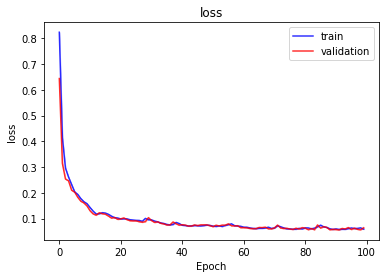

<b>bioma_mse</b>: 878693696.0000 (min: 878693696.0000, max: 878693696.0000)

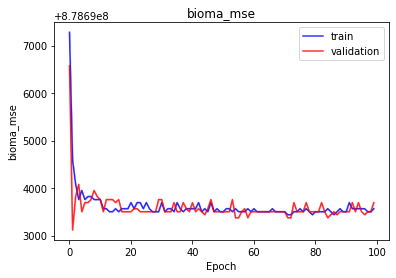

<b>bioma_mae</b>: 4677.9312 (min: 4677.9312, max: 4677.9312)

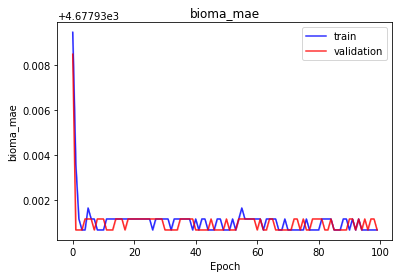

<b>bioma_mape</b>: 17845.1309 (min: 17845.1309, max: 17845.1309)

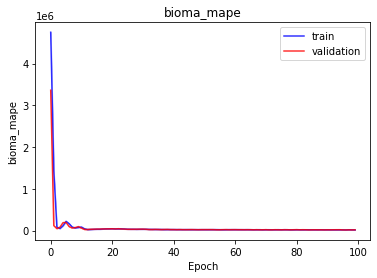

<b>bioma_BrayCurtis</b>: 0.0583 (min: 0.0583, max: 0.0583)

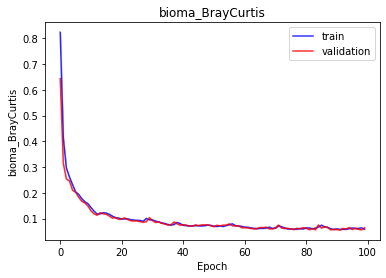

<b>bioma_pearson_corr</b>: 0.9964 (min: 0.9964, max: 0.9964)

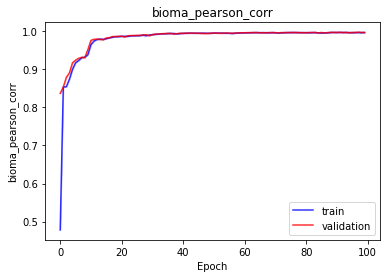

<b>bioma_jensen_shannon_divergence</b>: 0.0726 (min: 0.0726, max: 0.0726)

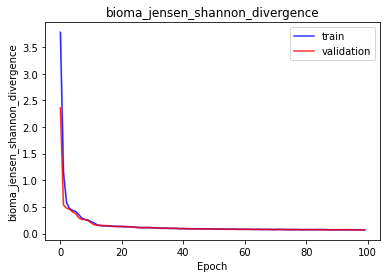

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 0.05834934860467911 | 0.05834934860467911 | 0.05834934860467911 |
| bioma_mse | 878693696.0 | 878693696.0 | 878693696.0 |
| bioma_mae | 4677.93115234375 | 4677.93115234375 | 4677.93115234375 |
| bioma_mape | 17845.130859375 | 17845.130859375 | 17845.130859375 |
| bioma_BrayCurtis | 0.05834934860467911 | 0.05834934860467911 | 0.05834934860467911 |
| bioma_pearson_corr | 0.9964309334754944 | 0.9964309334754944 | 0.9964309334754944 |
| bioma_jensen_shannon_divergence | 0.07262888550758362 | 0.07262888550758362 | 0.07262888550758362 |


*************

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.2720056176185608 | 0.2720056176185608 | 0.2720056176185608 |
| pearson_corr | 0.8715509176254272 | 0.8715509176254272 | 0.8715509176254272 |
| jensen_shannon_divergence | 0.4211170971393585 | 0.4211170971393585 | 0.4211170971393585 |


In [24]:
experiment_metrics, models, results = perform_experiment_2_mod(cv_folds=0,
                                                               epochs=100,
                                                               batch_size=96,
                                                               learning_rate=0.001,
                                                               optimizer=optimizers.Adam,
                                                               learning_rate_scheduler=None,
                                                               input_transform=Percentage,
                                                               output_transform=tf.keras.layers.Softmax,
                                                               reconstruction_loss=MakeLoss(LossBrayCurtis, Percentage, None),
                                                               latent_space=15,
                                                               layers=[512,256],
                                                               activation='tanh',
                                                               activation_latent='tanh',
                                                               data_microbioma_train=data_microbioma_train,
                                                               data_domain_train=None,
                                                               show_results=True,
                                                               device='/CPU:0')
    
#Guardamos el modelo, encoder y decoder
model, encoder, _ ,decoder = models[0]
  
def model_fn_latent():
    in_layer = layers.Input(shape=(data_domain_train.shape[1],))
    net = layers.Dense(128, activation='softmax')(in_layer)
    net = layers.Dense(64, activation='softmax')(net)
    net = layers.Dense(32, activation='softmax')(net)
    net = layers.Dense(16, activation='softmax')(net)
    out_layer = layers.Dense(latent_train.shape[1], activation='tanh')(net)
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    model.compile(optimizer=optimizers.Adam(lr=0.01), loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.MeanSquaredError()])
    return model
    
#funcion del modelado -- por ahora lo dejaremos asi, y voy a habalr con ella par aver que cambio, que tuneo
latent_train = encoder.predict(data_microbioma_train)
    
result_latent, model_latent = train_tl_noEnsemble(model_fn_latent,
                                                  latent_train,
                                                  latent_train,
                                                  data_domain_train,
                                                  data_domain_train,
                                                  epochs=100,
                                                  batch_size=16,
                                                  verbose=-1)

#evaluamos el modelo
latent_test = encoder.predict(data_microbioma_test)
predictions = test_model_tl_noEnsemble(model_latent, decoder, Percentage, tf.keras.layers.Softmax, otu_columns, data_microbioma_test, data_domain_test)

In [25]:
encoder_biome = encoder
encoder_domain = model_latent
#Guardamos las predicciones
df_microbioma_test.T.to_csv('Results/otus_original_test_44OTU_familia.tsv', index=True, header=True, sep='\t')

#run prediction test set from microbiome, i.e, reconstructed
# Input only domain (i.e. environmental features)
pred_latent_biome = encoder_biome.predict(data_microbioma_test)
pred_biome = decoder.predict(pred_latent_biome)

_, _ = save_predicted_otu_table_and_latent(pred_biome,pred_latent_biome,df_microbioma_test.index,df_microbioma_test.columns,'reconstAEfromBiome_44OTU_familia')

#run prediction test set from domain, i.e., diet features
# Input only domain (i.e. environmental features)
pred_latent = encoder_domain.predict(data_domain_test)
pred_domain = decoder.predict(pred_latent)
df_pred_otu, df_pred_latent = save_predicted_otu_table_and_latent(pred_domain,pred_latent,df_microbioma_test.index,df_microbioma_test.columns,'predFromDomain_44OTU_familia')

#--------------------
actual_array = transform_to_rel_abundance(data_microbioma_test)
RSE_perOTU, RRSE_perOTU  = compute_relative_squared_error(actual_array,pred_domain)

df_error_perOTU = save_errors_per_OTU(RSE_perOTU,RRSE_perOTU,df_microbioma_test.columns,'Results/errors_perOTU_44OTU_familia')

In [ ]:
metrics = FI()
tabla_FI = pd.DataFrame.from_dict(metrics)
tabla_FI.to_csv("Results/nutrientes/FI/FI_OTU44_family.csv",index=False)

### Order

In [26]:
nombres_metadatos = ["KCAL","PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","SUGR","FIBE","CALC","IRON","MAGN","PHOS","POTA","SODI","ZINC","COPP","SELE","VC","VB1","VB2","NIAC","VB6","FOLA","VB12","VARA","RET","BCAR","ACAR","CRYP","LYCO","LZ","ATOC","VK","CHOLE","SFAT","MFAT","PFAT","VITD","CHOLN"]
#nombres_metadatos = ["PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","CALC","MAGN","POTA","ZINC","VC","VB1","VB6","VARA","ACAR","CRYP","LYCO","ATOC","VK","CHOLE","VITD"]
df_microbioma_train, df_microbioma_test, _, _, \
df_domain_train, df_domain_test, _, _, otu_columns, domain_columns = read_df(metadata_names=nombres_metadatos,otu_filename='resultados_ana/nuevos_datos/arreglados/otu_table_Order.csv',metadata_filename='resultados_ana/datos_otus_metadatos_orden/metadatos_nutrientes_orden.csv')

data_microbioma_train = df_microbioma_train.to_numpy(dtype=np.float32)
data_microbioma_test = df_microbioma_test.to_numpy(dtype=np.float32)
data_domain_train = df_domain_train.to_numpy(dtype=np.float32)
data_domain_test = df_domain_test.to_numpy(dtype=np.float32)

| Parameter             | Value         |
|:----------------------|:--------------|
| Input transform | Percentage |
| Output transform | Softmax |
| Reconstruction Loss | LossBrayCurtis |
| Latent Space | 15 |
| Bioma Autoencoder | b -> 512 -> 256 -> 15 -> 256 -> 512 -> b |
| Domain Autoencoder |   |
| Activation Encoder | tanh |
| Activation Decoder | tanh |
| Activation Latent | tanh |
| CV folds | 0 |
| Epochs | 100 |
| Batch Size | 96 |
| Learning Rate Scheduler | none |
| Learning Rate | constant = 0.001 |
| Optimizer | Adam |


<p>Best iteration: <b>43</b></p>

<b>loss</b>: 0.2403 (min: 0.2403, max: 0.2403)

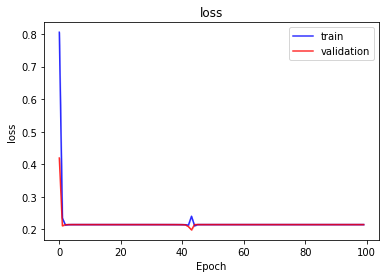

<b>bioma_mse</b>: 2787705600.0000 (min: 2787705600.0000, max: 2787705600.0000)

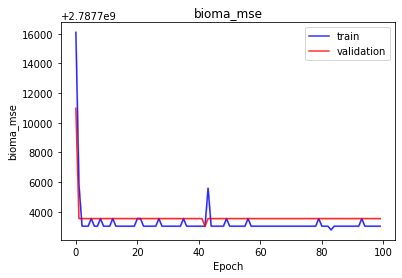

<b>bioma_mae</b>: 9028.4541 (min: 9028.4541, max: 9028.4541)

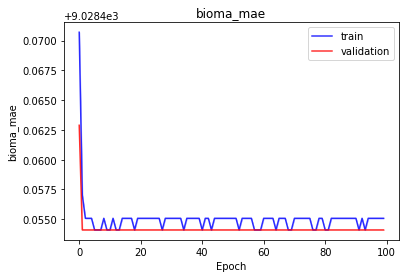

<b>bioma_mape</b>: 841.3532 (min: 841.3532, max: 841.3532)

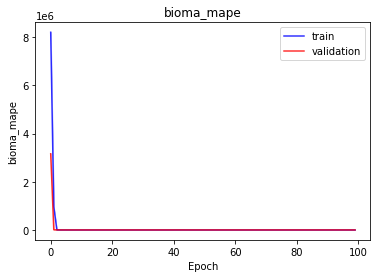

<b>bioma_BrayCurtis</b>: 0.2403 (min: 0.2403, max: 0.2403)

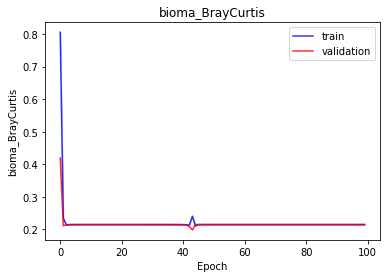

<b>bioma_pearson_corr</b>: 0.8857 (min: 0.8857, max: 0.8857)

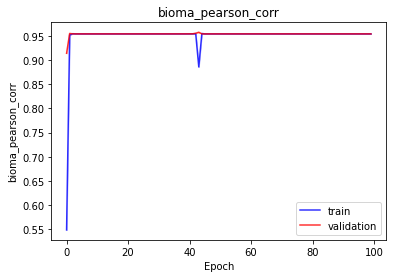

<b>bioma_jensen_shannon_divergence</b>: 0.4977 (min: 0.4977, max: 0.4977)

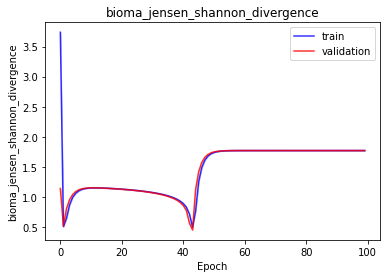

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 0.2403341382741928 | 0.2403341382741928 | 0.2403341382741928 |
| bioma_mse | 2787705600.0 | 2787705600.0 | 2787705600.0 |
| bioma_mae | 9028.4541015625 | 9028.4541015625 | 9028.4541015625 |
| bioma_mape | 841.3532104492188 | 841.3532104492188 | 841.3532104492188 |
| bioma_BrayCurtis | 0.2403341382741928 | 0.2403341382741928 | 0.2403341382741928 |
| bioma_pearson_corr | 0.8856687545776367 | 0.8856687545776367 | 0.8856687545776367 |
| bioma_jensen_shannon_divergence | 0.49770140647888184 | 0.49770140647888184 | 0.49770140647888184 |


*************

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.21448461711406708 | 0.21448461711406708 | 0.21448461711406708 |
| pearson_corr | 0.9567595720291138 | 0.9567595720291138 | 0.9567595720291138 |
| jensen_shannon_divergence | 1.779009222984314 | 1.779009222984314 | 1.779009222984314 |


In [27]:
experiment_metrics, models, results = perform_experiment_2_mod(cv_folds=0,
                                                               epochs=100,
                                                               batch_size=96,
                                                               learning_rate=0.001,
                                                               optimizer=optimizers.Adam,
                                                               learning_rate_scheduler=None,
                                                               input_transform=Percentage,
                                                               output_transform=tf.keras.layers.Softmax,
                                                               reconstruction_loss=MakeLoss(LossBrayCurtis, Percentage, None),
                                                               latent_space=15,
                                                               layers=[512,256],
                                                               activation='tanh',
                                                               activation_latent='tanh',
                                                               data_microbioma_train=data_microbioma_train,
                                                               data_domain_train=None,
                                                               show_results=True,
                                                               device='/CPU:0')
    
#Guardamos el modelo, encoder y decoder
model, encoder, _ ,decoder = models[0]
  
def model_fn_latent():
    in_layer = layers.Input(shape=(data_domain_train.shape[1],))
    net = layers.Dense(128, activation='softmax')(in_layer)
    net = layers.Dense(64, activation='softmax')(net)
    net = layers.Dense(32, activation='softmax')(net)
    net = layers.Dense(16, activation='softmax')(net)
    out_layer = layers.Dense(latent_train.shape[1], activation='tanh')(net)
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    model.compile(optimizer=optimizers.Adam(lr=0.01), loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.MeanSquaredError()])
    return model
    
#funcion del modelado -- por ahora lo dejaremos asi, y voy a habalr con ella par aver que cambio, que tuneo
latent_train = encoder.predict(data_microbioma_train)
    
result_latent, model_latent = train_tl_noEnsemble(model_fn_latent,
                                                  latent_train,
                                                  latent_train,
                                                  data_domain_train,
                                                  data_domain_train,
                                                  epochs=100,
                                                  batch_size=16,
                                                  verbose=-1)

#evaluamos el modelo
latent_test = encoder.predict(data_microbioma_test)
predictions = test_model_tl_noEnsemble(model_latent, decoder, Percentage, tf.keras.layers.Softmax, otu_columns, data_microbioma_test, data_domain_test)

In [28]:
encoder_biome = encoder
encoder_domain = model_latent
#Guardamos las predicciones
df_microbioma_test.T.to_csv('Results/otus_original_test_44OTU_orden.tsv', index=True, header=True, sep='\t')

#run prediction test set from microbiome, i.e, reconstructed
# Input only domain (i.e. environmental features)
pred_latent_biome = encoder_biome.predict(data_microbioma_test)
pred_biome = decoder.predict(pred_latent_biome)

_, _ = save_predicted_otu_table_and_latent(pred_biome,pred_latent_biome,df_microbioma_test.index,df_microbioma_test.columns,'reconstAEfromBiome_44OTU_orden')

#run prediction test set from domain, i.e., diet features
# Input only domain (i.e. environmental features)
pred_latent = encoder_domain.predict(data_domain_test)
pred_domain = decoder.predict(pred_latent)
df_pred_otu, df_pred_latent = save_predicted_otu_table_and_latent(pred_domain,pred_latent,df_microbioma_test.index,df_microbioma_test.columns,'predFromDomain_44OTU_orden')

#--------------------
actual_array = transform_to_rel_abundance(data_microbioma_test)
RSE_perOTU, RRSE_perOTU  = compute_relative_squared_error(actual_array,pred_domain)

df_error_perOTU = save_errors_per_OTU(RSE_perOTU,RRSE_perOTU,df_microbioma_test.columns,'Results/errors_perOTU_44OTU_orden')

In [ ]:
metrics = FI()
tabla_FI = pd.DataFrame.from_dict(metrics)
tabla_FI.to_csv("Results/nutrientes/FI/FI_OTU44_orden.csv",index=False)

### Class

In [29]:
nombres_metadatos = ["KCAL","PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","SUGR","FIBE","CALC","IRON","MAGN","PHOS","POTA","SODI","ZINC","COPP","SELE","VC","VB1","VB2","NIAC","VB6","FOLA","VB12","VARA","RET","BCAR","ACAR","CRYP","LYCO","LZ","ATOC","VK","CHOLE","SFAT","MFAT","PFAT","VITD","CHOLN"]
#nombres_metadatos = ["PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","CALC","MAGN","POTA","ZINC","VC","VB1","VB6","VARA","ACAR","CRYP","LYCO","ATOC","VK","CHOLE","VITD"]
df_microbioma_train, df_microbioma_test, _, _, \
df_domain_train, df_domain_test, _, _, otu_columns, domain_columns = read_df(metadata_names=nombres_metadatos,otu_filename='resultados_ana/nuevos_datos/arreglados/otu_table_Class.csv',metadata_filename='resultados_ana/datos_otus_metadatos_clase/metadatos_nutrientes_clase.csv')

data_microbioma_train = df_microbioma_train.to_numpy(dtype=np.float32)
data_microbioma_test = df_microbioma_test.to_numpy(dtype=np.float32)
data_domain_train = df_domain_train.to_numpy(dtype=np.float32)
data_domain_test = df_domain_test.to_numpy(dtype=np.float32)

| Parameter             | Value         |
|:----------------------|:--------------|
| Input transform | Percentage |
| Output transform | Softmax |
| Reconstruction Loss | LossBrayCurtis |
| Latent Space | 15 |
| Bioma Autoencoder | b -> 512 -> 256 -> 15 -> 256 -> 512 -> b |
| Domain Autoencoder |   |
| Activation Encoder | tanh |
| Activation Decoder | tanh |
| Activation Latent | tanh |
| CV folds | 0 |
| Epochs | 100 |
| Batch Size | 96 |
| Learning Rate Scheduler | none |
| Learning Rate | constant = 0.001 |
| Optimizer | Adam |


<p>Best iteration: <b>85</b></p>

<b>loss</b>: 0.0240 (min: 0.0240, max: 0.0240)

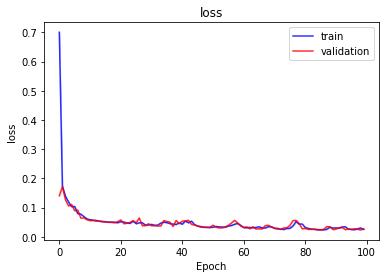

<b>bioma_mse</b>: 4695274496.0000 (min: 4695274496.0000, max: 4695274496.0000)

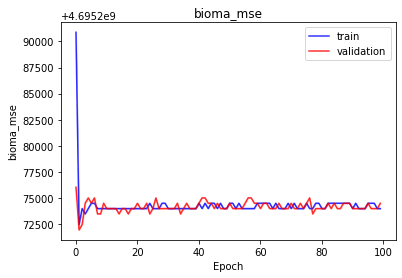

<b>bioma_mae</b>: 15206.2607 (min: 15206.2607, max: 15206.2607)

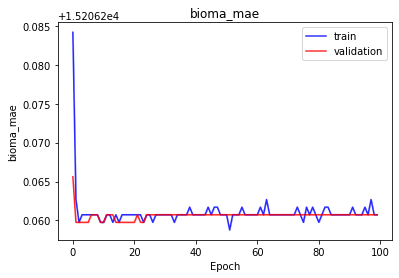

<b>bioma_mape</b>: 32083.4355 (min: 32083.4355, max: 32083.4355)

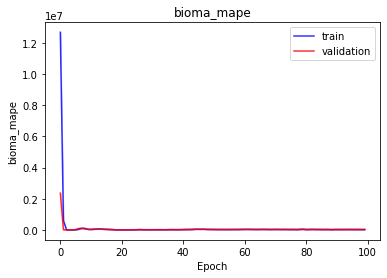

<b>bioma_BrayCurtis</b>: 0.0240 (min: 0.0240, max: 0.0240)

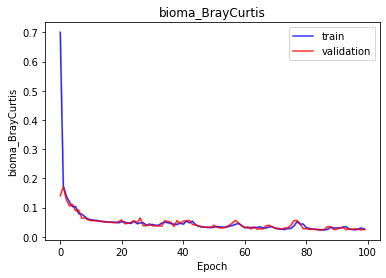

<b>bioma_pearson_corr</b>: 0.9991 (min: 0.9991, max: 0.9991)

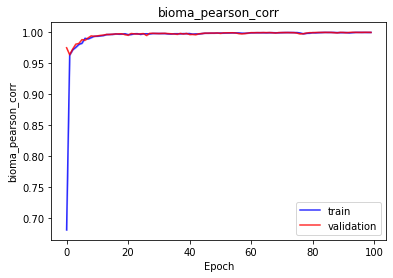

<b>bioma_jensen_shannon_divergence</b>: 0.0315 (min: 0.0315, max: 0.0315)

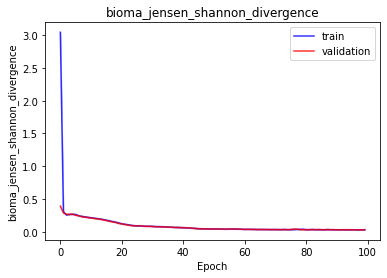

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 0.024021226912736893 | 0.024021226912736893 | 0.024021226912736893 |
| bioma_mse | 4695274496.0 | 4695274496.0 | 4695274496.0 |
| bioma_mae | 15206.2607421875 | 15206.2607421875 | 15206.2607421875 |
| bioma_mape | 32083.435546875 | 32083.435546875 | 32083.435546875 |
| bioma_BrayCurtis | 0.02402123063802719 | 0.02402123063802719 | 0.02402123063802719 |
| bioma_pearson_corr | 0.9990714192390442 | 0.9990714192390442 | 0.9990714192390442 |
| bioma_jensen_shannon_divergence | 0.03145654499530792 | 0.03145654499530792 | 0.03145654499530792 |


*************

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.11307254433631897 | 0.11307254433631897 | 0.11307254433631897 |
| pearson_corr | 0.981096625328064 | 0.981096625328064 | 0.981096625328064 |
| jensen_shannon_divergence | 0.10594034194946289 | 0.10594034194946289 | 0.10594034194946289 |


In [30]:
experiment_metrics, models, results = perform_experiment_2_mod(cv_folds=0,
                                                               epochs=100,
                                                               batch_size=96,
                                                               learning_rate=0.001,
                                                               optimizer=optimizers.Adam,
                                                               learning_rate_scheduler=None,
                                                               input_transform=Percentage,
                                                               output_transform=tf.keras.layers.Softmax,
                                                               reconstruction_loss=MakeLoss(LossBrayCurtis, Percentage, None),
                                                               latent_space=15,
                                                               layers=[512,256],
                                                               activation='tanh',
                                                               activation_latent='tanh',
                                                               data_microbioma_train=data_microbioma_train,
                                                               data_domain_train=None,
                                                               show_results=True,
                                                               device='/CPU:0')
    
#Guardamos el modelo, encoder y decoder
model, encoder, _ ,decoder = models[0]
  
def model_fn_latent():
    in_layer = layers.Input(shape=(data_domain_train.shape[1],))
    net = layers.Dense(128, activation='softmax')(in_layer)
    net = layers.Dense(64, activation='softmax')(net)
    net = layers.Dense(32, activation='softmax')(net)
    net = layers.Dense(16, activation='softmax')(net)
    out_layer = layers.Dense(latent_train.shape[1], activation='tanh')(net)
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    model.compile(optimizer=optimizers.Adam(lr=0.01), loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.MeanSquaredError()])
    return model
    
#funcion del modelado -- por ahora lo dejaremos asi, y voy a habalr con ella par aver que cambio, que tuneo
latent_train = encoder.predict(data_microbioma_train)
    
result_latent, model_latent = train_tl_noEnsemble(model_fn_latent,
                                                  latent_train,
                                                  latent_train,
                                                  data_domain_train,
                                                  data_domain_train,
                                                  epochs=100,
                                                  batch_size=16,
                                                  verbose=-1)

#evaluamos el modelo
latent_test = encoder.predict(data_microbioma_test)
predictions = test_model_tl_noEnsemble(model_latent, decoder, Percentage, tf.keras.layers.Softmax, otu_columns, data_microbioma_test, data_domain_test)

In [31]:
encoder_biome = encoder
encoder_domain = model_latent
#Guardamos las predicciones
df_microbioma_test.T.to_csv('Results/otus_original_test_44OTU_clase.tsv', index=True, header=True, sep='\t')

#run prediction test set from microbiome, i.e, reconstructed
# Input only domain (i.e. environmental features)
pred_latent_biome = encoder_biome.predict(data_microbioma_test)
pred_biome = decoder.predict(pred_latent_biome)

_, _ = save_predicted_otu_table_and_latent(pred_biome,pred_latent_biome,df_microbioma_test.index,df_microbioma_test.columns,'reconstAEfromBiome_44OTU_clase')

#run prediction test set from domain, i.e., diet features
# Input only domain (i.e. environmental features)
pred_latent = encoder_domain.predict(data_domain_test)
pred_domain = decoder.predict(pred_latent)
df_pred_otu, df_pred_latent = save_predicted_otu_table_and_latent(pred_domain,pred_latent,df_microbioma_test.index,df_microbioma_test.columns,'predFromDomain_44OTU_clase')

#--------------------
actual_array = transform_to_rel_abundance(data_microbioma_test)
RSE_perOTU, RRSE_perOTU  = compute_relative_squared_error(actual_array,pred_domain)

df_error_perOTU = save_errors_per_OTU(RSE_perOTU,RRSE_perOTU,df_microbioma_test.columns,'Results/errors_perOTU_44OTU_clase')

In [ ]:
metrics = FI()
tabla_FI = pd.DataFrame.from_dict(metrics)
tabla_FI.to_csv("Results/nutrientes/FI/FI_OTU44_class.csv",index=False)

### Phylum

In [32]:
nombres_metadatos = ["KCAL","PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","SUGR","FIBE","CALC","IRON","MAGN","PHOS","POTA","SODI","ZINC","COPP","SELE","VC","VB1","VB2","NIAC","VB6","FOLA","VB12","VARA","RET","BCAR","ACAR","CRYP","LYCO","LZ","ATOC","VK","CHOLE","SFAT","MFAT","PFAT","VITD","CHOLN"]
#nombres_metadatos = ["PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","CALC","MAGN","POTA","ZINC","VC","VB1","VB6","VARA","ACAR","CRYP","LYCO","ATOC","VK","CHOLE","VITD"]
df_microbioma_train, df_microbioma_test, _, _, \
df_domain_train, df_domain_test, _, _, otu_columns, domain_columns = read_df(metadata_names=nombres_metadatos,otu_filename='resultados_ana/nuevos_datos/arreglados/otu_table_Phylum.csv',metadata_filename='resultados_ana/todos_metadatos_todos.csv')

data_microbioma_train = df_microbioma_train.to_numpy(dtype=np.float32)
data_microbioma_test = df_microbioma_test.to_numpy(dtype=np.float32)
data_domain_train = df_domain_train.to_numpy(dtype=np.float32)
data_domain_test = df_domain_test.to_numpy(dtype=np.float32)

| Parameter             | Value         |
|:----------------------|:--------------|
| Input transform | Percentage |
| Output transform | Softmax |
| Reconstruction Loss | LossBrayCurtis |
| Latent Space | 15 |
| Bioma Autoencoder | b -> 512 -> 256 -> 15 -> 256 -> 512 -> b |
| Domain Autoencoder |   |
| Activation Encoder | tanh |
| Activation Decoder | tanh |
| Activation Latent | tanh |
| CV folds | 0 |
| Epochs | 100 |
| Batch Size | 96 |
| Learning Rate Scheduler | none |
| Learning Rate | constant = 0.001 |
| Optimizer | Adam |


<p>Best iteration: <b>99</b></p>

<b>loss</b>: 0.0149 (min: 0.0149, max: 0.0149)

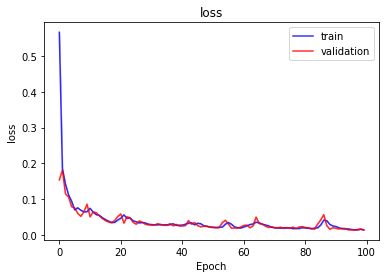

<b>bioma_mse</b>: 9952978944.0000 (min: 9952978944.0000, max: 9952978944.0000)

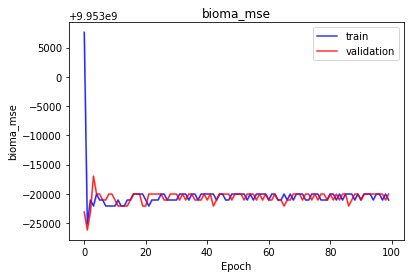

<b>bioma_mae</b>: 32181.6914 (min: 32181.6914, max: 32181.6914)

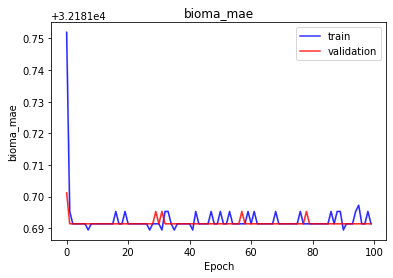

<b>bioma_mape</b>: 30208.1172 (min: 30208.1172, max: 30208.1172)

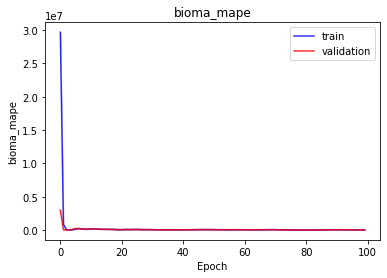

<b>bioma_BrayCurtis</b>: 0.0149 (min: 0.0149, max: 0.0149)

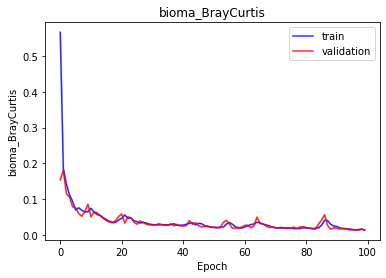

<b>bioma_pearson_corr</b>: 0.9995 (min: 0.9995, max: 0.9995)

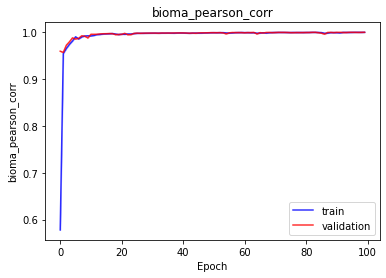

<b>bioma_jensen_shannon_divergence</b>: 0.0132 (min: 0.0132, max: 0.0132)

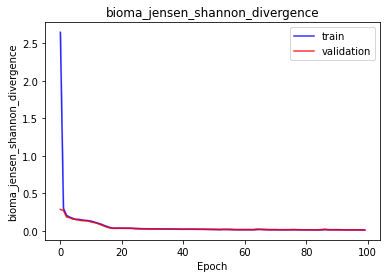

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 0.01491506863385439 | 0.01491506863385439 | 0.01491506863385439 |
| bioma_mse | 9952978944.0 | 9952978944.0 | 9952978944.0 |
| bioma_mae | 32181.69140625 | 32181.69140625 | 32181.69140625 |
| bioma_mape | 30208.1171875 | 30208.1171875 | 30208.1171875 |
| bioma_BrayCurtis | 0.01491506863385439 | 0.01491506863385439 | 0.01491506863385439 |
| bioma_pearson_corr | 0.9995429515838623 | 0.9995429515838623 | 0.9995429515838623 |
| bioma_jensen_shannon_divergence | 0.013186676427721977 | 0.013186676427721977 | 0.013186676427721977 |


*************

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.10728862136602402 | 0.10728862136602402 | 0.10728862136602402 |
| pearson_corr | 0.9787552952766418 | 0.9787552952766418 | 0.9787552952766418 |
| jensen_shannon_divergence | 0.08389171957969666 | 0.08389171957969666 | 0.08389171957969666 |


In [33]:
experiment_metrics, models, results = perform_experiment_2_mod(cv_folds=0,
                                                               epochs=100,
                                                               batch_size=96,
                                                               learning_rate=0.001,
                                                               optimizer=optimizers.Adam,
                                                               learning_rate_scheduler=None,
                                                               input_transform=Percentage,
                                                               output_transform=tf.keras.layers.Softmax,
                                                               reconstruction_loss=MakeLoss(LossBrayCurtis, Percentage, None),
                                                               latent_space=15,
                                                               layers=[512,256],
                                                               activation='tanh',
                                                               activation_latent='tanh',
                                                               data_microbioma_train=data_microbioma_train,
                                                               data_domain_train=None,
                                                               show_results=True,
                                                               device='/CPU:0')
    
#Guardamos el modelo, encoder y decoder
model, encoder, _ ,decoder = models[0]
  
def model_fn_latent():
    in_layer = layers.Input(shape=(data_domain_train.shape[1],))
    net = layers.Dense(128, activation='softmax')(in_layer)
    net = layers.Dense(64, activation='softmax')(net)
    net = layers.Dense(32, activation='softmax')(net)
    net = layers.Dense(16, activation='softmax')(net)
    out_layer = layers.Dense(latent_train.shape[1], activation='tanh')(net)
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    model.compile(optimizer=optimizers.Adam(lr=0.01), loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.MeanSquaredError()])
    return model
    
#funcion del modelado -- por ahora lo dejaremos asi, y voy a habalr con ella par aver que cambio, que tuneo
latent_train = encoder.predict(data_microbioma_train)
    
result_latent, model_latent = train_tl_noEnsemble(model_fn_latent,
                                                  latent_train,
                                                  latent_train,
                                                  data_domain_train,
                                                  data_domain_train,
                                                  epochs=100,
                                                  batch_size=16,
                                                  verbose=-1)

#evaluamos el modelo
latent_test = encoder.predict(data_microbioma_test)
predictions = test_model_tl_noEnsemble(model_latent, decoder, Percentage, tf.keras.layers.Softmax, otu_columns, data_microbioma_test, data_domain_test)

In [34]:
encoder_biome = encoder
encoder_domain = model_latent
#Guardamos las predicciones
df_microbioma_test.T.to_csv('Results/otus_original_test_44OTU_filo.tsv', index=True, header=True, sep='\t')

#run prediction test set from microbiome, i.e, reconstructed
# Input only domain (i.e. environmental features)
pred_latent_biome = encoder_biome.predict(data_microbioma_test)
pred_biome = decoder.predict(pred_latent_biome)

_, _ = save_predicted_otu_table_and_latent(pred_biome,pred_latent_biome,df_microbioma_test.index,df_microbioma_test.columns,'reconstAEfromBiome_44OTU_filo')

#run prediction test set from domain, i.e., diet features
# Input only domain (i.e. environmental features)
pred_latent = encoder_domain.predict(data_domain_test)
pred_domain = decoder.predict(pred_latent)
df_pred_otu, df_pred_latent = save_predicted_otu_table_and_latent(pred_domain,pred_latent,df_microbioma_test.index,df_microbioma_test.columns,'predFromDomain_44OTU_filo')

#--------------------
actual_array = transform_to_rel_abundance(data_microbioma_test)
RSE_perOTU, RRSE_perOTU  = compute_relative_squared_error(actual_array,pred_domain)

df_error_perOTU = save_errors_per_OTU(RSE_perOTU,RRSE_perOTU,df_microbioma_test.columns,'Results/errors_perOTU_44OTU_filo')

In [ ]:
metrics = FI()
tabla_FI = pd.DataFrame.from_dict(metrics)
tabla_FI.to_csv("Results/nutrientes/FI/FI_OTU44_filo.csv",index=False)

--------------------------
--------------------------
# 22 variables Latent Combined

### Genus

In [35]:
#nombres_metadatos = ["KCAL","PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","SUGR","FIBE","CALC","IRON","MAGN","PHOS","POTA","SODI","ZINC","COPP","SELE","VC","VB1","VB2","NIAC","VB6","FOLA","VB12","VARA","RET","BCAR","ACAR","CRYP","LYCO","LZ","ATOC","VK","CHOLE","SFAT","MFAT","PFAT","VITD","CHOLN"]
nombres_metadatos = ["PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","CALC","MAGN","POTA","ZINC","VC","VB1","VB6","VARA","ACAR","CRYP","LYCO","ATOC","VK","CHOLE","VITD"]
df_microbioma_train, df_microbioma_test, _, _, \
df_domain_train, df_domain_test, _, _, otu_columns, domain_columns = read_df(metadata_names=nombres_metadatos,otu_filename='resultados_ana/nuevos_datos/arreglados/otu_table_Genus.csv',metadata_filename='resultados_ana/datos_otus_metadatos_genero/metadatos_nutrientes_genero.csv')

data_microbioma_train = df_microbioma_train.to_numpy(dtype=np.float32)
data_microbioma_test = df_microbioma_test.to_numpy(dtype=np.float32)
data_domain_train = df_domain_train.to_numpy(dtype=np.float32)
data_domain_test = df_domain_test.to_numpy(dtype=np.float32)

| Parameter             | Value         |
|:----------------------|:--------------|
| Input transform | Percentage |
| Output transform | Softmax |
| Reconstruction Loss | LossBrayCurtis |
| Latent Space | 15 |
| Bioma Autoencoder | b -> 512 -> 256 -> 128 -> 15 -> 128 -> 256 -> 512 -> b |
| Domain Autoencoder | d -> 32 -> 16 -> 8 -> 15 -> 128 -> 256 -> 512 -> b |
| Activation Encoder | tanh |
| Activation Decoder | tanh |
| Activation Latent | tanh |
| CV folds | 0 |
| Epochs | 100 |
| Batch Size | 64 |
| Learning Rate Scheduler | none |
| Learning Rate | constant = 0.001 |
| Optimizer | Adam |


<p>Best iteration: <b>99</b></p>

<b>loss</b>: 0.4006 (min: 0.4006, max: 0.4006)

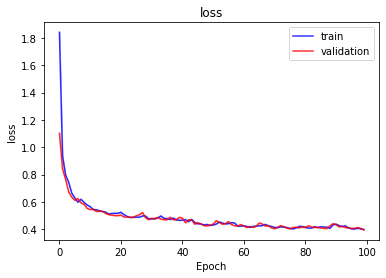

<b>bioma_loss</b>: 0.1090 (min: 0.1090, max: 0.1090)

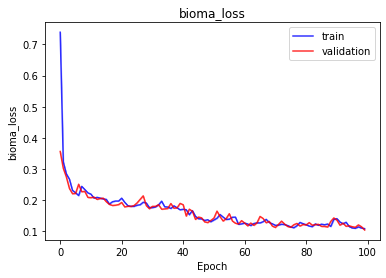

<b>domain_loss</b>: 0.2668 (min: 0.2668, max: 0.2668)

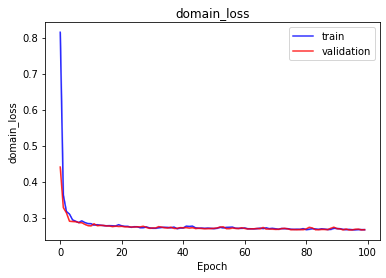

<b>latent_loss</b>: 0.0248 (min: 0.0248, max: 0.0248)

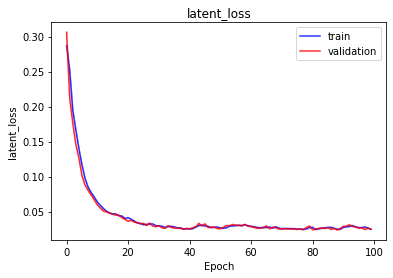

<b>bioma_mse</b>: 303918048.0000 (min: 303918048.0000, max: 303918048.0000)

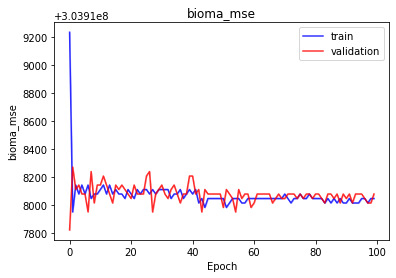

<b>bioma_mae</b>: 1614.6122 (min: 1614.6122, max: 1614.6122)

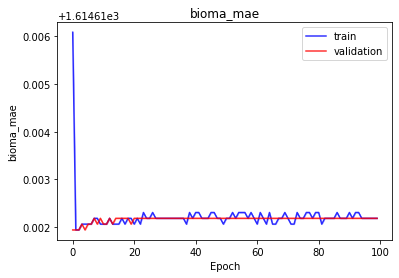

<b>bioma_mape</b>: 15462.5820 (min: 15462.5820, max: 15462.5820)

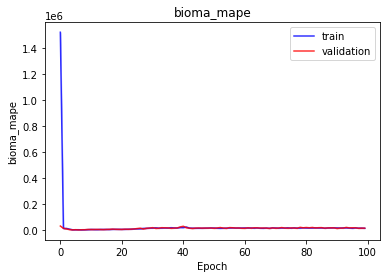

<b>bioma_BrayCurtis</b>: 0.1090 (min: 0.1090, max: 0.1090)

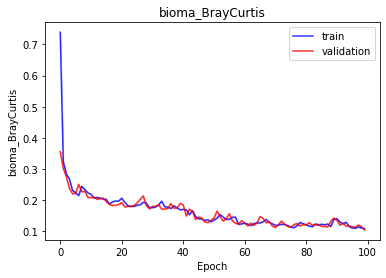

<b>bioma_pearson_corr</b>: 0.9902 (min: 0.9902, max: 0.9902)

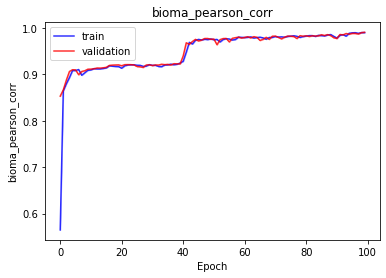

<b>bioma_jensen_shannon_divergence</b>: 0.1868 (min: 0.1868, max: 0.1868)

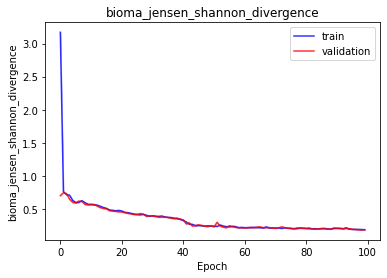

<b>domain_mse</b>: 303918208.0000 (min: 303918208.0000, max: 303918208.0000)

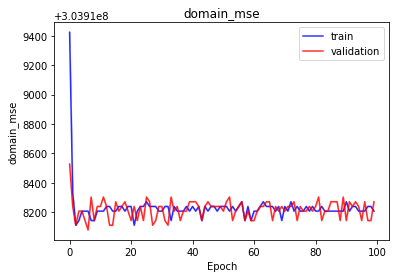

<b>domain_mae</b>: 1614.6123 (min: 1614.6123, max: 1614.6123)

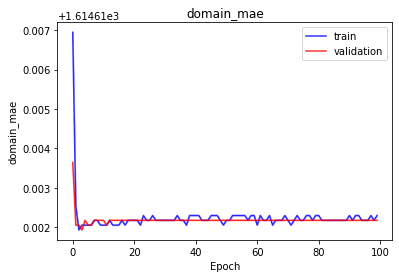

<b>domain_mape</b>: 11719.6680 (min: 11719.6680, max: 11719.6680)

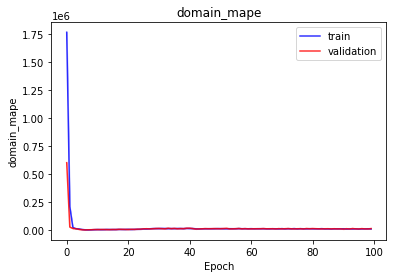

<b>domain_BrayCurtis</b>: 0.2668 (min: 0.2668, max: 0.2668)

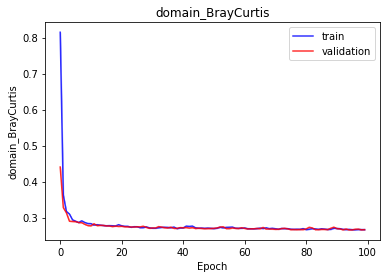

<b>domain_pearson_corr</b>: 0.8786 (min: 0.8786, max: 0.8786)

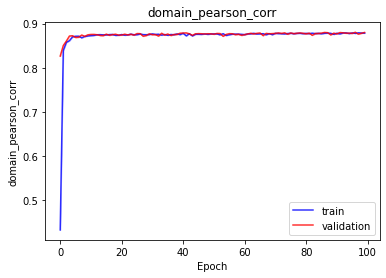

<b>domain_jensen_shannon_divergence</b>: 0.5336 (min: 0.5336, max: 0.5336)

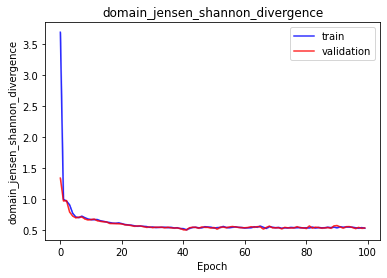

<b>latent_mae</b>: 0.0248 (min: 0.0248, max: 0.0248)

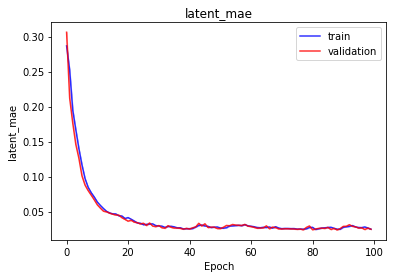

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 0.40062639117240906 | 0.40062639117240906 | 0.40062639117240906 |
| bioma_loss | 0.10898160189390182 | 0.10898160189390182 | 0.10898160189390182 |
| domain_loss | 0.266815721988678 | 0.266815721988678 | 0.266815721988678 |
| latent_loss | 0.0248290803283453 | 0.0248290803283453 | 0.0248290803283453 |
| bioma_mse | 303918048.0 | 303918048.0 | 303918048.0 |
| bioma_mae | 1614.6121826171875 | 1614.6121826171875 | 1614.6121826171875 |
| bioma_mape | 15462.58203125 | 15462.58203125 | 15462.58203125 |
| bioma_BrayCurtis | 0.10898160189390182 | 0.10898160189390182 | 0.10898160189390182 |
| bioma_pearson_corr | 0.9902370572090149 | 0.9902370572090149 | 0.9902370572090149 |
| bioma_jensen_shannon_divergence | 0.18679355084896088 | 0.18679355084896088 | 0.18679355084896088 |
| domain_mse | 303918208.0 | 303918208.0 | 303918208.0 |
| domain_mae | 1614.6123046875 | 1614.6123046875 | 1614.6123046875 |
| domain_mape | 11719.66796875 | 11719.66796875 | 11719.66796875 |
| domain_BrayCurtis | 0.266815721988678 | 0.266815721988678 | 0.266815721988678 |
| domain_pearson_corr | 0.8785642981529236 | 0.8785642981529236 | 0.8785642981529236 |
| domain_jensen_shannon_divergence | 0.5336461067199707 | 0.5336461067199707 | 0.5336461067199707 |
| latent_mae | 0.0248290803283453 | 0.0248290803283453 | 0.0248290803283453 |


*************

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.2778565287590027 | 0.2778565287590027 | 0.2778565287590027 |
| pearson_corr | 0.8839901685714722 | 0.8839901685714722 | 0.8839901685714722 |
| jensen_shannon_divergence | 0.523068368434906 | 0.523068368434906 | 0.523068368434906 |


In [36]:
experiment_metrics, models, results = perform_experiment_2_mod(cv_folds=0,
                                                               epochs=100,
                                                               batch_size=64,
                                                               learning_rate=0.001,
                                                               optimizer=optimizers.Adam,
                                                               learning_rate_scheduler=None,
                                                               input_transform=Percentage,
                                                               output_transform=tf.keras.layers.Softmax,
                                                               reconstruction_loss=MakeLoss(LossBrayCurtis, Percentage, None),
                                                               latent_space=15,
                                                               layers=[512,256,128],
                                                               activation='tanh',
                                                               activation_latent='tanh',
                                                               data_microbioma_train=data_microbioma_train,
                                                               data_domain_train=data_domain_train,
                                                               show_results=True,
                                                               device='/CPU:0')
    
#Guardamos el modelo, encoder y decoder
model, encoder, _ ,decoder = models[0]
  
def model_fn_latent():
    in_layer = layers.Input(shape=(data_domain_train.shape[1],))
    net = layers.Dense(128, activation='tanh')(in_layer)
    net = layers.Dense(64, activation='tanh')(net)
    net = layers.Dense(32, activation='tanh')(net)
    net = layers.Dense(16, activation='tanh')(net)
    out_layer = layers.Dense(latent_train.shape[1], activation='tanh')(net)
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    model.compile(optimizer=optimizers.Adam(lr=0.001), loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.MeanSquaredError()])
    return model
    
#funcion del modelado -- por ahora lo dejaremos asi, y voy a habalr con ella par aver que cambio, que tuneo
latent_train = encoder.predict(data_microbioma_train)
    
result_latent, model_latent = train_tl_noEnsemble(model_fn_latent,
                                                  latent_train,
                                                  latent_train,
                                                  data_domain_train,
                                                  data_domain_train,
                                                  epochs=100,
                                                  batch_size=16,
                                                  verbose=-1)

#evaluamos el modelo
latent_test = encoder.predict(data_microbioma_test)
predictions = test_model_tl_noEnsemble(model_latent, decoder, Percentage, tf.keras.layers.Softmax, otu_columns, data_microbioma_test, data_domain_test)

In [37]:
encoder_biome = encoder
encoder_domain = model_latent
#Guardamos las predicciones
df_microbioma_test.T.to_csv('Results/otus_original_test_22Combined_genero.tsv', index=True, header=True, sep='\t')

#run prediction test set from microbiome, i.e, reconstructed
# Input only domain (i.e. environmental features)
pred_latent_biome = encoder_biome.predict(data_microbioma_test)
pred_biome = decoder.predict(pred_latent_biome)

_, _ = save_predicted_otu_table_and_latent(pred_biome,pred_latent_biome,df_microbioma_test.index,df_microbioma_test.columns,'reconstAEfromBiome_22Combined_genero')

#run prediction test set from domain, i.e., diet features
# Input only domain (i.e. environmental features)
pred_latent = encoder_domain.predict(data_domain_test)
pred_domain = decoder.predict(pred_latent)
df_pred_otu, df_pred_latent = save_predicted_otu_table_and_latent(pred_domain,pred_latent,df_microbioma_test.index,df_microbioma_test.columns,'predFromDomain_22Combined_genero')

#--------------------
actual_array = transform_to_rel_abundance(data_microbioma_test)
RSE_perOTU, RRSE_perOTU  = compute_relative_squared_error(actual_array,pred_domain)

df_error_perOTU = save_errors_per_OTU(RSE_perOTU,RRSE_perOTU,df_microbioma_test.columns,'Results/errors_perOTU_22Combined_genero')

In [ ]:
metrics = FI()
tabla_FI = pd.DataFrame.from_dict(metrics)
tabla_FI.to_csv("Results/nutrientes/FI/FI_Combined22_genus.csv",index=False)

### Family

In [38]:
#nombres_metadatos = ["KCAL","PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","SUGR","FIBE","CALC","IRON","MAGN","PHOS","POTA","SODI","ZINC","COPP","SELE","VC","VB1","VB2","NIAC","VB6","FOLA","VB12","VARA","RET","BCAR","ACAR","CRYP","LYCO","LZ","ATOC","VK","CHOLE","SFAT","MFAT","PFAT","VITD","CHOLN"]
nombres_metadatos = ["PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","CALC","MAGN","POTA","ZINC","VC","VB1","VB6","VARA","ACAR","CRYP","LYCO","ATOC","VK","CHOLE","VITD"]
df_microbioma_train, df_microbioma_test, _, _, \
df_domain_train, df_domain_test, _, _, otu_columns, domain_columns = read_df(metadata_names=nombres_metadatos,otu_filename='resultados_ana/nuevos_datos/arreglados/otu_table_Family.csv',metadata_filename='resultados_ana/datos_otus_metadatos_familia/metadatos_nutrientes_familia.csv')

data_microbioma_train = df_microbioma_train.to_numpy(dtype=np.float32)
data_microbioma_test = df_microbioma_test.to_numpy(dtype=np.float32)
data_domain_train = df_domain_train.to_numpy(dtype=np.float32)
data_domain_test = df_domain_test.to_numpy(dtype=np.float32)

| Parameter             | Value         |
|:----------------------|:--------------|
| Input transform | Percentage |
| Output transform | Softmax |
| Reconstruction Loss | LossBrayCurtis |
| Latent Space | 15 |
| Bioma Autoencoder | b -> 512 -> 256 -> 128 -> 15 -> 128 -> 256 -> 512 -> b |
| Domain Autoencoder | d -> 32 -> 16 -> 8 -> 15 -> 128 -> 256 -> 512 -> b |
| Activation Encoder | tanh |
| Activation Decoder | tanh |
| Activation Latent | tanh |
| CV folds | 0 |
| Epochs | 100 |
| Batch Size | 64 |
| Learning Rate Scheduler | none |
| Learning Rate | constant = 0.001 |
| Optimizer | Adam |


<p>Best iteration: <b>93</b></p>

<b>loss</b>: 0.3750 (min: 0.3750, max: 0.3750)

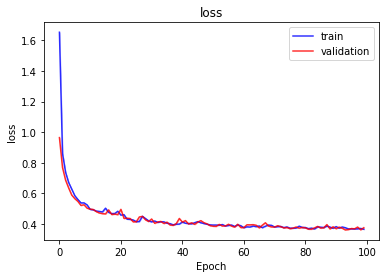

<b>bioma_loss</b>: 0.0944 (min: 0.0944, max: 0.0944)

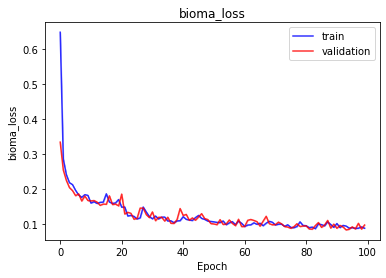

<b>domain_loss</b>: 0.2537 (min: 0.2537, max: 0.2537)

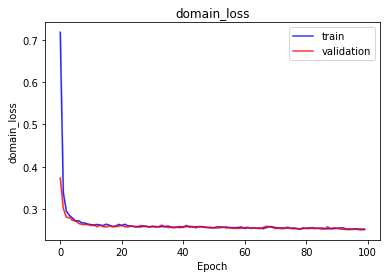

<b>latent_loss</b>: 0.0268 (min: 0.0268, max: 0.0268)

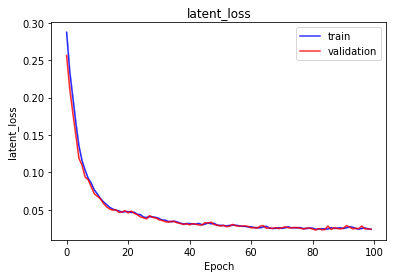

<b>bioma_mse</b>: 878693568.0000 (min: 878693568.0000, max: 878693568.0000)

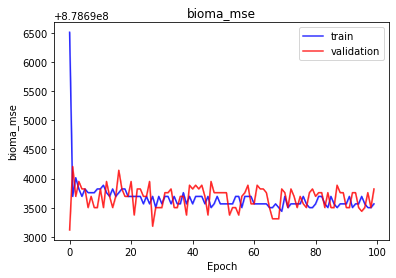

<b>bioma_mae</b>: 4677.9307 (min: 4677.9307, max: 4677.9307)

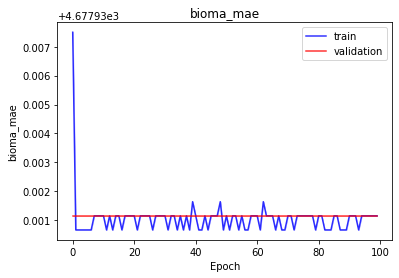

<b>bioma_mape</b>: 18770.7520 (min: 18770.7520, max: 18770.7520)

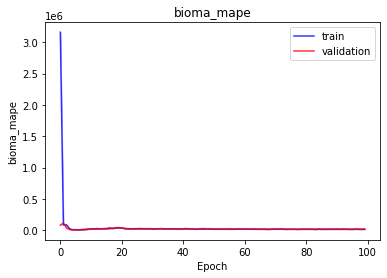

<b>bioma_BrayCurtis</b>: 0.0944 (min: 0.0944, max: 0.0944)

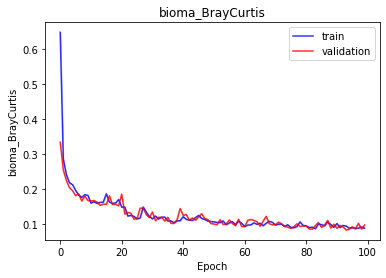

<b>bioma_pearson_corr</b>: 0.9903 (min: 0.9903, max: 0.9903)

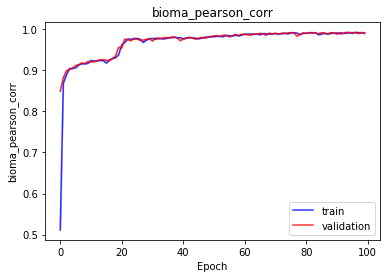

<b>bioma_jensen_shannon_divergence</b>: 0.1151 (min: 0.1151, max: 0.1151)

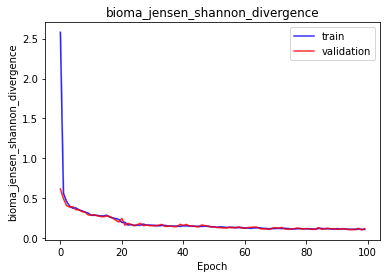

<b>domain_mse</b>: 878694080.0000 (min: 878694080.0000, max: 878694080.0000)

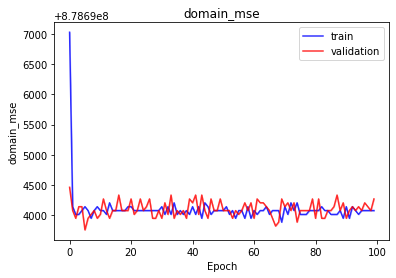

<b>domain_mae</b>: 4677.9312 (min: 4677.9312, max: 4677.9312)

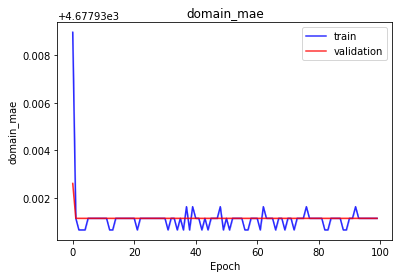

<b>domain_mape</b>: 15796.3760 (min: 15796.3760, max: 15796.3760)

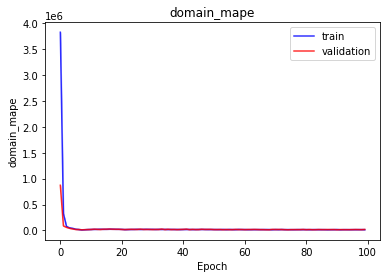

<b>domain_BrayCurtis</b>: 0.2537 (min: 0.2537, max: 0.2537)

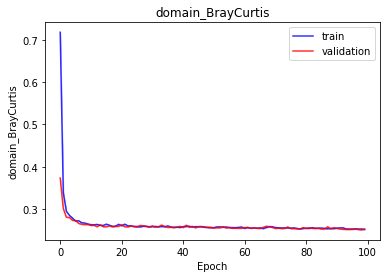

<b>domain_pearson_corr</b>: 0.8749 (min: 0.8749, max: 0.8749)

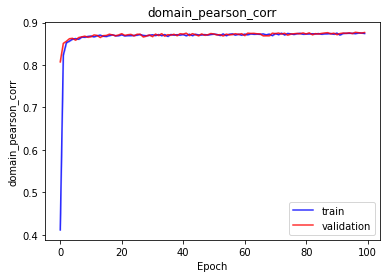

<b>domain_jensen_shannon_divergence</b>: 0.4183 (min: 0.4183, max: 0.4183)

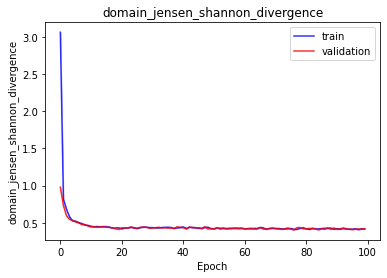

<b>latent_mae</b>: 0.0268 (min: 0.0268, max: 0.0268)

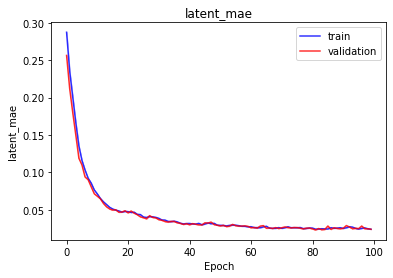

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 0.3749566674232483 | 0.3749566674232483 | 0.3749566674232483 |
| bioma_loss | 0.09439831972122192 | 0.09439831972122192 | 0.09439831972122192 |
| domain_loss | 0.25374487042427063 | 0.25374487042427063 | 0.25374487042427063 |
| latent_loss | 0.026813438162207603 | 0.026813438162207603 | 0.026813438162207603 |
| bioma_mse | 878693568.0 | 878693568.0 | 878693568.0 |
| bioma_mae | 4677.9306640625 | 4677.9306640625 | 4677.9306640625 |
| bioma_mape | 18770.751953125 | 18770.751953125 | 18770.751953125 |
| bioma_BrayCurtis | 0.09439831972122192 | 0.09439831972122192 | 0.09439831972122192 |
| bioma_pearson_corr | 0.9903184771537781 | 0.9903184771537781 | 0.9903184771537781 |
| bioma_jensen_shannon_divergence | 0.11509323120117188 | 0.11509323120117188 | 0.11509323120117188 |
| domain_mse | 878694080.0 | 878694080.0 | 878694080.0 |
| domain_mae | 4677.93115234375 | 4677.93115234375 | 4677.93115234375 |
| domain_mape | 15796.3759765625 | 15796.3759765625 | 15796.3759765625 |
| domain_BrayCurtis | 0.25374487042427063 | 0.25374487042427063 | 0.25374487042427063 |
| domain_pearson_corr | 0.874939501285553 | 0.874939501285553 | 0.874939501285553 |
| domain_jensen_shannon_divergence | 0.41828739643096924 | 0.41828739643096924 | 0.41828739643096924 |
| latent_mae | 0.026813438162207603 | 0.026813438162207603 | 0.026813438162207603 |


*************

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.27158963680267334 | 0.27158963680267334 | 0.27158963680267334 |
| pearson_corr | 0.8779464364051819 | 0.8779464364051819 | 0.8779464364051819 |
| jensen_shannon_divergence | 0.45279163122177124 | 0.45279163122177124 | 0.45279163122177124 |


In [39]:
experiment_metrics, models, results = perform_experiment_2_mod(cv_folds=0,
                                                               epochs=100,
                                                               batch_size=64,
                                                               learning_rate=0.001,
                                                               optimizer=optimizers.Adam,
                                                               learning_rate_scheduler=None,
                                                               input_transform=Percentage,
                                                               output_transform=tf.keras.layers.Softmax,
                                                               reconstruction_loss=MakeLoss(LossBrayCurtis, Percentage, None),
                                                               latent_space=15,
                                                               layers=[512,256,128],
                                                               activation='tanh',
                                                               activation_latent='tanh',
                                                               data_microbioma_train=data_microbioma_train,
                                                               data_domain_train=data_domain_train,
                                                               show_results=True,
                                                               device='/CPU:0')
    
#Guardamos el modelo, encoder y decoder
model, encoder, _ ,decoder = models[0]
  
def model_fn_latent():
    in_layer = layers.Input(shape=(data_domain_train.shape[1],))
    net = layers.Dense(128, activation='tanh')(in_layer)
    net = layers.Dense(64, activation='tanh')(net)
    net = layers.Dense(32, activation='tanh')(net)
    net = layers.Dense(16, activation='tanh')(net)
    out_layer = layers.Dense(latent_train.shape[1], activation='tanh')(net)
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    model.compile(optimizer=optimizers.Adam(lr=0.001), loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.MeanSquaredError()])
    return model
    
#funcion del modelado -- por ahora lo dejaremos asi, y voy a habalr con ella par aver que cambio, que tuneo
latent_train = encoder.predict(data_microbioma_train)
    
result_latent, model_latent = train_tl_noEnsemble(model_fn_latent,
                                                  latent_train,
                                                  latent_train,
                                                  data_domain_train,
                                                  data_domain_train,
                                                  epochs=100,
                                                  batch_size=16,
                                                  verbose=-1)

#evaluamos el modelo
latent_test = encoder.predict(data_microbioma_test)
predictions = test_model_tl_noEnsemble(model_latent, decoder, Percentage, tf.keras.layers.Softmax, otu_columns, data_microbioma_test, data_domain_test)

In [40]:
encoder_biome = encoder
encoder_domain = model_latent
#Guardamos las predicciones
df_microbioma_test.T.to_csv('Results/otus_original_test_22Combined_familia.tsv', index=True, header=True, sep='\t')

#run prediction test set from microbiome, i.e, reconstructed
# Input only domain (i.e. environmental features)
pred_latent_biome = encoder_biome.predict(data_microbioma_test)
pred_biome = decoder.predict(pred_latent_biome)

_, _ = save_predicted_otu_table_and_latent(pred_biome,pred_latent_biome,df_microbioma_test.index,df_microbioma_test.columns,'reconstAEfromBiome_22Combined_familia')

#run prediction test set from domain, i.e., diet features
# Input only domain (i.e. environmental features)
pred_latent = encoder_domain.predict(data_domain_test)
pred_domain = decoder.predict(pred_latent)
df_pred_otu, df_pred_latent = save_predicted_otu_table_and_latent(pred_domain,pred_latent,df_microbioma_test.index,df_microbioma_test.columns,'predFromDomain_22Combined_familia')

#--------------------
actual_array = transform_to_rel_abundance(data_microbioma_test)
RSE_perOTU, RRSE_perOTU  = compute_relative_squared_error(actual_array,pred_domain)

df_error_perOTU = save_errors_per_OTU(RSE_perOTU,RRSE_perOTU,df_microbioma_test.columns,'Results/errors_perOTU_22Combined_familia')

In [ ]:
metrics = FI()
tabla_FI = pd.DataFrame.from_dict(metrics)
tabla_FI.to_csv("Results/nutrientes/FI/FI_Combined22_family.csv",index=False)

### Order

In [41]:
#nombres_metadatos = ["KCAL","PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","SUGR","FIBE","CALC","IRON","MAGN","PHOS","POTA","SODI","ZINC","COPP","SELE","VC","VB1","VB2","NIAC","VB6","FOLA","VB12","VARA","RET","BCAR","ACAR","CRYP","LYCO","LZ","ATOC","VK","CHOLE","SFAT","MFAT","PFAT","VITD","CHOLN"]
nombres_metadatos = ["PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","CALC","MAGN","POTA","ZINC","VC","VB1","VB6","VARA","ACAR","CRYP","LYCO","ATOC","VK","CHOLE","VITD"]
df_microbioma_train, df_microbioma_test, _, _, \
df_domain_train, df_domain_test, _, _, otu_columns, domain_columns = read_df(metadata_names=nombres_metadatos,otu_filename='resultados_ana/nuevos_datos/arreglados/otu_table_Order.csv',metadata_filename='resultados_ana/datos_otus_metadatos_orden/metadatos_nutrientes_orden.csv')

data_microbioma_train = df_microbioma_train.to_numpy(dtype=np.float32)
data_microbioma_test = df_microbioma_test.to_numpy(dtype=np.float32)
data_domain_train = df_domain_train.to_numpy(dtype=np.float32)
data_domain_test = df_domain_test.to_numpy(dtype=np.float32)

| Parameter             | Value         |
|:----------------------|:--------------|
| Input transform | Percentage |
| Output transform | Softmax |
| Reconstruction Loss | LossBrayCurtis |
| Latent Space | 15 |
| Bioma Autoencoder | b -> 512 -> 256 -> 128 -> 15 -> 128 -> 256 -> 512 -> b |
| Domain Autoencoder | d -> 32 -> 16 -> 8 -> 15 -> 128 -> 256 -> 512 -> b |
| Activation Encoder | tanh |
| Activation Decoder | tanh |
| Activation Latent | tanh |
| CV folds | 0 |
| Epochs | 100 |
| Batch Size | 64 |
| Learning Rate Scheduler | none |
| Learning Rate | constant = 0.001 |
| Optimizer | Adam |


<p>Best iteration: <b>96</b></p>

<b>loss</b>: 0.1540 (min: 0.1540, max: 0.1540)

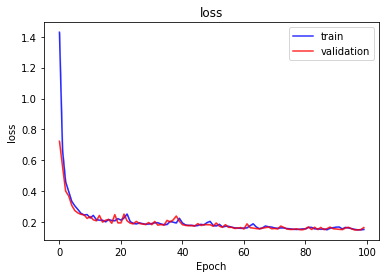

<b>bioma_loss</b>: 0.0362 (min: 0.0362, max: 0.0362)

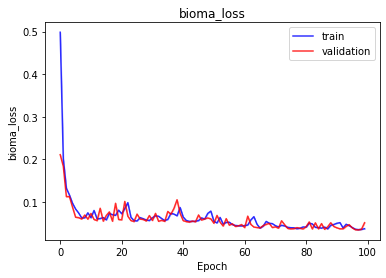

<b>domain_loss</b>: 0.1024 (min: 0.1024, max: 0.1024)

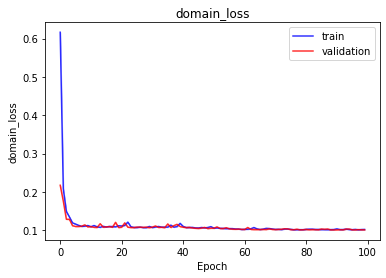

<b>latent_loss</b>: 0.0154 (min: 0.0154, max: 0.0154)

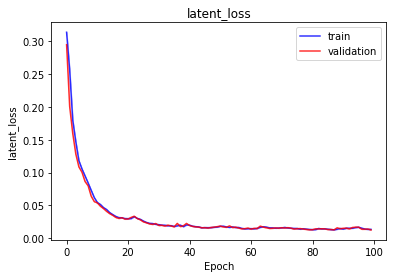

<b>bioma_mse</b>: 2787705344.0000 (min: 2787705344.0000, max: 2787705344.0000)

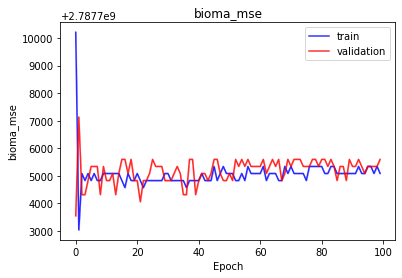

<b>bioma_mae</b>: 9028.4551 (min: 9028.4551, max: 9028.4551)

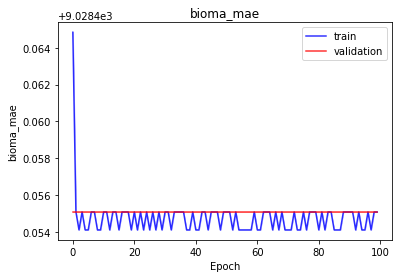

<b>bioma_mape</b>: 23864.4648 (min: 23864.4648, max: 23864.4648)

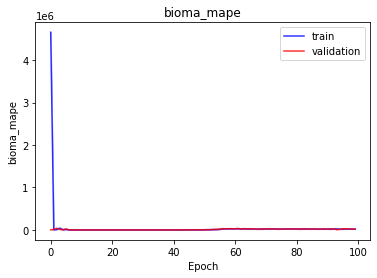

<b>bioma_BrayCurtis</b>: 0.0362 (min: 0.0362, max: 0.0362)

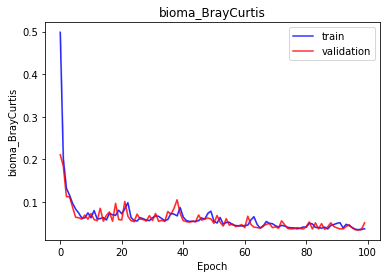

<b>bioma_pearson_corr</b>: 0.9980 (min: 0.9980, max: 0.9980)

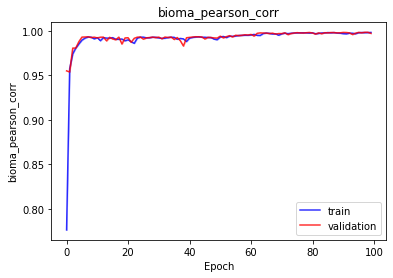

<b>bioma_jensen_shannon_divergence</b>: 0.0465 (min: 0.0465, max: 0.0465)

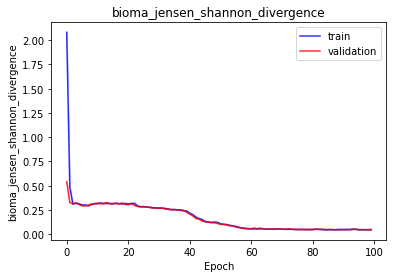

<b>domain_mse</b>: 2787705344.0000 (min: 2787705344.0000, max: 2787705344.0000)

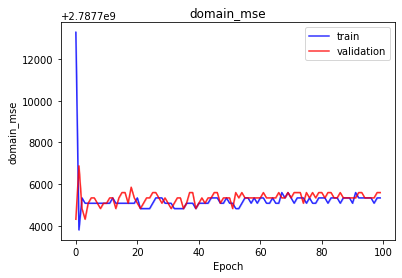

<b>domain_mae</b>: 9028.4551 (min: 9028.4551, max: 9028.4551)

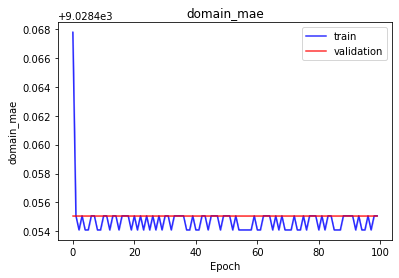

<b>domain_mape</b>: 17789.0469 (min: 17789.0469, max: 17789.0469)

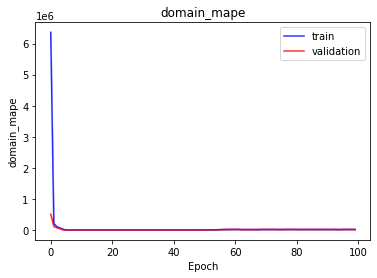

<b>domain_BrayCurtis</b>: 0.1024 (min: 0.1024, max: 0.1024)

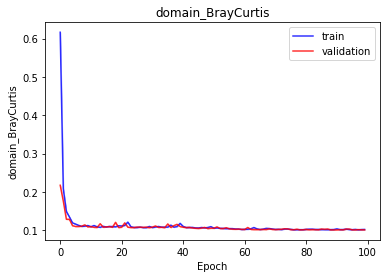

<b>domain_pearson_corr</b>: 0.9771 (min: 0.9771, max: 0.9771)

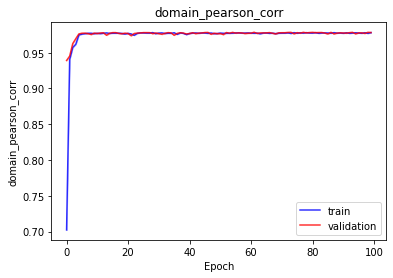

<b>domain_jensen_shannon_divergence</b>: 0.1048 (min: 0.1048, max: 0.1048)

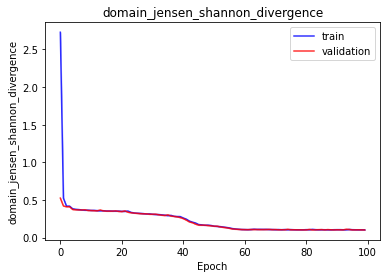

<b>latent_mae</b>: 0.0154 (min: 0.0154, max: 0.0154)

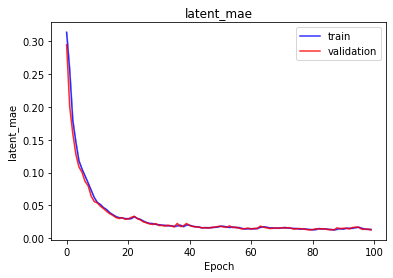

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 0.15396521985530853 | 0.15396521985530853 | 0.15396521985530853 |
| bioma_loss | 0.036227159202098846 | 0.036227159202098846 | 0.036227159202098846 |
| domain_loss | 0.1023692935705185 | 0.1023692935705185 | 0.1023692935705185 |
| latent_loss | 0.015368781983852386 | 0.015368781983852386 | 0.015368781983852386 |
| bioma_mse | 2787705344.0 | 2787705344.0 | 2787705344.0 |
| bioma_mae | 9028.455078125 | 9028.455078125 | 9028.455078125 |
| bioma_mape | 23864.46484375 | 23864.46484375 | 23864.46484375 |
| bioma_BrayCurtis | 0.036227159202098846 | 0.036227159202098846 | 0.036227159202098846 |
| bioma_pearson_corr | 0.9979507327079773 | 0.9979507327079773 | 0.9979507327079773 |
| bioma_jensen_shannon_divergence | 0.046508509665727615 | 0.046508509665727615 | 0.046508509665727615 |
| domain_mse | 2787705344.0 | 2787705344.0 | 2787705344.0 |
| domain_mae | 9028.455078125 | 9028.455078125 | 9028.455078125 |
| domain_mape | 17789.046875 | 17789.046875 | 17789.046875 |
| domain_BrayCurtis | 0.1023692935705185 | 0.1023692935705185 | 0.1023692935705185 |
| domain_pearson_corr | 0.9771167039871216 | 0.9771167039871216 | 0.9771167039871216 |
| domain_jensen_shannon_divergence | 0.10484816133975983 | 0.10484816133975983 | 0.10484816133975983 |
| latent_mae | 0.015368781983852386 | 0.015368781983852386 | 0.015368781983852386 |


*************

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.1167275682091713 | 0.1167275682091713 | 0.1167275682091713 |
| pearson_corr | 0.982600748538971 | 0.982600748538971 | 0.982600748538971 |
| jensen_shannon_divergence | 0.11192826181650162 | 0.11192826181650162 | 0.11192826181650162 |


In [42]:
experiment_metrics, models, results = perform_experiment_2_mod(cv_folds=0,
                                                               epochs=100,
                                                               batch_size=64,
                                                               learning_rate=0.001,
                                                               optimizer=optimizers.Adam,
                                                               learning_rate_scheduler=None,
                                                               input_transform=Percentage,
                                                               output_transform=tf.keras.layers.Softmax,
                                                               reconstruction_loss=MakeLoss(LossBrayCurtis, Percentage, None),
                                                               latent_space=15,
                                                               layers=[512,256,128],
                                                               activation='tanh',
                                                               activation_latent='tanh',
                                                               data_microbioma_train=data_microbioma_train,
                                                               data_domain_train=data_domain_train,
                                                               show_results=True,
                                                               device='/CPU:0')
    
#Guardamos el modelo, encoder y decoder
model, encoder, _ ,decoder = models[0]
  
def model_fn_latent():
    in_layer = layers.Input(shape=(data_domain_train.shape[1],))
    net = layers.Dense(128, activation='tanh')(in_layer)
    net = layers.Dense(64, activation='tanh')(net)
    net = layers.Dense(32, activation='tanh')(net)
    net = layers.Dense(16, activation='tanh')(net)
    out_layer = layers.Dense(latent_train.shape[1], activation='tanh')(net)
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    model.compile(optimizer=optimizers.Adam(lr=0.001), loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.MeanSquaredError()])
    return model
    
#funcion del modelado -- por ahora lo dejaremos asi, y voy a habalr con ella par aver que cambio, que tuneo
latent_train = encoder.predict(data_microbioma_train)
    
result_latent, model_latent = train_tl_noEnsemble(model_fn_latent,
                                                  latent_train,
                                                  latent_train,
                                                  data_domain_train,
                                                  data_domain_train,
                                                  epochs=100,
                                                  batch_size=16,
                                                  verbose=-1)

#evaluamos el modelo
latent_test = encoder.predict(data_microbioma_test)
predictions = test_model_tl_noEnsemble(model_latent, decoder, Percentage, tf.keras.layers.Softmax, otu_columns, data_microbioma_test, data_domain_test)

In [43]:
encoder_biome = encoder
encoder_domain = model_latent
#Guardamos las predicciones
df_microbioma_test.T.to_csv('Results/otus_original_test_22Combined_orden.tsv', index=True, header=True, sep='\t')

#run prediction test set from microbiome, i.e, reconstructed
# Input only domain (i.e. environmental features)
pred_latent_biome = encoder_biome.predict(data_microbioma_test)
pred_biome = decoder.predict(pred_latent_biome)

_, _ = save_predicted_otu_table_and_latent(pred_biome,pred_latent_biome,df_microbioma_test.index,df_microbioma_test.columns,'reconstAEfromBiome_22Combined_orden')

#run prediction test set from domain, i.e., diet features
# Input only domain (i.e. environmental features)
pred_latent = encoder_domain.predict(data_domain_test)
pred_domain = decoder.predict(pred_latent)
df_pred_otu, df_pred_latent = save_predicted_otu_table_and_latent(pred_domain,pred_latent,df_microbioma_test.index,df_microbioma_test.columns,'predFromDomain_22Combined_orden')

#--------------------
actual_array = transform_to_rel_abundance(data_microbioma_test)
RSE_perOTU, RRSE_perOTU  = compute_relative_squared_error(actual_array,pred_domain)

df_error_perOTU = save_errors_per_OTU(RSE_perOTU,RRSE_perOTU,df_microbioma_test.columns,'Results/errors_perOTU_22Combined_orden')

In [ ]:
metrics = FI()
tabla_FI = pd.DataFrame.from_dict(metrics)
tabla_FI.to_csv("Results/nutrientes/FI/FI_Combined22_orden.csv",index=False)

### Class

In [44]:
#nombres_metadatos = ["KCAL","PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","SUGR","FIBE","CALC","IRON","MAGN","PHOS","POTA","SODI","ZINC","COPP","SELE","VC","VB1","VB2","NIAC","VB6","FOLA","VB12","VARA","RET","BCAR","ACAR","CRYP","LYCO","LZ","ATOC","VK","CHOLE","SFAT","MFAT","PFAT","VITD","CHOLN"]
nombres_metadatos = ["PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","CALC","MAGN","POTA","ZINC","VC","VB1","VB6","VARA","ACAR","CRYP","LYCO","ATOC","VK","CHOLE","VITD"]
df_microbioma_train, df_microbioma_test, _, _, \
df_domain_train, df_domain_test, _, _, otu_columns, domain_columns = read_df(metadata_names=nombres_metadatos,otu_filename='resultados_ana/nuevos_datos/arreglados/otu_table_Class.csv',metadata_filename='resultados_ana/datos_otus_metadatos_clase/metadatos_nutrientes_clase.csv')

data_microbioma_train = df_microbioma_train.to_numpy(dtype=np.float32)
data_microbioma_test = df_microbioma_test.to_numpy(dtype=np.float32)
data_domain_train = df_domain_train.to_numpy(dtype=np.float32)
data_domain_test = df_domain_test.to_numpy(dtype=np.float32)

| Parameter             | Value         |
|:----------------------|:--------------|
| Input transform | Percentage |
| Output transform | Softmax |
| Reconstruction Loss | LossBrayCurtis |
| Latent Space | 15 |
| Bioma Autoencoder | b -> 512 -> 256 -> 128 -> 15 -> 128 -> 256 -> 512 -> b |
| Domain Autoencoder | d -> 32 -> 16 -> 8 -> 15 -> 128 -> 256 -> 512 -> b |
| Activation Encoder | tanh |
| Activation Decoder | tanh |
| Activation Latent | tanh |
| CV folds | 0 |
| Epochs | 100 |
| Batch Size | 64 |
| Learning Rate Scheduler | none |
| Learning Rate | constant = 0.001 |
| Optimizer | Adam |


<p>Best iteration: <b>86</b></p>

<b>loss</b>: 0.1497 (min: 0.1497, max: 0.1497)

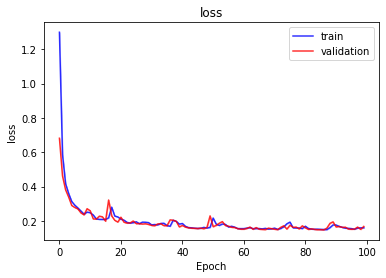

<b>bioma_loss</b>: 0.0345 (min: 0.0345, max: 0.0345)

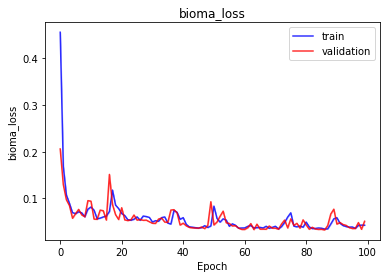

<b>domain_loss</b>: 0.1026 (min: 0.1026, max: 0.1026)

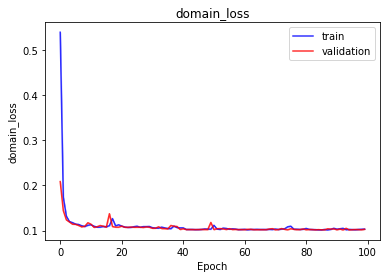

<b>latent_loss</b>: 0.0126 (min: 0.0126, max: 0.0126)

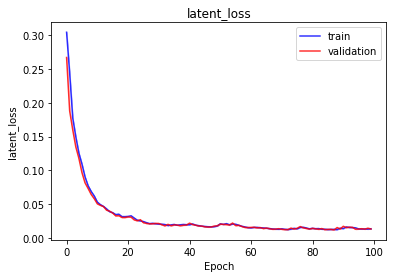

<b>bioma_mse</b>: 4695274496.0000 (min: 4695274496.0000, max: 4695274496.0000)

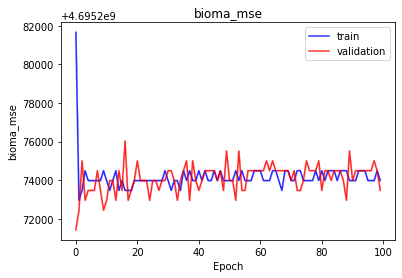

<b>bioma_mae</b>: 15206.2607 (min: 15206.2607, max: 15206.2607)

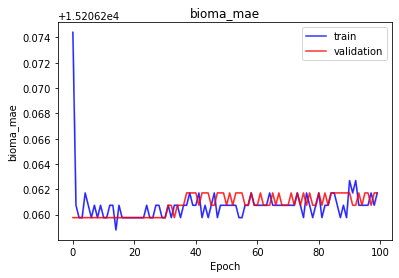

<b>bioma_mape</b>: 27774.5781 (min: 27774.5781, max: 27774.5781)

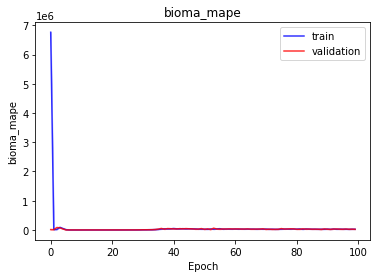

<b>bioma_BrayCurtis</b>: 0.0345 (min: 0.0345, max: 0.0345)

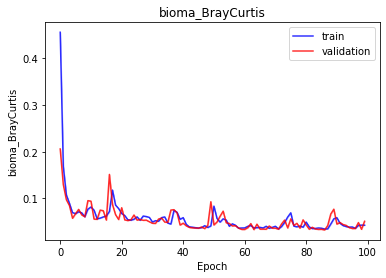

<b>bioma_pearson_corr</b>: 0.9976 (min: 0.9976, max: 0.9976)

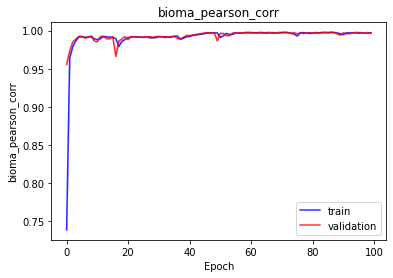

<b>bioma_jensen_shannon_divergence</b>: 0.0421 (min: 0.0421, max: 0.0421)

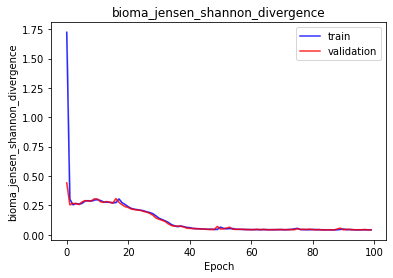

<b>domain_mse</b>: 4695274496.0000 (min: 4695274496.0000, max: 4695274496.0000)

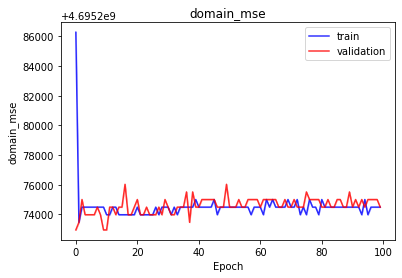

<b>domain_mae</b>: 15206.2607 (min: 15206.2607, max: 15206.2607)

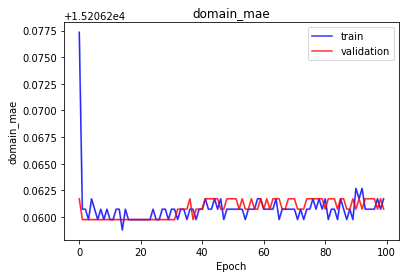

<b>domain_mape</b>: 18934.5723 (min: 18934.5723, max: 18934.5723)

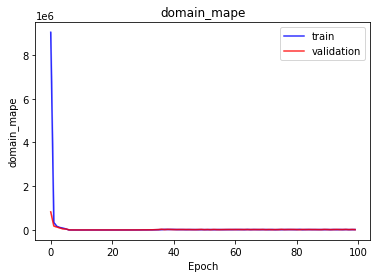

<b>domain_BrayCurtis</b>: 0.1026 (min: 0.1026, max: 0.1026)

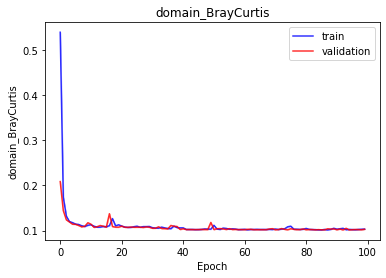

<b>domain_pearson_corr</b>: 0.9763 (min: 0.9763, max: 0.9763)

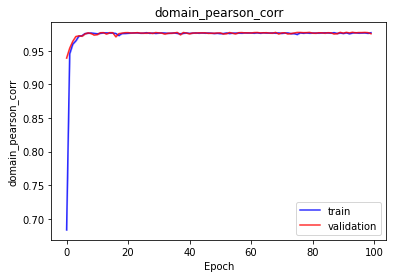

<b>domain_jensen_shannon_divergence</b>: 0.1002 (min: 0.1002, max: 0.1002)

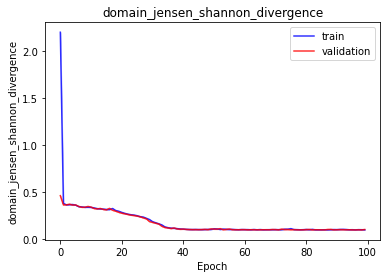

<b>latent_mae</b>: 0.0126 (min: 0.0126, max: 0.0126)

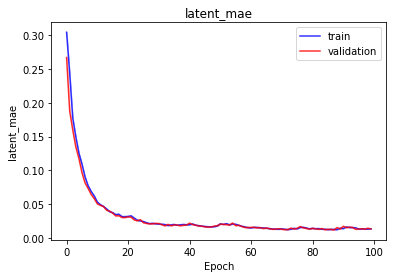

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 0.14966168999671936 | 0.14966168999671936 | 0.14966168999671936 |
| bioma_loss | 0.03451589494943619 | 0.03451589494943619 | 0.03451589494943619 |
| domain_loss | 0.10256030410528183 | 0.10256030410528183 | 0.10256030410528183 |
| latent_loss | 0.012585477903485298 | 0.012585477903485298 | 0.012585477903485298 |
| bioma_mse | 4695274496.0 | 4695274496.0 | 4695274496.0 |
| bioma_mae | 15206.2607421875 | 15206.2607421875 | 15206.2607421875 |
| bioma_mape | 27774.578125 | 27774.578125 | 27774.578125 |
| bioma_BrayCurtis | 0.03451589494943619 | 0.03451589494943619 | 0.03451589494943619 |
| bioma_pearson_corr | 0.99760502576828 | 0.99760502576828 | 0.99760502576828 |
| bioma_jensen_shannon_divergence | 0.04213784635066986 | 0.04213784635066986 | 0.04213784635066986 |
| domain_mse | 4695274496.0 | 4695274496.0 | 4695274496.0 |
| domain_mae | 15206.2607421875 | 15206.2607421875 | 15206.2607421875 |
| domain_mape | 18934.572265625 | 18934.572265625 | 18934.572265625 |
| domain_BrayCurtis | 0.10256030410528183 | 0.10256030410528183 | 0.10256030410528183 |
| domain_pearson_corr | 0.9763133525848389 | 0.9763133525848389 | 0.9763133525848389 |
| domain_jensen_shannon_divergence | 0.10018771141767502 | 0.10018771141767502 | 0.10018771141767502 |
| latent_mae | 0.012585477903485298 | 0.012585477903485298 | 0.012585477903485298 |


*************

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.11210066080093384 | 0.11210066080093384 | 0.11210066080093384 |
| pearson_corr | 0.9796147346496582 | 0.9796147346496582 | 0.9796147346496582 |
| jensen_shannon_divergence | 0.09997288882732391 | 0.09997288882732391 | 0.09997288882732391 |


In [45]:
experiment_metrics, models, results = perform_experiment_2_mod(cv_folds=0,
                                                               epochs=100,
                                                               batch_size=64,
                                                               learning_rate=0.001,
                                                               optimizer=optimizers.Adam,
                                                               learning_rate_scheduler=None,
                                                               input_transform=Percentage,
                                                               output_transform=tf.keras.layers.Softmax,
                                                               reconstruction_loss=MakeLoss(LossBrayCurtis, Percentage, None),
                                                               latent_space=15,
                                                               layers=[512,256,128],
                                                               activation='tanh',
                                                               activation_latent='tanh',
                                                               data_microbioma_train=data_microbioma_train,
                                                               data_domain_train=data_domain_train,
                                                               show_results=True,
                                                               device='/CPU:0')
    
#Guardamos el modelo, encoder y decoder
model, encoder, _ ,decoder = models[0]
  
def model_fn_latent():
    in_layer = layers.Input(shape=(data_domain_train.shape[1],))
    net = layers.Dense(128, activation='tanh')(in_layer)
    net = layers.Dense(64, activation='tanh')(net)
    net = layers.Dense(32, activation='tanh')(net)
    net = layers.Dense(16, activation='tanh')(net)
    out_layer = layers.Dense(latent_train.shape[1], activation='tanh')(net)
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    model.compile(optimizer=optimizers.Adam(lr=0.001), loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.MeanSquaredError()])
    return model
    
#funcion del modelado -- por ahora lo dejaremos asi, y voy a habalr con ella par aver que cambio, que tuneo
latent_train = encoder.predict(data_microbioma_train)
    
result_latent, model_latent = train_tl_noEnsemble(model_fn_latent,
                                                  latent_train,
                                                  latent_train,
                                                  data_domain_train,
                                                  data_domain_train,
                                                  epochs=100,
                                                  batch_size=16,
                                                  verbose=-1)

#evaluamos el modelo
latent_test = encoder.predict(data_microbioma_test)
predictions = test_model_tl_noEnsemble(model_latent, decoder, Percentage, tf.keras.layers.Softmax, otu_columns, data_microbioma_test, data_domain_test)

In [46]:
encoder_biome = encoder
encoder_domain = model_latent
#Guardamos las predicciones
df_microbioma_test.T.to_csv('Results/otus_original_test_22Combined_clase.tsv', index=True, header=True, sep='\t')

#run prediction test set from microbiome, i.e, reconstructed
# Input only domain (i.e. environmental features)
pred_latent_biome = encoder_biome.predict(data_microbioma_test)
pred_biome = decoder.predict(pred_latent_biome)

_, _ = save_predicted_otu_table_and_latent(pred_biome,pred_latent_biome,df_microbioma_test.index,df_microbioma_test.columns,'reconstAEfromBiome_22Combined_clase')

#run prediction test set from domain, i.e., diet features
# Input only domain (i.e. environmental features)
pred_latent = encoder_domain.predict(data_domain_test)
pred_domain = decoder.predict(pred_latent)
df_pred_otu, df_pred_latent = save_predicted_otu_table_and_latent(pred_domain,pred_latent,df_microbioma_test.index,df_microbioma_test.columns,'predFromDomain_22Combined_clase')

#--------------------
actual_array = transform_to_rel_abundance(data_microbioma_test)
RSE_perOTU, RRSE_perOTU  = compute_relative_squared_error(actual_array,pred_domain)

df_error_perOTU = save_errors_per_OTU(RSE_perOTU,RRSE_perOTU,df_microbioma_test.columns,'Results/errors_perOTU_22Combined_clase')

In [ ]:
metrics = FI()
tabla_FI = pd.DataFrame.from_dict(metrics)
tabla_FI.to_csv("Results/nutrientes/FI/FI_Combined22_clase.csv",index=False)

### Phylum

In [47]:
#nombres_metadatos = ["KCAL","PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","SUGR","FIBE","CALC","IRON","MAGN","PHOS","POTA","SODI","ZINC","COPP","SELE","VC","VB1","VB2","NIAC","VB6","FOLA","VB12","VARA","RET","BCAR","ACAR","CRYP","LYCO","LZ","ATOC","VK","CHOLE","SFAT","MFAT","PFAT","VITD","CHOLN"]
nombres_metadatos = ["PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","CALC","MAGN","POTA","ZINC","VC","VB1","VB6","VARA","ACAR","CRYP","LYCO","ATOC","VK","CHOLE","VITD"]
df_microbioma_train, df_microbioma_test, _, _, \
df_domain_train, df_domain_test, _, _, otu_columns, domain_columns = read_df(metadata_names=nombres_metadatos,otu_filename='resultados_ana/nuevos_datos/arreglados/otu_table_Phylum.csv',metadata_filename='resultados_ana/datos_otus_metadatos_filo/metadatos_nutrientes_filo.csv')

data_microbioma_train = df_microbioma_train.to_numpy(dtype=np.float32)
data_microbioma_test = df_microbioma_test.to_numpy(dtype=np.float32)
data_domain_train = df_domain_train.to_numpy(dtype=np.float32)
data_domain_test = df_domain_test.to_numpy(dtype=np.float32)

| Parameter             | Value         |
|:----------------------|:--------------|
| Input transform | Percentage |
| Output transform | Softmax |
| Reconstruction Loss | LossBrayCurtis |
| Latent Space | 15 |
| Bioma Autoencoder | b -> 512 -> 256 -> 128 -> 15 -> 128 -> 256 -> 512 -> b |
| Domain Autoencoder | d -> 32 -> 16 -> 8 -> 15 -> 128 -> 256 -> 512 -> b |
| Activation Encoder | tanh |
| Activation Decoder | tanh |
| Activation Latent | tanh |
| CV folds | 0 |
| Epochs | 100 |
| Batch Size | 64 |
| Learning Rate Scheduler | none |
| Learning Rate | constant = 0.001 |
| Optimizer | Adam |


<p>Best iteration: <b>93</b></p>

<b>loss</b>: 0.1474 (min: 0.1474, max: 0.1474)

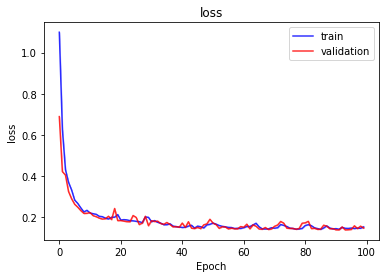

<b>bioma_loss</b>: 0.0350 (min: 0.0350, max: 0.0350)

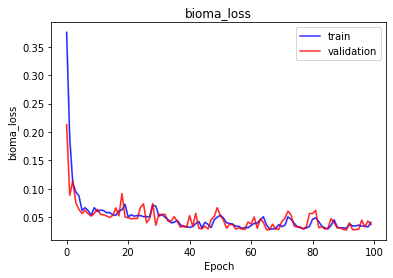

<b>domain_loss</b>: 0.0989 (min: 0.0989, max: 0.0989)

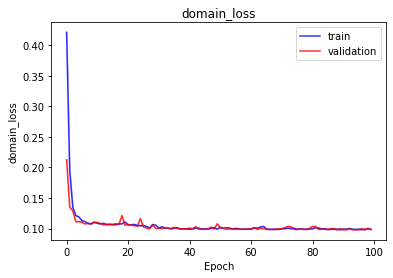

<b>latent_loss</b>: 0.0134 (min: 0.0134, max: 0.0134)

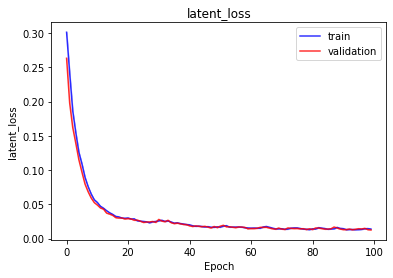

<b>bioma_mse</b>: 9952978944.0000 (min: 9952978944.0000, max: 9952978944.0000)

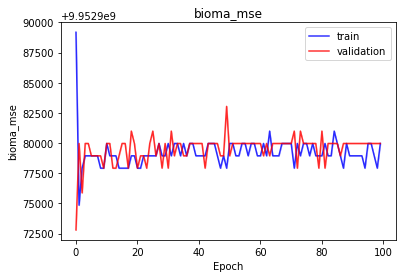

<b>bioma_mae</b>: 32181.6953 (min: 32181.6953, max: 32181.6953)

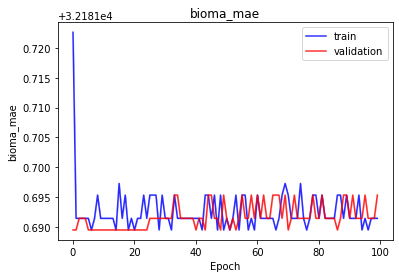

<b>bioma_mape</b>: 37470.8008 (min: 37470.8008, max: 37470.8008)

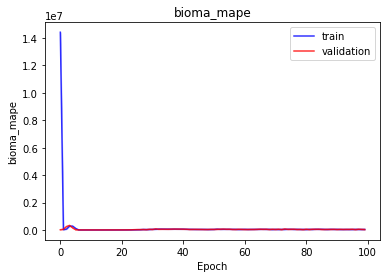

<b>bioma_BrayCurtis</b>: 0.0350 (min: 0.0350, max: 0.0350)

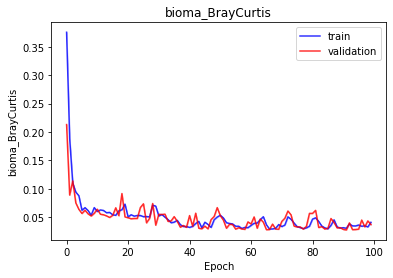

<b>bioma_pearson_corr</b>: 0.9974 (min: 0.9974, max: 0.9974)

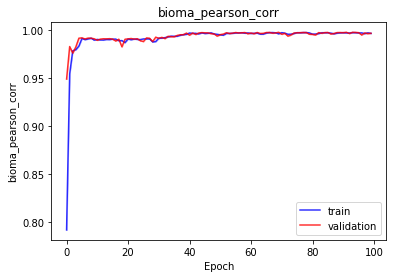

<b>bioma_jensen_shannon_divergence</b>: 0.0267 (min: 0.0267, max: 0.0267)

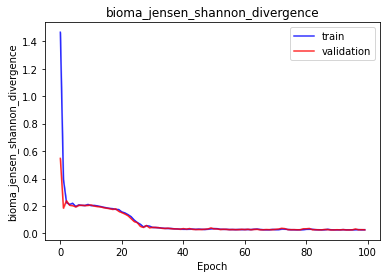

<b>domain_mse</b>: 9952979968.0000 (min: 9952979968.0000, max: 9952979968.0000)

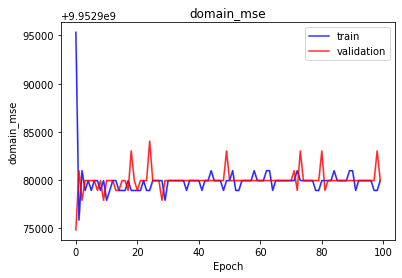

<b>domain_mae</b>: 32181.6973 (min: 32181.6973, max: 32181.6973)

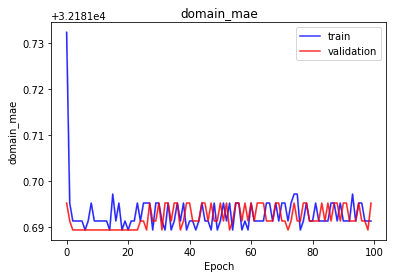

<b>domain_mape</b>: 25938.7285 (min: 25938.7285, max: 25938.7285)

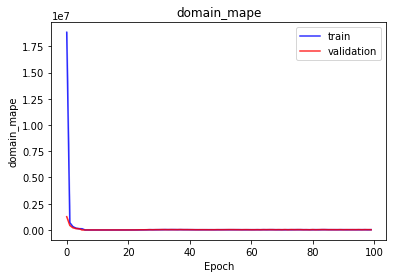

<b>domain_BrayCurtis</b>: 0.0989 (min: 0.0989, max: 0.0989)

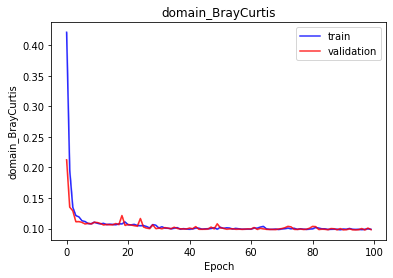

<b>domain_pearson_corr</b>: 0.9735 (min: 0.9735, max: 0.9735)

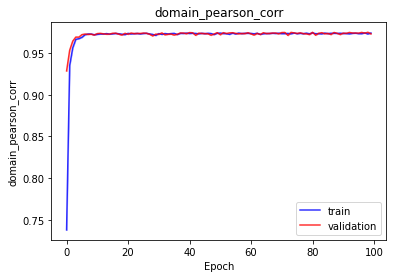

<b>domain_jensen_shannon_divergence</b>: 0.0842 (min: 0.0842, max: 0.0842)

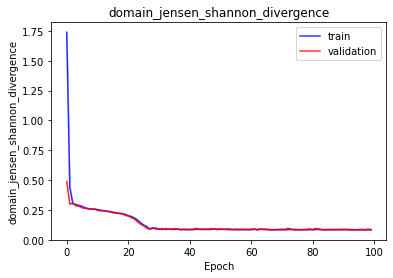

<b>latent_mae</b>: 0.0134 (min: 0.0134, max: 0.0134)

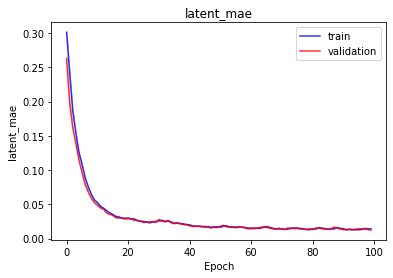

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 0.14742237329483032 | 0.14742237329483032 | 0.14742237329483032 |
| bioma_loss | 0.035045456141233444 | 0.035045456141233444 | 0.035045456141233444 |
| domain_loss | 0.09893679618835449 | 0.09893679618835449 | 0.09893679618835449 |
| latent_loss | 0.013440113514661789 | 0.013440113514661789 | 0.013440113514661789 |
| bioma_mse | 9952978944.0 | 9952978944.0 | 9952978944.0 |
| bioma_mae | 32181.6953125 | 32181.6953125 | 32181.6953125 |
| bioma_mape | 37470.80078125 | 37470.80078125 | 37470.80078125 |
| bioma_BrayCurtis | 0.035045456141233444 | 0.035045456141233444 | 0.035045456141233444 |
| bioma_pearson_corr | 0.9973728656768799 | 0.9973728656768799 | 0.9973728656768799 |
| bioma_jensen_shannon_divergence | 0.02666463889181614 | 0.02666463889181614 | 0.02666463889181614 |
| domain_mse | 9952979968.0 | 9952979968.0 | 9952979968.0 |
| domain_mae | 32181.697265625 | 32181.697265625 | 32181.697265625 |
| domain_mape | 25938.728515625 | 25938.728515625 | 25938.728515625 |
| domain_BrayCurtis | 0.09893679618835449 | 0.09893679618835449 | 0.09893679618835449 |
| domain_pearson_corr | 0.9734976291656494 | 0.9734976291656494 | 0.9734976291656494 |
| domain_jensen_shannon_divergence | 0.0842181146144867 | 0.0842181146144867 | 0.0842181146144867 |
| latent_mae | 0.013440113514661789 | 0.013440113514661789 | 0.013440113514661789 |


*************

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.10859542340040207 | 0.10859542340040207 | 0.10859542340040207 |
| pearson_corr | 0.9781590700149536 | 0.9781590700149536 | 0.9781590700149536 |
| jensen_shannon_divergence | 0.08272996544837952 | 0.08272996544837952 | 0.08272996544837952 |


In [48]:
experiment_metrics, models, results = perform_experiment_2_mod(cv_folds=0,
                                                               epochs=100,
                                                               batch_size=64,
                                                               learning_rate=0.001,
                                                               optimizer=optimizers.Adam,
                                                               learning_rate_scheduler=None,
                                                               input_transform=Percentage,
                                                               output_transform=tf.keras.layers.Softmax,
                                                               reconstruction_loss=MakeLoss(LossBrayCurtis, Percentage, None),
                                                               latent_space=15,
                                                               layers=[512,256,128],
                                                               activation='tanh',
                                                               activation_latent='tanh',
                                                               data_microbioma_train=data_microbioma_train,
                                                               data_domain_train=data_domain_train,
                                                               show_results=True,
                                                               device='/CPU:0')
    
#Guardamos el modelo, encoder y decoder
model, encoder, _ ,decoder = models[0]
  
def model_fn_latent():
    in_layer = layers.Input(shape=(data_domain_train.shape[1],))
    net = layers.Dense(128, activation='tanh')(in_layer)
    net = layers.Dense(64, activation='tanh')(net)
    net = layers.Dense(32, activation='tanh')(net)
    net = layers.Dense(16, activation='tanh')(net)
    out_layer = layers.Dense(latent_train.shape[1], activation='tanh')(net)
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    model.compile(optimizer=optimizers.Adam(lr=0.001), loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.MeanSquaredError()])
    return model
    
#funcion del modelado -- por ahora lo dejaremos asi, y voy a habalr con ella par aver que cambio, que tuneo
latent_train = encoder.predict(data_microbioma_train)
    
result_latent, model_latent = train_tl_noEnsemble(model_fn_latent,
                                                  latent_train,
                                                  latent_train,
                                                  data_domain_train,
                                                  data_domain_train,
                                                  epochs=100,
                                                  batch_size=16,
                                                  verbose=-1)

#evaluamos el modelo
latent_test = encoder.predict(data_microbioma_test)
predictions = test_model_tl_noEnsemble(model_latent, decoder, Percentage, tf.keras.layers.Softmax, otu_columns, data_microbioma_test, data_domain_test)

In [49]:
encoder_biome = encoder
encoder_domain = model_latent
#Guardamos las predicciones
df_microbioma_test.T.to_csv('Results/otus_original_test_22Combined_filo.tsv', index=True, header=True, sep='\t')

#run prediction test set from microbiome, i.e, reconstructed
# Input only domain (i.e. environmental features)
pred_latent_biome = encoder_biome.predict(data_microbioma_test)
pred_biome = decoder.predict(pred_latent_biome)

_, _ = save_predicted_otu_table_and_latent(pred_biome,pred_latent_biome,df_microbioma_test.index,df_microbioma_test.columns,'reconstAEfromBiome_22Combined_filo')

#run prediction test set from domain, i.e., diet features
# Input only domain (i.e. environmental features)
pred_latent = encoder_domain.predict(data_domain_test)
pred_domain = decoder.predict(pred_latent)
df_pred_otu, df_pred_latent = save_predicted_otu_table_and_latent(pred_domain,pred_latent,df_microbioma_test.index,df_microbioma_test.columns,'predFromDomain_22Combined_filo')

#--------------------
actual_array = transform_to_rel_abundance(data_microbioma_test)
RSE_perOTU, RRSE_perOTU  = compute_relative_squared_error(actual_array,pred_domain)

df_error_perOTU = save_errors_per_OTU(RSE_perOTU,RRSE_perOTU,df_microbioma_test.columns,'Results/errors_perOTU_22Combined_filo')

In [ ]:
metrics = FI()
tabla_FI = pd.DataFrame.from_dict(metrics)
tabla_FI.to_csv("Results/nutrientes/FI/FI_Combined22_filo.csv",index=False)

--------------------------
# 22 variables Latent OTU

### Genus

In [50]:
#nombres_metadatos = ["KCAL","PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","SUGR","FIBE","CALC","IRON","MAGN","PHOS","POTA","SODI","ZINC","COPP","SELE","VC","VB1","VB2","NIAC","VB6","FOLA","VB12","VARA","RET","BCAR","ACAR","CRYP","LYCO","LZ","ATOC","VK","CHOLE","SFAT","MFAT","PFAT","VITD","CHOLN"]
nombres_metadatos = ["PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","CALC","MAGN","POTA","ZINC","VC","VB1","VB6","VARA","ACAR","CRYP","LYCO","ATOC","VK","CHOLE","VITD"]
df_microbioma_train, df_microbioma_test, _, _, \
df_domain_train, df_domain_test, _, _, otu_columns, domain_columns = read_df(metadata_names=nombres_metadatos,otu_filename='resultados_ana/nuevos_datos/arreglados/otu_table_Genus.csv',metadata_filename='resultados_ana/datos_otus_metadatos_genero/metadatos_nutrientes_genero.csv')

data_microbioma_train = df_microbioma_train.to_numpy(dtype=np.float32)
data_microbioma_test = df_microbioma_test.to_numpy(dtype=np.float32)
data_domain_train = df_domain_train.to_numpy(dtype=np.float32)
data_domain_test = df_domain_test.to_numpy(dtype=np.float32)

| Parameter             | Value         |
|:----------------------|:--------------|
| Input transform | Percentage |
| Output transform | Softmax |
| Reconstruction Loss | LossBrayCurtis |
| Latent Space | 15 |
| Bioma Autoencoder | b -> 512 -> 256 -> 15 -> 256 -> 512 -> b |
| Domain Autoencoder | d -> 32 -> 16 -> 15 -> 256 -> 512 -> b |
| Activation Encoder | tanh |
| Activation Decoder | tanh |
| Activation Latent | tanh |
| CV folds | 0 |
| Epochs | 100 |
| Batch Size | 64 |
| Learning Rate Scheduler | none |
| Learning Rate | constant = 0.001 |
| Optimizer | Adam |


<p>Best iteration: <b>99</b></p>

<b>loss</b>: 0.3976 (min: 0.3976, max: 0.3976)

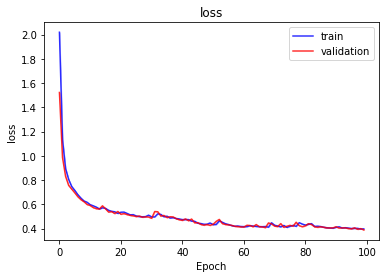

<b>bioma_loss</b>: 0.1064 (min: 0.1064, max: 0.1064)

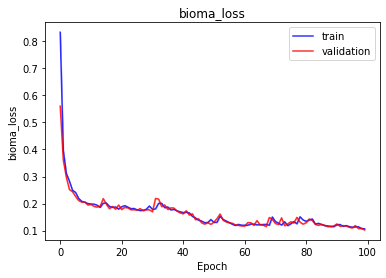

<b>domain_loss</b>: 0.2653 (min: 0.2653, max: 0.2653)

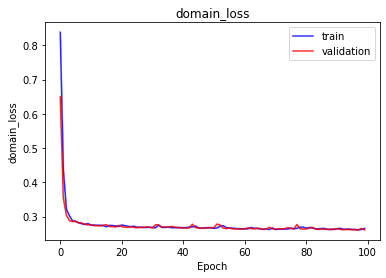

<b>latent_loss</b>: 0.0259 (min: 0.0259, max: 0.0259)

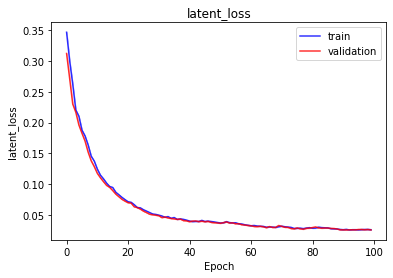

<b>bioma_mse</b>: 303918080.0000 (min: 303918080.0000, max: 303918080.0000)

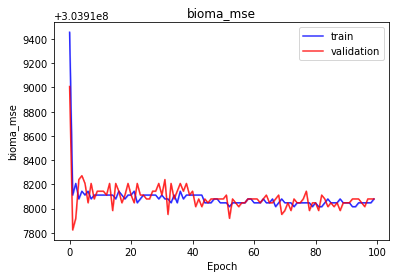

<b>bioma_mae</b>: 1614.6122 (min: 1614.6122, max: 1614.6122)

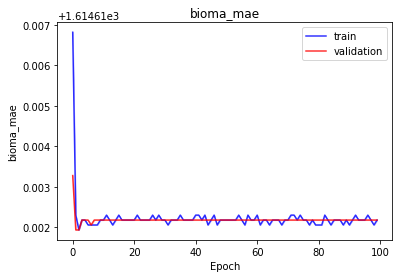

<b>bioma_mape</b>: 14455.8613 (min: 14455.8613, max: 14455.8613)

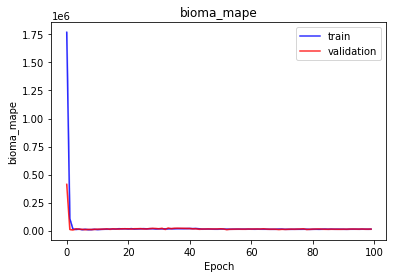

<b>bioma_BrayCurtis</b>: 0.1064 (min: 0.1064, max: 0.1064)

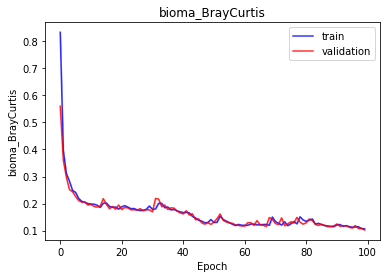

<b>bioma_pearson_corr</b>: 0.9906 (min: 0.9906, max: 0.9906)

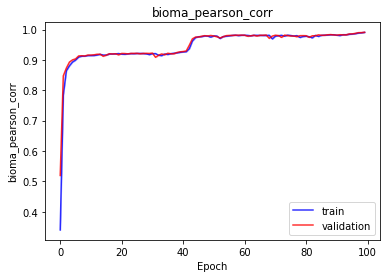

<b>bioma_jensen_shannon_divergence</b>: 0.1850 (min: 0.1850, max: 0.1850)

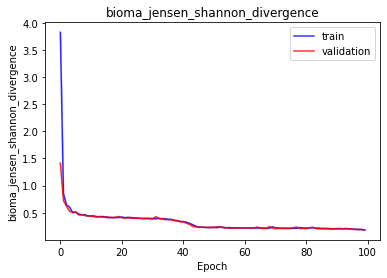

<b>domain_mse</b>: 303918240.0000 (min: 303918240.0000, max: 303918240.0000)

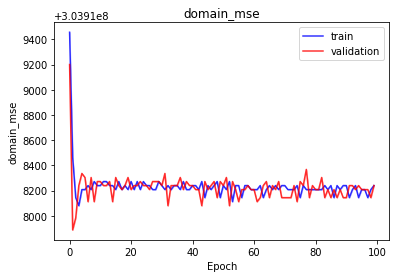

<b>domain_mae</b>: 1614.6122 (min: 1614.6122, max: 1614.6122)

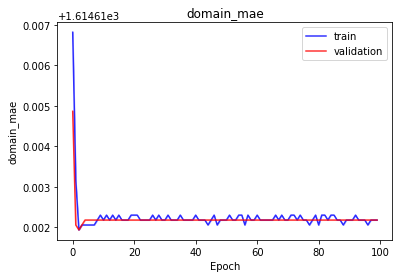

<b>domain_mape</b>: 14127.0117 (min: 14127.0117, max: 14127.0117)

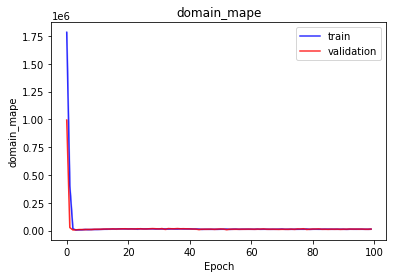

<b>domain_BrayCurtis</b>: 0.2653 (min: 0.2653, max: 0.2653)

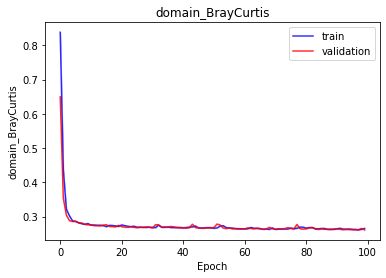

<b>domain_pearson_corr</b>: 0.8803 (min: 0.8803, max: 0.8803)

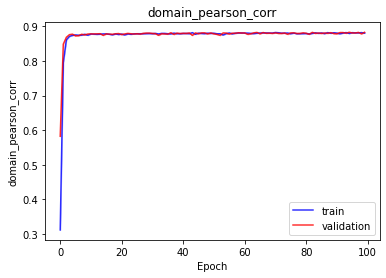

<b>domain_jensen_shannon_divergence</b>: 0.5303 (min: 0.5303, max: 0.5303)

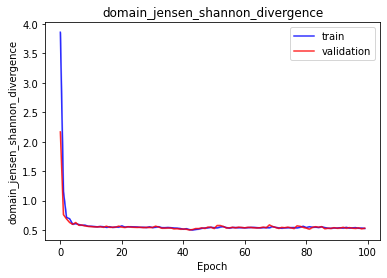

<b>latent_mae</b>: 0.0259 (min: 0.0259, max: 0.0259)

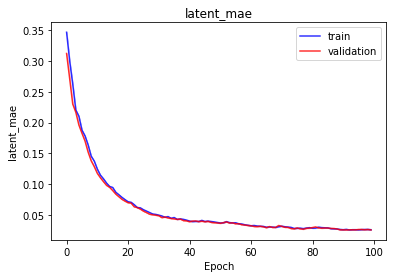

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 0.39755013585090637 | 0.39755013585090637 | 0.39755013585090637 |
| bioma_loss | 0.10640627145767212 | 0.10640627145767212 | 0.10640627145767212 |
| domain_loss | 0.26528477668762207 | 0.26528477668762207 | 0.26528477668762207 |
| latent_loss | 0.025859065353870392 | 0.025859065353870392 | 0.025859065353870392 |
| bioma_mse | 303918080.0 | 303918080.0 | 303918080.0 |
| bioma_mae | 1614.6121826171875 | 1614.6121826171875 | 1614.6121826171875 |
| bioma_mape | 14455.861328125 | 14455.861328125 | 14455.861328125 |
| bioma_BrayCurtis | 0.10640627145767212 | 0.10640627145767212 | 0.10640627145767212 |
| bioma_pearson_corr | 0.9906018376350403 | 0.9906018376350403 | 0.9906018376350403 |
| bioma_jensen_shannon_divergence | 0.18496882915496826 | 0.18496882915496826 | 0.18496882915496826 |
| domain_mse | 303918240.0 | 303918240.0 | 303918240.0 |
| domain_mae | 1614.6121826171875 | 1614.6121826171875 | 1614.6121826171875 |
| domain_mape | 14127.01171875 | 14127.01171875 | 14127.01171875 |
| domain_BrayCurtis | 0.26528477668762207 | 0.26528477668762207 | 0.26528477668762207 |
| domain_pearson_corr | 0.8802980780601501 | 0.8802980780601501 | 0.8802980780601501 |
| domain_jensen_shannon_divergence | 0.5302714705467224 | 0.5302714705467224 | 0.5302714705467224 |
| latent_mae | 0.025859065353870392 | 0.025859065353870392 | 0.025859065353870392 |


*************

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.28501880168914795 | 0.28501880168914795 | 0.28501880168914795 |
| pearson_corr | 0.8763918876647949 | 0.8763918876647949 | 0.8763918876647949 |
| jensen_shannon_divergence | 0.5235233902931213 | 0.5235233902931213 | 0.5235233902931213 |


In [51]:
experiment_metrics, models, results = perform_experiment_2_mod(cv_folds=0,
                                                               epochs=100,
                                                               batch_size=64,
                                                               learning_rate=0.001,
                                                               optimizer=optimizers.Adam,
                                                               learning_rate_scheduler=None,
                                                               input_transform=Percentage,
                                                               output_transform=tf.keras.layers.Softmax,
                                                               reconstruction_loss=MakeLoss(LossBrayCurtis, Percentage, None),
                                                               latent_space=15,
                                                               layers=[512,256],
                                                               activation='tanh',
                                                               activation_latent='tanh',
                                                               data_microbioma_train=data_microbioma_train,
                                                               data_domain_train=data_domain_train,
                                                               show_results=True,
                                                               device='/CPU:0')
    
#Guardamos el modelo, encoder y decoder
model, encoder, _ ,decoder = models[0]
  
def model_fn_latent():
    in_layer = layers.Input(shape=(data_domain_train.shape[1],))
    net = layers.Dense(128, activation='sigmoid')(in_layer)
    net = layers.Dense(64, activation='sigmoid')(net)
    net = layers.Dense(32, activation='sigmoid')(net)
    net = layers.Dense(16, activation='sigmoid')(net)
    out_layer = layers.Dense(latent_train.shape[1], activation='tanh')(net)
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    model.compile(optimizer=optimizers.Adam(lr=0.001), loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.MeanSquaredError()])
    return model
    
#funcion del modelado -- por ahora lo dejaremos asi, y voy a habalr con ella par aver que cambio, que tuneo
latent_train = encoder.predict(data_microbioma_train)
    
result_latent, model_latent = train_tl_noEnsemble(model_fn_latent,
                                                  latent_train,
                                                  latent_train,
                                                  data_domain_train,
                                                  data_domain_train,
                                                  epochs=100,
                                                  batch_size=16,
                                                  verbose=-1)

#evaluamos el modelo
latent_test = encoder.predict(data_microbioma_test)
predictions = test_model_tl_noEnsemble(model_latent, decoder, Percentage, tf.keras.layers.Softmax, otu_columns, data_microbioma_test, data_domain_test)

In [52]:
encoder_biome = encoder
encoder_domain = model_latent
#Guardamos las predicciones
df_microbioma_test.T.to_csv('Results/otus_original_test_22OTU_genero.tsv', index=True, header=True, sep='\t')

#run prediction test set from microbiome, i.e, reconstructed
# Input only domain (i.e. environmental features)
pred_latent_biome = encoder_biome.predict(data_microbioma_test)
pred_biome = decoder.predict(pred_latent_biome)

_, _ = save_predicted_otu_table_and_latent(pred_biome,pred_latent_biome,df_microbioma_test.index,df_microbioma_test.columns,'reconstAEfromBiome_22OTU_genero')

#run prediction test set from domain, i.e., diet features
# Input only domain (i.e. environmental features)
pred_latent = encoder_domain.predict(data_domain_test)
pred_domain = decoder.predict(pred_latent)
df_pred_otu, df_pred_latent = save_predicted_otu_table_and_latent(pred_domain,pred_latent,df_microbioma_test.index,df_microbioma_test.columns,'predFromDomain_22OTU_genero')

#--------------------
actual_array = transform_to_rel_abundance(data_microbioma_test)
RSE_perOTU, RRSE_perOTU  = compute_relative_squared_error(actual_array,pred_domain)

df_error_perOTU = save_errors_per_OTU(RSE_perOTU,RRSE_perOTU,df_microbioma_test.columns,'Results/errors_perOTU_22OTU_genero')

In [ ]:
metrics = FI()
tabla_FI = pd.DataFrame.from_dict(metrics)
tabla_FI.to_csv("Results/nutrientes/FI/FI_OTU22_genus.csv",index=False)

### Family

In [53]:
#nombres_metadatos = ["KCAL","PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","SUGR","FIBE","CALC","IRON","MAGN","PHOS","POTA","SODI","ZINC","COPP","SELE","VC","VB1","VB2","NIAC","VB6","FOLA","VB12","VARA","RET","BCAR","ACAR","CRYP","LYCO","LZ","ATOC","VK","CHOLE","SFAT","MFAT","PFAT","VITD","CHOLN"]
nombres_metadatos = ["PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","CALC","MAGN","POTA","ZINC","VC","VB1","VB6","VARA","ACAR","CRYP","LYCO","ATOC","VK","CHOLE","VITD"]
df_microbioma_train, df_microbioma_test, _, _, \
df_domain_train, df_domain_test, _, _, otu_columns, domain_columns = read_df(metadata_names=nombres_metadatos,otu_filename='resultados_ana/nuevos_datos/arreglados/otu_table_Family.csv',metadata_filename='resultados_ana/datos_otus_metadatos_familia/metadatos_nutrientes_familia.csv')

data_microbioma_train = df_microbioma_train.to_numpy(dtype=np.float32)
data_microbioma_test = df_microbioma_test.to_numpy(dtype=np.float32)
data_domain_train = df_domain_train.to_numpy(dtype=np.float32)
data_domain_test = df_domain_test.to_numpy(dtype=np.float32)

| Parameter             | Value         |
|:----------------------|:--------------|
| Input transform | Percentage |
| Output transform | Softmax |
| Reconstruction Loss | LossBrayCurtis |
| Latent Space | 15 |
| Bioma Autoencoder | b -> 512 -> 256 -> 15 -> 256 -> 512 -> b |
| Domain Autoencoder | d -> 32 -> 16 -> 15 -> 256 -> 512 -> b |
| Activation Encoder | tanh |
| Activation Decoder | tanh |
| Activation Latent | tanh |
| CV folds | 0 |
| Epochs | 100 |
| Batch Size | 64 |
| Learning Rate Scheduler | none |
| Learning Rate | constant = 0.001 |
| Optimizer | Adam |


<p>Best iteration: <b>97</b></p>

<b>loss</b>: 0.3765 (min: 0.3765, max: 0.3765)

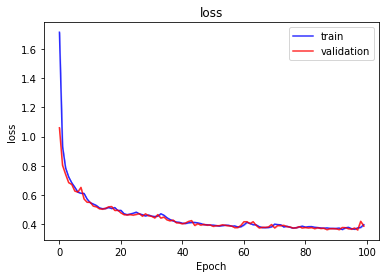

<b>bioma_loss</b>: 0.0983 (min: 0.0983, max: 0.0983)

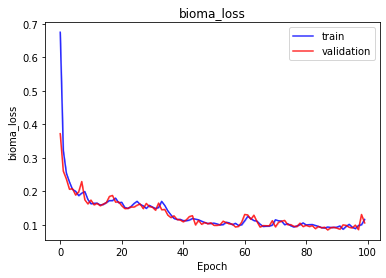

<b>domain_loss</b>: 0.2506 (min: 0.2506, max: 0.2506)

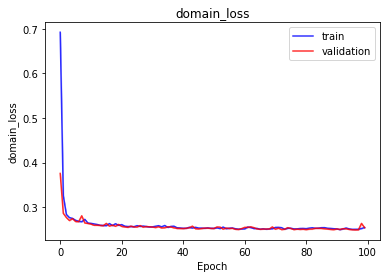

<b>latent_loss</b>: 0.0277 (min: 0.0277, max: 0.0277)

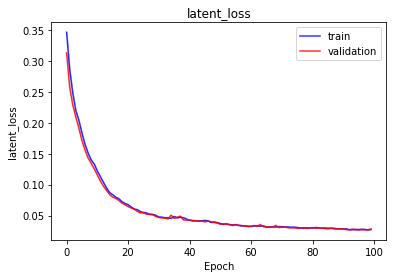

<b>bioma_mse</b>: 878693696.0000 (min: 878693696.0000, max: 878693696.0000)

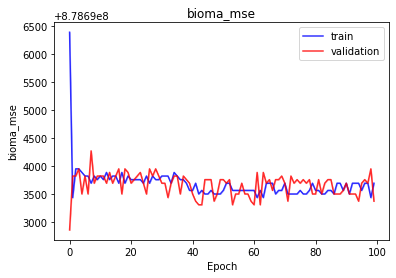

<b>bioma_mae</b>: 4677.9312 (min: 4677.9312, max: 4677.9312)

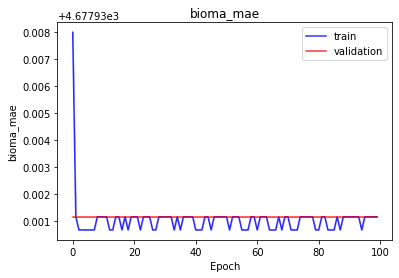

<b>bioma_mape</b>: 20856.3125 (min: 20856.3125, max: 20856.3125)

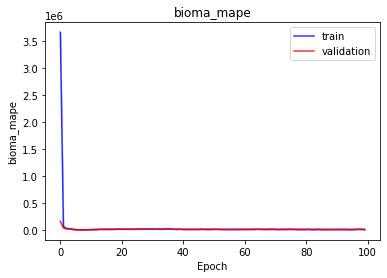

<b>bioma_BrayCurtis</b>: 0.0983 (min: 0.0983, max: 0.0983)

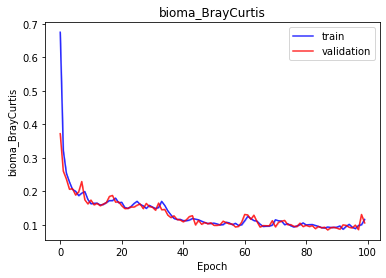

<b>bioma_pearson_corr</b>: 0.9865 (min: 0.9865, max: 0.9865)

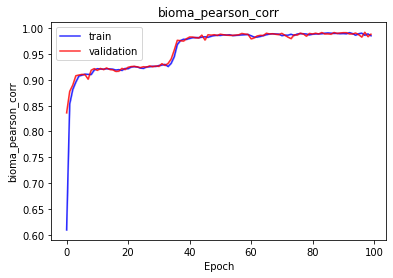

<b>bioma_jensen_shannon_divergence</b>: 0.1174 (min: 0.1174, max: 0.1174)

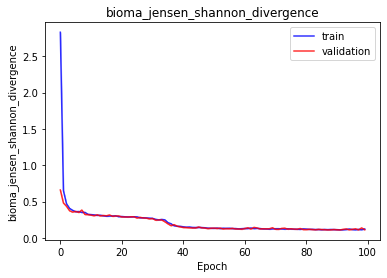

<b>domain_mse</b>: 878694016.0000 (min: 878694016.0000, max: 878694016.0000)

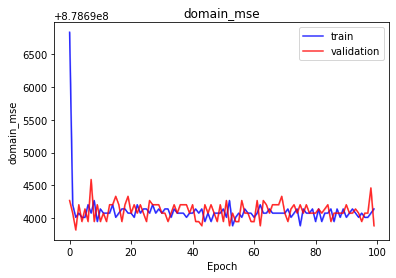

<b>domain_mae</b>: 4677.9312 (min: 4677.9312, max: 4677.9312)

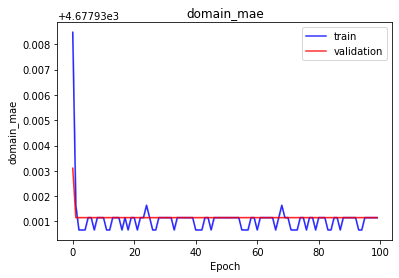

<b>domain_mape</b>: 17913.9238 (min: 17913.9238, max: 17913.9238)

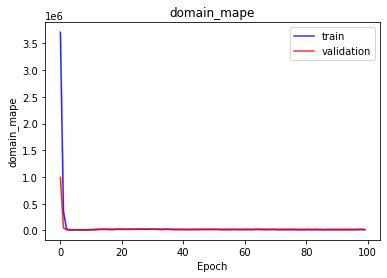

<b>domain_BrayCurtis</b>: 0.2506 (min: 0.2506, max: 0.2506)

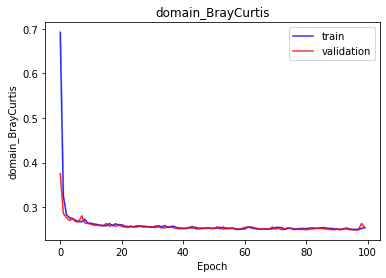

<b>domain_pearson_corr</b>: 0.8745 (min: 0.8745, max: 0.8745)

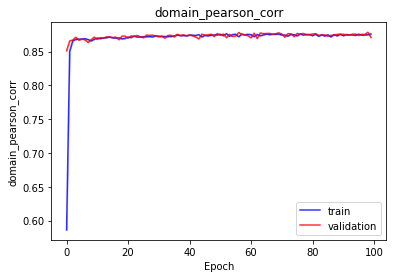

<b>domain_jensen_shannon_divergence</b>: 0.4207 (min: 0.4207, max: 0.4207)

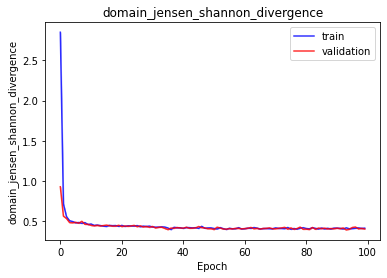

<b>latent_mae</b>: 0.0277 (min: 0.0277, max: 0.0277)

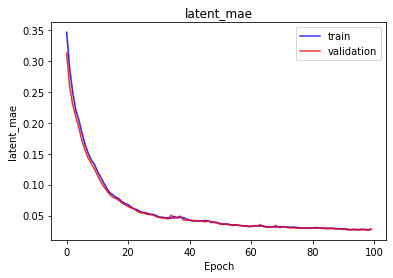

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 0.376529723405838 | 0.376529723405838 | 0.376529723405838 |
| bioma_loss | 0.09825997799634933 | 0.09825997799634933 | 0.09825997799634933 |
| domain_loss | 0.2506084144115448 | 0.2506084144115448 | 0.2506084144115448 |
| latent_loss | 0.027661342173814774 | 0.027661342173814774 | 0.027661342173814774 |
| bioma_mse | 878693696.0 | 878693696.0 | 878693696.0 |
| bioma_mae | 4677.93115234375 | 4677.93115234375 | 4677.93115234375 |
| bioma_mape | 20856.3125 | 20856.3125 | 20856.3125 |
| bioma_BrayCurtis | 0.09825997799634933 | 0.09825997799634933 | 0.09825997799634933 |
| bioma_pearson_corr | 0.9864627122879028 | 0.9864627122879028 | 0.9864627122879028 |
| bioma_jensen_shannon_divergence | 0.11743747442960739 | 0.11743747442960739 | 0.11743747442960739 |
| domain_mse | 878694016.0 | 878694016.0 | 878694016.0 |
| domain_mae | 4677.93115234375 | 4677.93115234375 | 4677.93115234375 |
| domain_mape | 17913.923828125 | 17913.923828125 | 17913.923828125 |
| domain_BrayCurtis | 0.2506084144115448 | 0.2506084144115448 | 0.2506084144115448 |
| domain_pearson_corr | 0.8744795322418213 | 0.8744795322418213 | 0.8744795322418213 |
| domain_jensen_shannon_divergence | 0.4207179844379425 | 0.4207179844379425 | 0.4207179844379425 |
| latent_mae | 0.027661342173814774 | 0.027661342173814774 | 0.027661342173814774 |


*************

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.281065970659256 | 0.281065970659256 | 0.281065970659256 |
| pearson_corr | 0.8639838099479675 | 0.8639838099479675 | 0.8639838099479675 |
| jensen_shannon_divergence | 0.4156169891357422 | 0.4156169891357422 | 0.4156169891357422 |


In [54]:
experiment_metrics, models, results = perform_experiment_2_mod(cv_folds=0,
                                                               epochs=100,
                                                               batch_size=64,
                                                               learning_rate=0.001,
                                                               optimizer=optimizers.Adam,
                                                               learning_rate_scheduler=None,
                                                               input_transform=Percentage,
                                                               output_transform=tf.keras.layers.Softmax,
                                                               reconstruction_loss=MakeLoss(LossBrayCurtis, Percentage, None),
                                                               latent_space=15,
                                                               layers=[512,256],
                                                               activation='tanh',
                                                               activation_latent='tanh',
                                                               data_microbioma_train=data_microbioma_train,
                                                               data_domain_train=data_domain_train,
                                                               show_results=True,
                                                               device='/CPU:0')
    
#Guardamos el modelo, encoder y decoder
model, encoder, _ ,decoder = models[0]
  
def model_fn_latent():
    in_layer = layers.Input(shape=(data_domain_train.shape[1],))
    net = layers.Dense(128, activation='sigmoid')(in_layer)
    net = layers.Dense(64, activation='sigmoid')(net)
    net = layers.Dense(32, activation='sigmoid')(net)
    net = layers.Dense(16, activation='sigmoid')(net)
    out_layer = layers.Dense(latent_train.shape[1], activation='tanh')(net)
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    model.compile(optimizer=optimizers.Adam(lr=0.001), loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.MeanSquaredError()])
    return model
    
#funcion del modelado -- por ahora lo dejaremos asi, y voy a habalr con ella par aver que cambio, que tuneo
latent_train = encoder.predict(data_microbioma_train)
    
result_latent, model_latent = train_tl_noEnsemble(model_fn_latent,
                                                  latent_train,
                                                  latent_train,
                                                  data_domain_train,
                                                  data_domain_train,
                                                  epochs=100,
                                                  batch_size=16,
                                                  verbose=-1)

#evaluamos el modelo
latent_test = encoder.predict(data_microbioma_test)
predictions = test_model_tl_noEnsemble(model_latent, decoder, Percentage, tf.keras.layers.Softmax, otu_columns, data_microbioma_test, data_domain_test)

In [55]:
encoder_biome = encoder
encoder_domain = model_latent
#Guardamos las predicciones
df_microbioma_test.T.to_csv('Results/otus_original_test_22OTU_familia.tsv', index=True, header=True, sep='\t')

#run prediction test set from microbiome, i.e, reconstructed
# Input only domain (i.e. environmental features)
pred_latent_biome = encoder_biome.predict(data_microbioma_test)
pred_biome = decoder.predict(pred_latent_biome)

_, _ = save_predicted_otu_table_and_latent(pred_biome,pred_latent_biome,df_microbioma_test.index,df_microbioma_test.columns,'reconstAEfromBiome_22OTU_familia')

#run prediction test set from domain, i.e., diet features
# Input only domain (i.e. environmental features)
pred_latent = encoder_domain.predict(data_domain_test)
pred_domain = decoder.predict(pred_latent)
df_pred_otu, df_pred_latent = save_predicted_otu_table_and_latent(pred_domain,pred_latent,df_microbioma_test.index,df_microbioma_test.columns,'predFromDomain_22OTU_familia')

#--------------------
actual_array = transform_to_rel_abundance(data_microbioma_test)
RSE_perOTU, RRSE_perOTU  = compute_relative_squared_error(actual_array,pred_domain)

df_error_perOTU = save_errors_per_OTU(RSE_perOTU,RRSE_perOTU,df_microbioma_test.columns,'Results/errors_perOTU_22OTU_familia')

In [ ]:
metrics = FI()
tabla_FI = pd.DataFrame.from_dict(metrics)
tabla_FI.to_csv("Results/nutrientes/FI/FI_OTU22_familia.csv",index=False)

### Order

In [56]:
#nombres_metadatos = ["KCAL","PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","SUGR","FIBE","CALC","IRON","MAGN","PHOS","POTA","SODI","ZINC","COPP","SELE","VC","VB1","VB2","NIAC","VB6","FOLA","VB12","VARA","RET","BCAR","ACAR","CRYP","LYCO","LZ","ATOC","VK","CHOLE","SFAT","MFAT","PFAT","VITD","CHOLN"]
nombres_metadatos = ["PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","CALC","MAGN","POTA","ZINC","VC","VB1","VB6","VARA","ACAR","CRYP","LYCO","ATOC","VK","CHOLE","VITD"]
df_microbioma_train, df_microbioma_test, _, _, \
df_domain_train, df_domain_test, _, _, otu_columns, domain_columns = read_df(metadata_names=nombres_metadatos,otu_filename='resultados_ana/nuevos_datos/arreglados/otu_table_Order.csv',metadata_filename='resultados_ana/datos_otus_metadatos_orden/metadatos_nutrientes_orden.csv')

data_microbioma_train = df_microbioma_train.to_numpy(dtype=np.float32)
data_microbioma_test = df_microbioma_test.to_numpy(dtype=np.float32)
data_domain_train = df_domain_train.to_numpy(dtype=np.float32)
data_domain_test = df_domain_test.to_numpy(dtype=np.float32)

| Parameter             | Value         |
|:----------------------|:--------------|
| Input transform | Percentage |
| Output transform | Softmax |
| Reconstruction Loss | LossBrayCurtis |
| Latent Space | 15 |
| Bioma Autoencoder | b -> 512 -> 256 -> 15 -> 256 -> 512 -> b |
| Domain Autoencoder | d -> 32 -> 16 -> 15 -> 256 -> 512 -> b |
| Activation Encoder | tanh |
| Activation Decoder | tanh |
| Activation Latent | tanh |
| CV folds | 0 |
| Epochs | 100 |
| Batch Size | 64 |
| Learning Rate Scheduler | none |
| Learning Rate | constant = 0.001 |
| Optimizer | Adam |


<p>Best iteration: <b>98</b></p>

<b>loss</b>: 0.4315 (min: 0.4315, max: 0.4315)

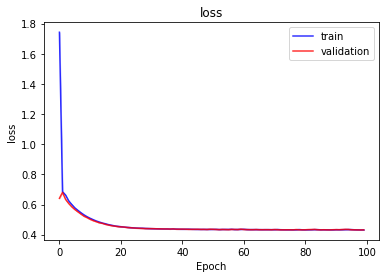

<b>bioma_loss</b>: 0.2147 (min: 0.2147, max: 0.2147)

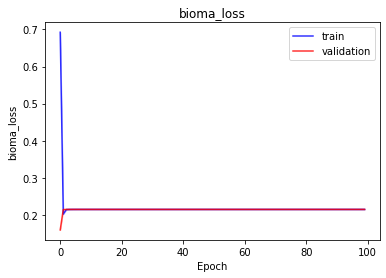

<b>domain_loss</b>: 0.2147 (min: 0.2147, max: 0.2147)

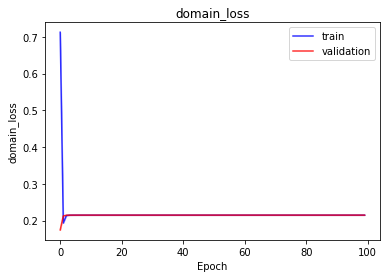

<b>latent_loss</b>: 0.0020 (min: 0.0020, max: 0.0020)

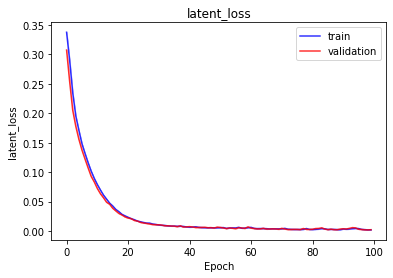

<b>bioma_mse</b>: 2787703552.0000 (min: 2787703552.0000, max: 2787703552.0000)

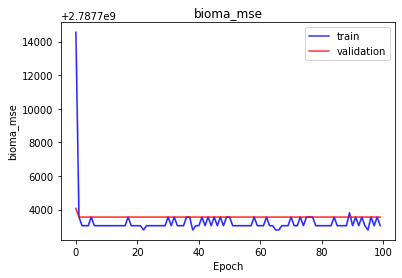

<b>bioma_mae</b>: 9028.4551 (min: 9028.4551, max: 9028.4551)

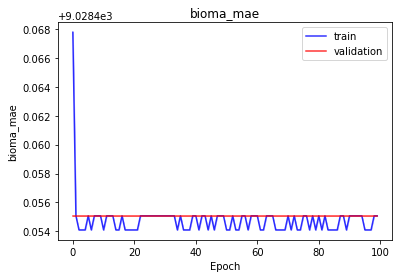

<b>bioma_mape</b>: 69.2616 (min: 69.2616, max: 69.2616)

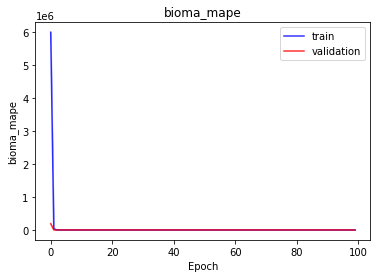

<b>bioma_BrayCurtis</b>: 0.2147 (min: 0.2147, max: 0.2147)

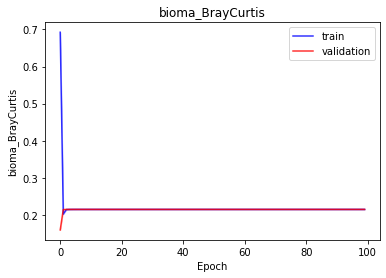

<b>bioma_pearson_corr</b>: 0.9540 (min: 0.9540, max: 0.9540)

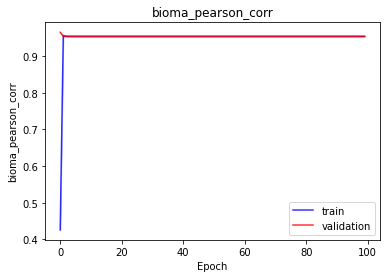

<b>bioma_jensen_shannon_divergence</b>: 1.5219 (min: 1.5219, max: 1.5219)

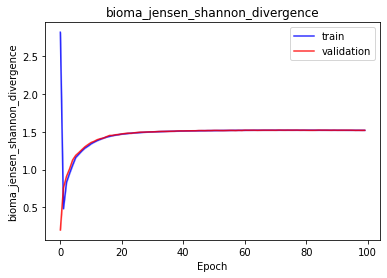

<b>domain_mse</b>: 2787703552.0000 (min: 2787703552.0000, max: 2787703552.0000)

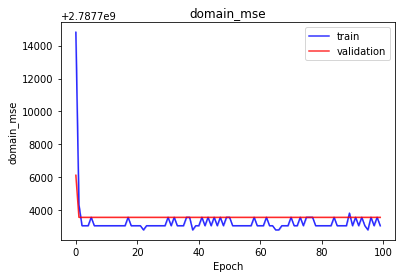

<b>domain_mae</b>: 9028.4551 (min: 9028.4551, max: 9028.4551)

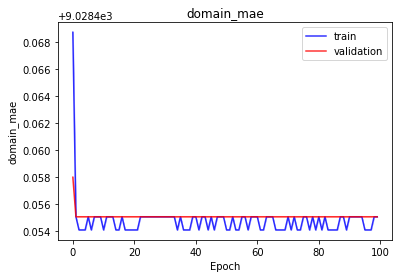

<b>domain_mape</b>: 69.2618 (min: 69.2618, max: 69.2618)

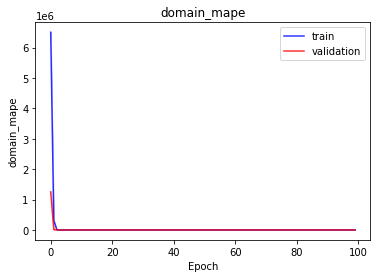

<b>domain_BrayCurtis</b>: 0.2147 (min: 0.2147, max: 0.2147)

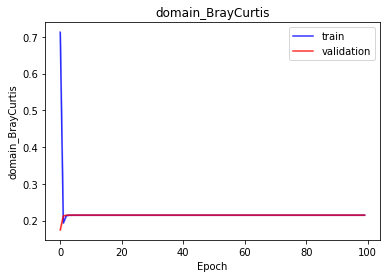

<b>domain_pearson_corr</b>: 0.9540 (min: 0.9540, max: 0.9540)

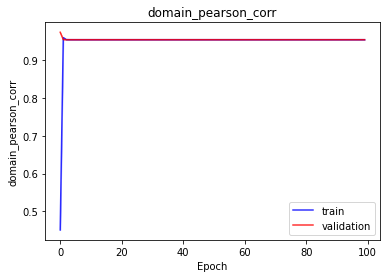

<b>domain_jensen_shannon_divergence</b>: 1.5215 (min: 1.5215, max: 1.5215)

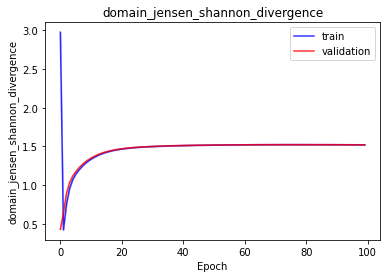

<b>latent_mae</b>: 0.0020 (min: 0.0020, max: 0.0020)

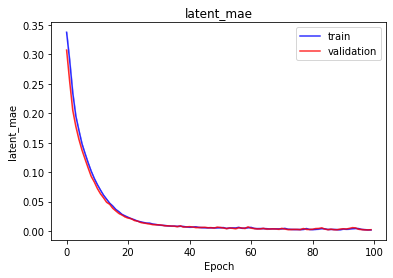

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 0.4314539432525635 | 0.4314539432525635 | 0.4314539432525635 |
| bioma_loss | 0.21473351120948792 | 0.21473351120948792 | 0.21473351120948792 |
| domain_loss | 0.21473351120948792 | 0.21473351120948792 | 0.21473351120948792 |
| latent_loss | 0.001986878691241145 | 0.001986878691241145 | 0.001986878691241145 |
| bioma_mse | 2787703552.0 | 2787703552.0 | 2787703552.0 |
| bioma_mae | 9028.455078125 | 9028.455078125 | 9028.455078125 |
| bioma_mape | 69.26155853271484 | 69.26155853271484 | 69.26155853271484 |
| bioma_BrayCurtis | 0.21473351120948792 | 0.21473351120948792 | 0.21473351120948792 |
| bioma_pearson_corr | 0.9540331959724426 | 0.9540331959724426 | 0.9540331959724426 |
| bioma_jensen_shannon_divergence | 1.5219048261642456 | 1.5219048261642456 | 1.5219048261642456 |
| domain_mse | 2787703552.0 | 2787703552.0 | 2787703552.0 |
| domain_mae | 9028.455078125 | 9028.455078125 | 9028.455078125 |
| domain_mape | 69.26177215576172 | 69.26177215576172 | 69.26177215576172 |
| domain_BrayCurtis | 0.21473351120948792 | 0.21473351120948792 | 0.21473351120948792 |
| domain_pearson_corr | 0.954033374786377 | 0.954033374786377 | 0.954033374786377 |
| domain_jensen_shannon_divergence | 1.5214648246765137 | 1.5214648246765137 | 1.5214648246765137 |
| latent_mae | 0.001986878691241145 | 0.001986878691241145 | 0.001986878691241145 |


*************

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.21448419988155365 | 0.21448419988155365 | 0.21448419988155365 |
| pearson_corr | 0.9567595720291138 | 0.9567595720291138 | 0.9567595720291138 |
| jensen_shannon_divergence | 1.5133455991744995 | 1.5133455991744995 | 1.5133455991744995 |


In [57]:
experiment_metrics, models, results = perform_experiment_2_mod(cv_folds=0,
                                                               epochs=100,
                                                               batch_size=64,
                                                               learning_rate=0.001,
                                                               optimizer=optimizers.Adam,
                                                               learning_rate_scheduler=None,
                                                               input_transform=Percentage,
                                                               output_transform=tf.keras.layers.Softmax,
                                                               reconstruction_loss=MakeLoss(LossBrayCurtis, Percentage, None),
                                                               latent_space=15,
                                                               layers=[512,256],
                                                               activation='tanh',
                                                               activation_latent='tanh',
                                                               data_microbioma_train=data_microbioma_train,
                                                               data_domain_train=data_domain_train,
                                                               show_results=True,
                                                               device='/CPU:0')
    
#Guardamos el modelo, encoder y decoder
model, encoder, _ ,decoder = models[0]
  
def model_fn_latent():
    in_layer = layers.Input(shape=(data_domain_train.shape[1],))
    net = layers.Dense(128, activation='sigmoid')(in_layer)
    net = layers.Dense(64, activation='sigmoid')(net)
    net = layers.Dense(32, activation='sigmoid')(net)
    net = layers.Dense(16, activation='sigmoid')(net)
    out_layer = layers.Dense(latent_train.shape[1], activation='tanh')(net)
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    model.compile(optimizer=optimizers.Adam(lr=0.001), loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.MeanSquaredError()])
    return model
    
#funcion del modelado -- por ahora lo dejaremos asi, y voy a habalr con ella par aver que cambio, que tuneo
latent_train = encoder.predict(data_microbioma_train)
    
result_latent, model_latent = train_tl_noEnsemble(model_fn_latent,
                                                  latent_train,
                                                  latent_train,
                                                  data_domain_train,
                                                  data_domain_train,
                                                  epochs=100,
                                                  batch_size=16,
                                                  verbose=-1)

#evaluamos el modelo
latent_test = encoder.predict(data_microbioma_test)
predictions = test_model_tl_noEnsemble(model_latent, decoder, Percentage, tf.keras.layers.Softmax, otu_columns, data_microbioma_test, data_domain_test)

In [58]:
encoder_biome = encoder
encoder_domain = model_latent
#Guardamos las predicciones
df_microbioma_test.T.to_csv('Results/otus_original_test_22OTU_orden.tsv', index=True, header=True, sep='\t')

#run prediction test set from microbiome, i.e, reconstructed
# Input only domain (i.e. environmental features)
pred_latent_biome = encoder_biome.predict(data_microbioma_test)
pred_biome = decoder.predict(pred_latent_biome)

_, _ = save_predicted_otu_table_and_latent(pred_biome,pred_latent_biome,df_microbioma_test.index,df_microbioma_test.columns,'reconstAEfromBiome_22OTU_orden')

#run prediction test set from domain, i.e., diet features
# Input only domain (i.e. environmental features)
pred_latent = encoder_domain.predict(data_domain_test)
pred_domain = decoder.predict(pred_latent)
df_pred_otu, df_pred_latent = save_predicted_otu_table_and_latent(pred_domain,pred_latent,df_microbioma_test.index,df_microbioma_test.columns,'predFromDomain_22OTU_orden')

#--------------------
actual_array = transform_to_rel_abundance(data_microbioma_test)
RSE_perOTU, RRSE_perOTU  = compute_relative_squared_error(actual_array,pred_domain)

df_error_perOTU = save_errors_per_OTU(RSE_perOTU,RRSE_perOTU,df_microbioma_test.columns,'Results/errors_perOTU_22OTU_orden')

In [ ]:
metrics = FI()
tabla_FI = pd.DataFrame.from_dict(metrics)
tabla_FI.to_csv("Results/nutrientes/FI/FI_OTU22_orden.csv",index=False)

### Class

In [59]:
#nombres_metadatos = ["KCAL","PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","SUGR","FIBE","CALC","IRON","MAGN","PHOS","POTA","SODI","ZINC","COPP","SELE","VC","VB1","VB2","NIAC","VB6","FOLA","VB12","VARA","RET","BCAR","ACAR","CRYP","LYCO","LZ","ATOC","VK","CHOLE","SFAT","MFAT","PFAT","VITD","CHOLN"]
nombres_metadatos = ["PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","CALC","MAGN","POTA","ZINC","VC","VB1","VB6","VARA","ACAR","CRYP","LYCO","ATOC","VK","CHOLE","VITD"]
df_microbioma_train, df_microbioma_test, _, _, \
df_domain_train, df_domain_test, _, _, otu_columns, domain_columns = read_df(metadata_names=nombres_metadatos,otu_filename='resultados_ana/nuevos_datos/arreglados/otu_table_Class.csv',metadata_filename='resultados_ana/datos_otus_metadatos_clase/metadatos_nutrientes_clase.csv')

data_microbioma_train = df_microbioma_train.to_numpy(dtype=np.float32)
data_microbioma_test = df_microbioma_test.to_numpy(dtype=np.float32)
data_domain_train = df_domain_train.to_numpy(dtype=np.float32)
data_domain_test = df_domain_test.to_numpy(dtype=np.float32)

| Parameter             | Value         |
|:----------------------|:--------------|
| Input transform | Percentage |
| Output transform | Softmax |
| Reconstruction Loss | LossBrayCurtis |
| Latent Space | 15 |
| Bioma Autoencoder | b -> 512 -> 256 -> 15 -> 256 -> 512 -> b |
| Domain Autoencoder | d -> 32 -> 16 -> 15 -> 256 -> 512 -> b |
| Activation Encoder | tanh |
| Activation Decoder | tanh |
| Activation Latent | tanh |
| CV folds | 0 |
| Epochs | 100 |
| Batch Size | 64 |
| Learning Rate Scheduler | none |
| Learning Rate | constant = 0.001 |
| Optimizer | Adam |


<p>Best iteration: <b>91</b></p>

<b>loss</b>: 0.1503 (min: 0.1503, max: 0.1503)

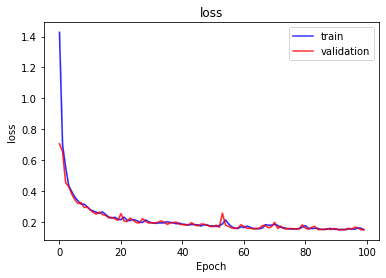

<b>bioma_loss</b>: 0.0357 (min: 0.0357, max: 0.0357)

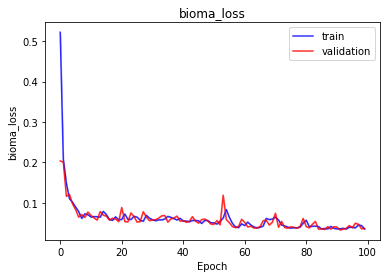

<b>domain_loss</b>: 0.1021 (min: 0.1021, max: 0.1021)

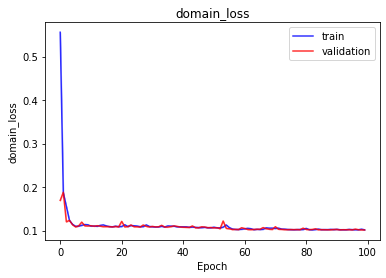

<b>latent_loss</b>: 0.0124 (min: 0.0124, max: 0.0124)

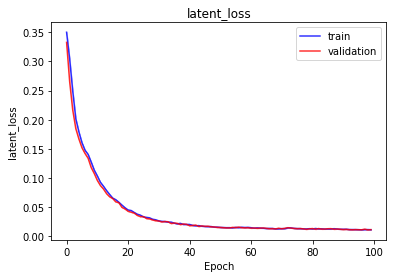

<b>bioma_mse</b>: 4695273984.0000 (min: 4695273984.0000, max: 4695273984.0000)

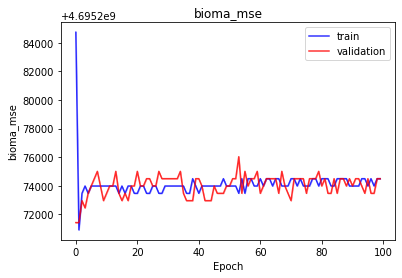

<b>bioma_mae</b>: 15206.2617 (min: 15206.2617, max: 15206.2617)

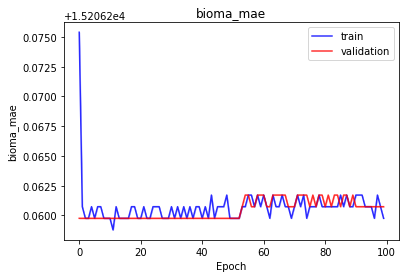

<b>bioma_mape</b>: 22075.7539 (min: 22075.7539, max: 22075.7539)

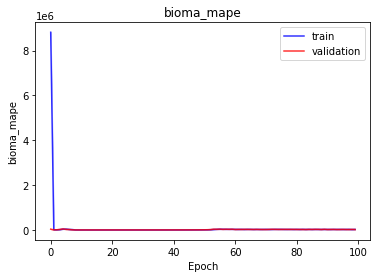

<b>bioma_BrayCurtis</b>: 0.0357 (min: 0.0357, max: 0.0357)

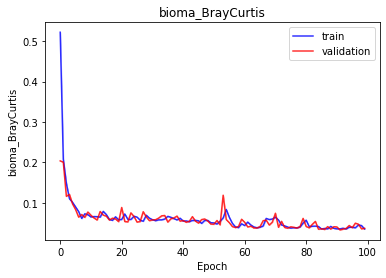

<b>bioma_pearson_corr</b>: 0.9973 (min: 0.9973, max: 0.9973)

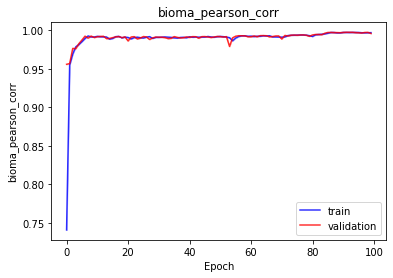

<b>bioma_jensen_shannon_divergence</b>: 0.0442 (min: 0.0442, max: 0.0442)

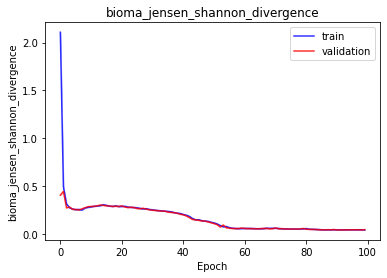

<b>domain_mse</b>: 4695273984.0000 (min: 4695273984.0000, max: 4695273984.0000)

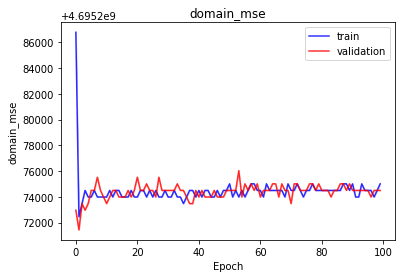

<b>domain_mae</b>: 15206.2617 (min: 15206.2617, max: 15206.2617)

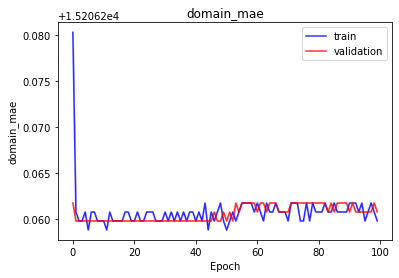

<b>domain_mape</b>: 17022.1992 (min: 17022.1992, max: 17022.1992)

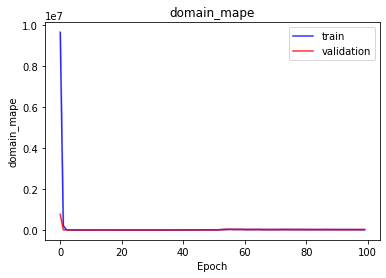

<b>domain_BrayCurtis</b>: 0.1021 (min: 0.1021, max: 0.1021)

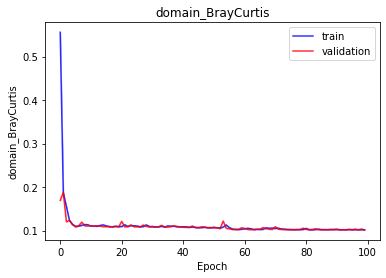

<b>domain_pearson_corr</b>: 0.9763 (min: 0.9763, max: 0.9763)

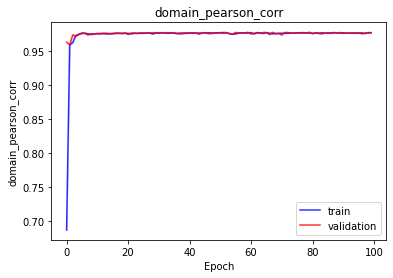

<b>domain_jensen_shannon_divergence</b>: 0.1018 (min: 0.1018, max: 0.1018)

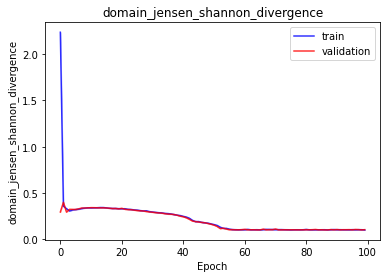

<b>latent_mae</b>: 0.0124 (min: 0.0124, max: 0.0124)

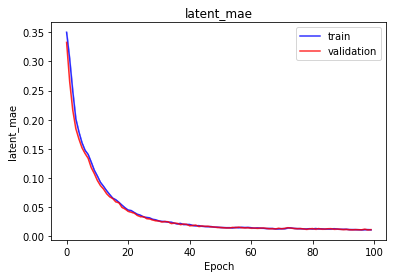

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 0.1502961963415146 | 0.1502961963415146 | 0.1502961963415146 |
| bioma_loss | 0.035714585334062576 | 0.035714585334062576 | 0.035714585334062576 |
| domain_loss | 0.10213419049978256 | 0.10213419049978256 | 0.10213419049978256 |
| latent_loss | 0.01244744285941124 | 0.01244744285941124 | 0.01244744285941124 |
| bioma_mse | 4695273984.0 | 4695273984.0 | 4695273984.0 |
| bioma_mae | 15206.26171875 | 15206.26171875 | 15206.26171875 |
| bioma_mape | 22075.75390625 | 22075.75390625 | 22075.75390625 |
| bioma_BrayCurtis | 0.035714585334062576 | 0.035714585334062576 | 0.035714585334062576 |
| bioma_pearson_corr | 0.9972615838050842 | 0.9972615838050842 | 0.9972615838050842 |
| bioma_jensen_shannon_divergence | 0.044226765632629395 | 0.044226765632629395 | 0.044226765632629395 |
| domain_mse | 4695273984.0 | 4695273984.0 | 4695273984.0 |
| domain_mae | 15206.26171875 | 15206.26171875 | 15206.26171875 |
| domain_mape | 17022.19921875 | 17022.19921875 | 17022.19921875 |
| domain_BrayCurtis | 0.10213419049978256 | 0.10213419049978256 | 0.10213419049978256 |
| domain_pearson_corr | 0.9763017892837524 | 0.9763017892837524 | 0.9763017892837524 |
| domain_jensen_shannon_divergence | 0.10184251517057419 | 0.10184251517057419 | 0.10184251517057419 |
| latent_mae | 0.01244744285941124 | 0.01244744285941124 | 0.01244744285941124 |


*************

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.10980026423931122 | 0.10980026423931122 | 0.10980026423931122 |
| pearson_corr | 0.9811080694198608 | 0.9811080694198608 | 0.9811080694198608 |
| jensen_shannon_divergence | 0.10014369338750839 | 0.10014369338750839 | 0.10014369338750839 |


In [60]:
experiment_metrics, models, results = perform_experiment_2_mod(cv_folds=0,
                                                               epochs=100,
                                                               batch_size=64,
                                                               learning_rate=0.001,
                                                               optimizer=optimizers.Adam,
                                                               learning_rate_scheduler=None,
                                                               input_transform=Percentage,
                                                               output_transform=tf.keras.layers.Softmax,
                                                               reconstruction_loss=MakeLoss(LossBrayCurtis, Percentage, None),
                                                               latent_space=15,
                                                               layers=[512,256],
                                                               activation='tanh',
                                                               activation_latent='tanh',
                                                               data_microbioma_train=data_microbioma_train,
                                                               data_domain_train=data_domain_train,
                                                               show_results=True,
                                                               device='/CPU:0')
    
#Guardamos el modelo, encoder y decoder
model, encoder, _ ,decoder = models[0]
  
def model_fn_latent():
    in_layer = layers.Input(shape=(data_domain_train.shape[1],))
    net = layers.Dense(128, activation='sigmoid')(in_layer)
    net = layers.Dense(64, activation='sigmoid')(net)
    net = layers.Dense(32, activation='sigmoid')(net)
    net = layers.Dense(16, activation='sigmoid')(net)
    out_layer = layers.Dense(latent_train.shape[1], activation='tanh')(net)
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    model.compile(optimizer=optimizers.Adam(lr=0.001), loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.MeanSquaredError()])
    return model
    
#funcion del modelado -- por ahora lo dejaremos asi, y voy a habalr con ella par aver que cambio, que tuneo
latent_train = encoder.predict(data_microbioma_train)
    
result_latent, model_latent = train_tl_noEnsemble(model_fn_latent,
                                                  latent_train,
                                                  latent_train,
                                                  data_domain_train,
                                                  data_domain_train,
                                                  epochs=100,
                                                  batch_size=16,
                                                  verbose=-1)

#evaluamos el modelo
latent_test = encoder.predict(data_microbioma_test)
predictions = test_model_tl_noEnsemble(model_latent, decoder, Percentage, tf.keras.layers.Softmax, otu_columns, data_microbioma_test, data_domain_test)

In [61]:
encoder_biome = encoder
encoder_domain = model_latent
#Guardamos las predicciones
df_microbioma_test.T.to_csv('Results/otus_original_test_22OTU_clase.tsv', index=True, header=True, sep='\t')

#run prediction test set from microbiome, i.e, reconstructed
# Input only domain (i.e. environmental features)
pred_latent_biome = encoder_biome.predict(data_microbioma_test)
pred_biome = decoder.predict(pred_latent_biome)

_, _ = save_predicted_otu_table_and_latent(pred_biome,pred_latent_biome,df_microbioma_test.index,df_microbioma_test.columns,'reconstAEfromBiome_22OTU_clase')

#run prediction test set from domain, i.e., diet features
# Input only domain (i.e. environmental features)
pred_latent = encoder_domain.predict(data_domain_test)
pred_domain = decoder.predict(pred_latent)
df_pred_otu, df_pred_latent = save_predicted_otu_table_and_latent(pred_domain,pred_latent,df_microbioma_test.index,df_microbioma_test.columns,'predFromDomain_22OTU_clase')

#--------------------
actual_array = transform_to_rel_abundance(data_microbioma_test)
RSE_perOTU, RRSE_perOTU  = compute_relative_squared_error(actual_array,pred_domain)

df_error_perOTU = save_errors_per_OTU(RSE_perOTU,RRSE_perOTU,df_microbioma_test.columns,'Results/errors_perOTU_22OTU_clase')

In [ ]:
metrics = FI()
tabla_FI = pd.DataFrame.from_dict(metrics)
tabla_FI.to_csv("Results/nutrientes/FI/FI_OTU22_clase.csv",index=False)

### Phylum

In [62]:
#nombres_metadatos = ["KCAL","PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","SUGR","FIBE","CALC","IRON","MAGN","PHOS","POTA","SODI","ZINC","COPP","SELE","VC","VB1","VB2","NIAC","VB6","FOLA","VB12","VARA","RET","BCAR","ACAR","CRYP","LYCO","LZ","ATOC","VK","CHOLE","SFAT","MFAT","PFAT","VITD","CHOLN"]
nombres_metadatos = ["PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","CALC","MAGN","POTA","ZINC","VC","VB1","VB6","VARA","ACAR","CRYP","LYCO","ATOC","VK","CHOLE","VITD"]
df_microbioma_train, df_microbioma_test, _, _, \
df_domain_train, df_domain_test, _, _, otu_columns, domain_columns = read_df(metadata_names=nombres_metadatos,otu_filename='resultados_ana/nuevos_datos/arreglados/otu_table_Phylum.csv',metadata_filename='resultados_ana/datos_otus_metadatos_filo/metadatos_nutrientes_filo.csv')

data_microbioma_train = df_microbioma_train.to_numpy(dtype=np.float32)
data_microbioma_test = df_microbioma_test.to_numpy(dtype=np.float32)
data_domain_train = df_domain_train.to_numpy(dtype=np.float32)
data_domain_test = df_domain_test.to_numpy(dtype=np.float32)

| Parameter             | Value         |
|:----------------------|:--------------|
| Input transform | Percentage |
| Output transform | Softmax |
| Reconstruction Loss | LossBrayCurtis |
| Latent Space | 15 |
| Bioma Autoencoder | b -> 512 -> 256 -> 15 -> 256 -> 512 -> b |
| Domain Autoencoder | d -> 32 -> 16 -> 15 -> 256 -> 512 -> b |
| Activation Encoder | tanh |
| Activation Decoder | tanh |
| Activation Latent | tanh |
| CV folds | 0 |
| Epochs | 100 |
| Batch Size | 64 |
| Learning Rate Scheduler | none |
| Learning Rate | constant = 0.001 |
| Optimizer | Adam |


<p>Best iteration: <b>97</b></p>

<b>loss</b>: 0.1534 (min: 0.1534, max: 0.1534)

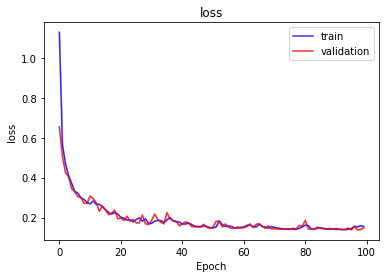

<b>bioma_loss</b>: 0.0427 (min: 0.0427, max: 0.0427)

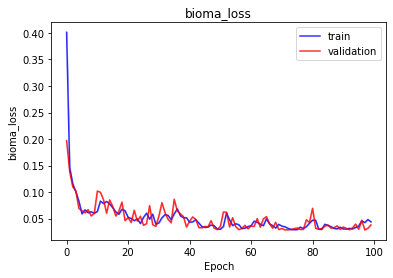

<b>domain_loss</b>: 0.0993 (min: 0.0993, max: 0.0993)

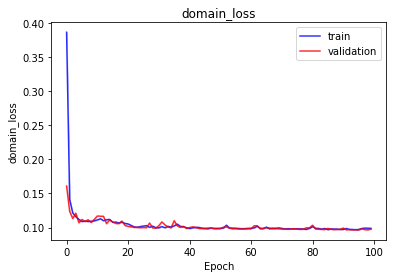

<b>latent_loss</b>: 0.0114 (min: 0.0114, max: 0.0114)

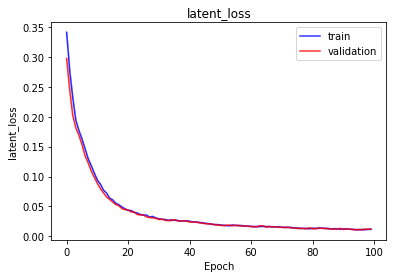

<b>bioma_mse</b>: 9952979968.0000 (min: 9952979968.0000, max: 9952979968.0000)

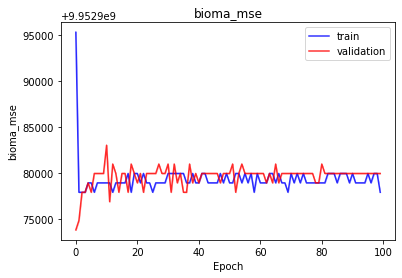

<b>bioma_mae</b>: 32181.6953 (min: 32181.6953, max: 32181.6953)

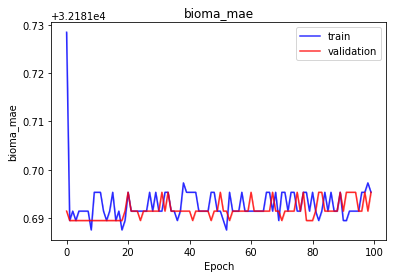

<b>bioma_mape</b>: 26938.9922 (min: 26938.9922, max: 26938.9922)

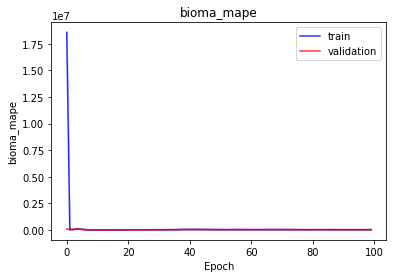

<b>bioma_BrayCurtis</b>: 0.0427 (min: 0.0427, max: 0.0427)

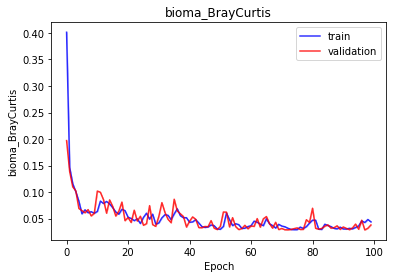

<b>bioma_pearson_corr</b>: 0.9964 (min: 0.9964, max: 0.9964)

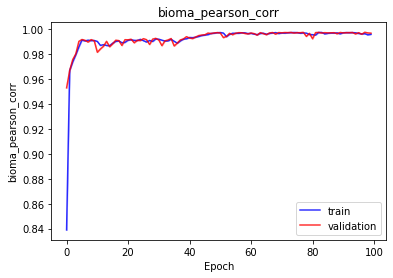

<b>bioma_jensen_shannon_divergence</b>: 0.0297 (min: 0.0297, max: 0.0297)

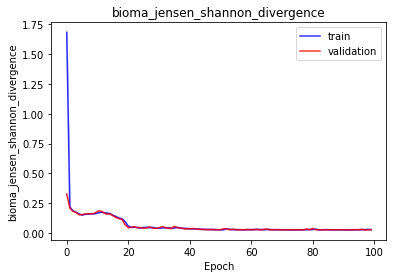

<b>domain_mse</b>: 9952979968.0000 (min: 9952979968.0000, max: 9952979968.0000)

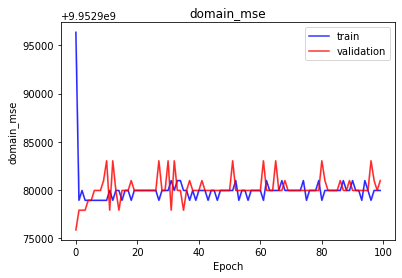

<b>domain_mae</b>: 32181.6914 (min: 32181.6914, max: 32181.6914)

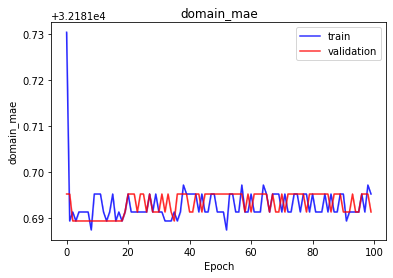

<b>domain_mape</b>: 23119.9219 (min: 23119.9219, max: 23119.9219)

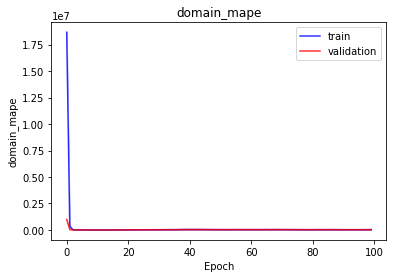

<b>domain_BrayCurtis</b>: 0.0993 (min: 0.0993, max: 0.0993)

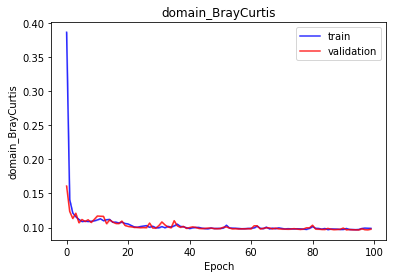

<b>domain_pearson_corr</b>: 0.9733 (min: 0.9733, max: 0.9733)

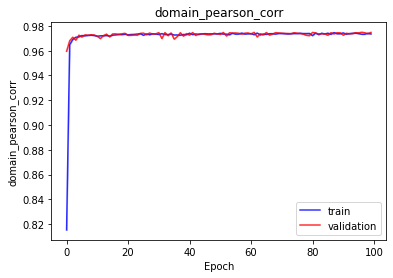

<b>domain_jensen_shannon_divergence</b>: 0.0849 (min: 0.0849, max: 0.0849)

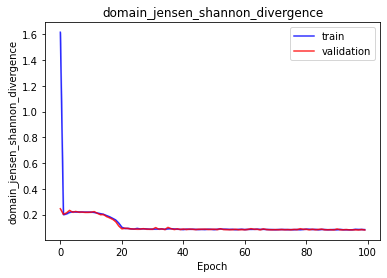

<b>latent_mae</b>: 0.0114 (min: 0.0114, max: 0.0114)

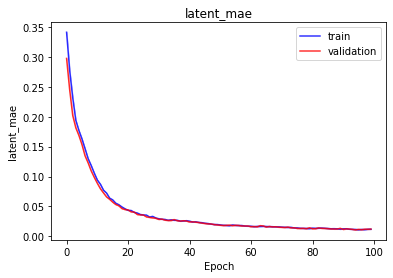

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 0.15335530042648315 | 0.15335530042648315 | 0.15335530042648315 |
| bioma_loss | 0.04271445795893669 | 0.04271445795893669 | 0.04271445795893669 |
| domain_loss | 0.099282406270504 | 0.099282406270504 | 0.099282406270504 |
| latent_loss | 0.011358442716300488 | 0.011358442716300488 | 0.011358442716300488 |
| bioma_mse | 9952979968.0 | 9952979968.0 | 9952979968.0 |
| bioma_mae | 32181.6953125 | 32181.6953125 | 32181.6953125 |
| bioma_mape | 26938.9921875 | 26938.9921875 | 26938.9921875 |
| bioma_BrayCurtis | 0.04271445795893669 | 0.04271445795893669 | 0.04271445795893669 |
| bioma_pearson_corr | 0.9964327216148376 | 0.9964327216148376 | 0.9964327216148376 |
| bioma_jensen_shannon_divergence | 0.02968144603073597 | 0.02968144603073597 | 0.02968144603073597 |
| domain_mse | 9952979968.0 | 9952979968.0 | 9952979968.0 |
| domain_mae | 32181.69140625 | 32181.69140625 | 32181.69140625 |
| domain_mape | 23119.921875 | 23119.921875 | 23119.921875 |
| domain_BrayCurtis | 0.099282406270504 | 0.099282406270504 | 0.099282406270504 |
| domain_pearson_corr | 0.9732993245124817 | 0.9732993245124817 | 0.9732993245124817 |
| domain_jensen_shannon_divergence | 0.0849456638097763 | 0.0849456638097763 | 0.0849456638097763 |
| latent_mae | 0.011358442716300488 | 0.011358442716300488 | 0.011358442716300488 |


*************

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.10772912949323654 | 0.10772912949323654 | 0.10772912949323654 |
| pearson_corr | 0.9795923233032227 | 0.9795923233032227 | 0.9795923233032227 |
| jensen_shannon_divergence | 0.08371274918317795 | 0.08371274918317795 | 0.08371274918317795 |


In [63]:
experiment_metrics, models, results = perform_experiment_2_mod(cv_folds=0,
                                                               epochs=100,
                                                               batch_size=64,
                                                               learning_rate=0.001,
                                                               optimizer=optimizers.Adam,
                                                               learning_rate_scheduler=None,
                                                               input_transform=Percentage,
                                                               output_transform=tf.keras.layers.Softmax,
                                                               reconstruction_loss=MakeLoss(LossBrayCurtis, Percentage, None),
                                                               latent_space=15,
                                                               layers=[512,256],
                                                               activation='tanh',
                                                               activation_latent='tanh',
                                                               data_microbioma_train=data_microbioma_train,
                                                               data_domain_train=data_domain_train,
                                                               show_results=True,
                                                               device='/CPU:0')
    
#Guardamos el modelo, encoder y decoder
model, encoder, _ ,decoder = models[0]
  
def model_fn_latent():
    in_layer = layers.Input(shape=(data_domain_train.shape[1],))
    net = layers.Dense(128, activation='sigmoid')(in_layer)
    net = layers.Dense(64, activation='sigmoid')(net)
    net = layers.Dense(32, activation='sigmoid')(net)
    net = layers.Dense(16, activation='sigmoid')(net)
    out_layer = layers.Dense(latent_train.shape[1], activation='tanh')(net)
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    model.compile(optimizer=optimizers.Adam(lr=0.001), loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.MeanSquaredError()])
    return model
    
#funcion del modelado -- por ahora lo dejaremos asi, y voy a habalr con ella par aver que cambio, que tuneo
latent_train = encoder.predict(data_microbioma_train)
    
result_latent, model_latent = train_tl_noEnsemble(model_fn_latent,
                                                  latent_train,
                                                  latent_train,
                                                  data_domain_train,
                                                  data_domain_train,
                                                  epochs=100,
                                                  batch_size=16,
                                                  verbose=-1)

#evaluamos el modelo
latent_test = encoder.predict(data_microbioma_test)
predictions = test_model_tl_noEnsemble(model_latent, decoder, Percentage, tf.keras.layers.Softmax, otu_columns, data_microbioma_test, data_domain_test)

In [64]:
encoder_biome = encoder
encoder_domain = model_latent
#Guardamos las predicciones
df_microbioma_test.T.to_csv('Results/otus_original_test_22OTU_filo.tsv', index=True, header=True, sep='\t')

#run prediction test set from microbiome, i.e, reconstructed
# Input only domain (i.e. environmental features)
pred_latent_biome = encoder_biome.predict(data_microbioma_test)
pred_biome = decoder.predict(pred_latent_biome)

_, _ = save_predicted_otu_table_and_latent(pred_biome,pred_latent_biome,df_microbioma_test.index,df_microbioma_test.columns,'reconstAEfromBiome_22OTU_filo')

#run prediction test set from domain, i.e., diet features
# Input only domain (i.e. environmental features)
pred_latent = encoder_domain.predict(data_domain_test)
pred_domain = decoder.predict(pred_latent)
df_pred_otu, df_pred_latent = save_predicted_otu_table_and_latent(pred_domain,pred_latent,df_microbioma_test.index,df_microbioma_test.columns,'predFromDomain_22OTU_filo')

#--------------------
actual_array = transform_to_rel_abundance(data_microbioma_test)
RSE_perOTU, RRSE_perOTU  = compute_relative_squared_error(actual_array,pred_domain)

df_error_perOTU = save_errors_per_OTU(RSE_perOTU,RRSE_perOTU,df_microbioma_test.columns,'Results/errors_perOTU_22OTU_filo')

In [ ]:
metrics = FI()
tabla_FI = pd.DataFrame.from_dict(metrics)
tabla_FI.to_csv("Results/nutrientes/FI/FI_OTU22_filo.csv",index=False)